In [1]:
import pandas as pd
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
target_months = 6

In [3]:
basedir = './국토교통부_실거래가_공개시스템/땅값분석/'
yunrip_df = pd.read_csv(basedir + 'yunrip_25.csv')
commerce_df = pd.read_csv(basedir + 'commerce_25.csv')
land_df = pd.read_csv(basedir + 'land.csv')

In [4]:
common_cols = ['시군구', '번지', '용도지역', '도로조건', '계약날짜', '대지면적(㎡)', '거래금액(만원)', '단가(㎡)', '단가(평)', '부동산유형', '건물연식']
common_df = pd.concat([yunrip_df[common_cols], commerce_df[common_cols], land_df[[col for col in land_df.columns if col not in ['지목', '지분구분', '해제사유발생일']]]])
common_df['계약날짜'] = pd.to_datetime(common_df['계약날짜'], format='%Y-%m-%d')
common_df
print(common_df.shape)
common_df.head()

(408768, 11)


,시군구,번지,용도지역,도로조건,계약날짜,대지면적(㎡),거래금액(만원),단가(㎡),단가(평),부동산유형,건물연식
0,서울특별시 강남구 개포동,1264-3,제2종일반주거지역,8m미만,2006-08-29,29.23,11500.0,393.431406,1300.599641,연립다세대,29.0
1,서울특별시 강남구 개포동,171-13,제2종일반주거지역,8m미만,2006-12-20,56.10,56500.0,1007.130125,3329.355660,연립다세대,33.0
2,서울특별시 강남구 개포동,171-13,제2종일반주거지역,8m미만,2016-01-16,39.60,23300.0,588.383838,1945.070467,연립다세대,33.0
3,서울특별시 강남구 개포동,171-13,제2종일반주거지역,8m미만,2016-04-09,39.60,24500.0,618.686869,2045.245770,연립다세대,33.0
4,서울특별시 강남구 개포동,171-13,제2종일반주거지역,8m미만,2019-10-23,56.10,60000.0,1069.518717,3535.598930,연립다세대,33.0


In [5]:
common_df['용도지역'].value_counts()

제2종일반주거지역    227652
제1종일반주거지역     53207
제3종일반주거지역     48182
제2종일반주거       13006
준주거지역         12306
일반상업지역        11412
준공업지역          9172
제3종일반주거        7810
개발제한구역         7758
일반상업           6348
자연녹지지역         3151
준주거            2716
제1종전용주거지역      2108
준공업            1370
제1종일반주거         808
근린상업지역          579
근린상업            285
제1종전용주거         147
중심상업            143
중심상업지역          139
일반주거지역          110
제2종전용주거지역        90
용도미지정            43
유통상업지역           39
기타               38
전용주거지역           23
자연녹지             22
관리지역             22
일반주거             18
제2종전용주거          13
생산녹지지역            9
유통상업              7
계획관리지역            4
보전녹지지역            2
생산관리지역            1
일반공업              1
전용주거              1
일반공업지역            1
Name: 용도지역, dtype: int64

In [6]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [7]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [8]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [9]:
yunrip_df = data_prep('연립다세대', '매매')
yunrip_df['부동산유형'] = '연립다세대'
print(yunrip_df.shape)
yunrip_df.head()

16it [00:01, 10.87it/s]


(644920, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0,연립다세대


In [10]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_baseline.csv').sort_values(['지번주소', '년']).reset_index(drop=True)
print(land_specs_df.shape)
land_specs_df.head()

(8405705, 10)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,2013.0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 100-0,2014.0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
2,서울특별시 강남구 개포동 100-0,2015.0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
3,서울특별시 강남구 개포동 100-0,2016.0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
4,서울특별시 강남구 개포동 100-0,2017.0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지


In [11]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '용도지역명2']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(982961, 8)


,지번주소,지목명,토지면적,용도지역명1,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,516.0,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,전,완경사,부정형,맹지


In [12]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [13]:
yunrip_df = yunrip_df[
    (yunrip_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_months)))
]
print(yunrip_df.shape)
yunrip_df.head()

(27438, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
613366,서울특별시 강남구 개포동 1164-27,논현로2길 66,(1164-27),51.78,36.36,68000,3,2016.0,5.0,2021-06-03,1313.248358,5.0,연립다세대
613367,서울특별시 강남구 개포동 1262-0,개포로31길 20,(1262-0),108.28,72.93,110000,3,2006.0,15.0,2021-06-07,1015.884743,15.0,연립다세대
613368,서울특별시 강남구 개포동 1213-0,개포로32길 6,1213,38.26,33.06,52500,6,2016.0,5.0,2021-05-13,1372.190277,5.0,연립다세대
613369,서울특별시 강남구 개포동 1196-9,논현로12길 9-6,Classe,43.08,31.41,48500,4,2015.0,6.0,2021-05-10,1125.812442,6.0,연립다세대
613370,서울특별시 강남구 개포동 1245-5,개포로17길 9-3,G-heim,25.89,16.85,38500,3,2017.0,4.0,2021-06-25,1487.060641,4.0,연립다세대


In [14]:
yunrip_df = yunrip_df[
    (yunrip_df['건물연식'] <= 1)
]
print(yunrip_df.shape)
yunrip_df.head()

(5047, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
613421,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,25.64,16.41,30350,4,2021.0,0.0,2021-06-22,1183.697348,0.0,연립다세대
613422,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,21.92,14.03,25950,3,2021.0,0.0,2021-06-22,1183.850365,0.0,연립다세대
613423,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,29.17,18.67,33500,5,2021.0,0.0,2021-06-22,1148.440178,0.0,연립다세대
613424,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,21.50,13.76,25850,4,2021.0,0.0,2021-06-22,1202.325581,0.0,연립다세대
613425,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,30.93,19.80,36250,4,2021.0,0.0,2021-06-22,1172.001293,0.0,연립다세대


In [15]:
common_df = common_df[
    (common_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_months)))
]

In [16]:
print(common_df.shape)
common_df.head()

(12479, 11)


,시군구,번지,용도지역,도로조건,계약날짜,대지면적(㎡),거래금액(만원),단가(㎡),단가(평),부동산유형,건물연식
32,서울특별시 강남구 개포동,1219-11,제2종일반주거지역,8m미만,2021-03-27,19.33,26000.0,1345.059493,4446.477496,연립다세대,28.0
42,서울특별시 강남구 개포동,1252-1,제2종일반주거지역,8m미만,2021-06-19,67.70,135000.0,1994.091581,6592.038035,연립다세대,30.0
60,서울특별시 강남구 개포동,1261-8,제2종일반주거지역,8m미만,2021-06-28,28.51,32000.0,1122.413188,3710.456682,연립다세대,29.0
74,서울특별시 강남구 개포동,1171-4,제2종일반주거지역,8m미만,2021-03-06,17.34,28500.0,1643.598616,5433.383651,연립다세대,28.0
103,서울특별시 강남구 개포동,1231-15,제2종일반주거지역,12m미만,2021-05-22,13.38,21000.0,1569.506726,5188.451794,연립다세대,28.0


In [17]:
yunrip_df = yunrip_df.dropna(subset=['지번주소']).reset_index(drop=True)
print(yunrip_df.shape)

(5047, 13)


In [18]:
yunrip_df = yunrip_df[
    (yunrip_df['전용면적(㎡)'] <= 32)
    &(yunrip_df['전용면적(㎡)'] >= 28)
]
print(yunrip_df.shape)
yunrip_df.head()

(1518, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
2,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,29.17,18.67,33500,5,2021.0,0.0,2021-06-22,1148.440178,0.0,연립다세대
4,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,30.93,19.80,36250,4,2021.0,0.0,2021-06-22,1172.001293,0.0,연립다세대
5,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,30.65,19.62,35950,3,2021.0,0.0,2021-06-22,1172.920065,0.0,연립다세대
9,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,30.65,19.62,35950,2,2021.0,0.0,2021-06-22,1172.920065,0.0,연립다세대
16,서울특별시 강남구 개포동 1166-5,논현로2길 45,스타빌,29.88,19.03,33000,4,2020.0,1.0,2021-04-26,1104.417671,1.0,연립다세대


In [19]:
yunrip_df['구'] = yunrip_df['지번주소'].apply(lambda x: x.split(' ')[1])
yunrip_df['동'] = yunrip_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [20]:
yunrip_merge_df = yunrip_df.merge(last_df, on=['지번주소'])
print(yunrip_merge_df.shape)
yunrip_merge_df.head()

(1491, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지목명,토지면적,용도지역명1,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,29.17,18.67,33500,5,2021.0,0.0,2021-06-22,1148.440178,0.0,연립다세대,강남구,개포동,대,249.6,제2종일반주거지역,단독,평지,세로장방,세로각지(가)
1,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,30.93,19.80,36250,4,2021.0,0.0,2021-06-22,1172.001293,0.0,연립다세대,강남구,개포동,대,249.6,제2종일반주거지역,단독,평지,세로장방,세로각지(가)
2,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,30.65,19.62,35950,3,2021.0,0.0,2021-06-22,1172.920065,0.0,연립다세대,강남구,개포동,대,249.6,제2종일반주거지역,단독,평지,세로장방,세로각지(가)
3,서울특별시 강남구 개포동 1166-9,논현로2길 37,동영빌,30.65,19.62,35950,2,2021.0,0.0,2021-06-22,1172.920065,0.0,연립다세대,강남구,개포동,대,249.6,제2종일반주거지역,단독,평지,세로장방,세로각지(가)
4,서울특별시 강남구 개포동 1166-5,논현로2길 45,스타빌,29.88,19.03,33000,4,2020.0,1.0,2021-04-26,1104.417671,1.0,연립다세대,강남구,개포동,대,249.7,제2종일반주거지역,다세대,평지,세로장방,세로각지(가)


In [21]:
yunrip_merge_df['구'].nunique()

25

In [22]:
common_df.head()

,시군구,번지,용도지역,도로조건,계약날짜,대지면적(㎡),거래금액(만원),단가(㎡),단가(평),부동산유형,건물연식
32,서울특별시 강남구 개포동,1219-11,제2종일반주거지역,8m미만,2021-03-27,19.33,26000.0,1345.059493,4446.477496,연립다세대,28.0
42,서울특별시 강남구 개포동,1252-1,제2종일반주거지역,8m미만,2021-06-19,67.70,135000.0,1994.091581,6592.038035,연립다세대,30.0
60,서울특별시 강남구 개포동,1261-8,제2종일반주거지역,8m미만,2021-06-28,28.51,32000.0,1122.413188,3710.456682,연립다세대,29.0
74,서울특별시 강남구 개포동,1171-4,제2종일반주거지역,8m미만,2021-03-06,17.34,28500.0,1643.598616,5433.383651,연립다세대,28.0
103,서울특별시 강남구 개포동,1231-15,제2종일반주거지역,12m미만,2021-05-22,13.38,21000.0,1569.506726,5188.451794,연립다세대,28.0


In [23]:
common_df['구'] = common_df['시군구'].apply(lambda x: x.split(' ')[1])
common_df['동'] = common_df['시군구'].apply(lambda x: x.split(' ')[2])
common_df.head()

,시군구,번지,용도지역,도로조건,계약날짜,대지면적(㎡),거래금액(만원),단가(㎡),단가(평),부동산유형,건물연식,구,동
32,서울특별시 강남구 개포동,1219-11,제2종일반주거지역,8m미만,2021-03-27,19.33,26000.0,1345.059493,4446.477496,연립다세대,28.0,강남구,개포동
42,서울특별시 강남구 개포동,1252-1,제2종일반주거지역,8m미만,2021-06-19,67.70,135000.0,1994.091581,6592.038035,연립다세대,30.0,강남구,개포동
60,서울특별시 강남구 개포동,1261-8,제2종일반주거지역,8m미만,2021-06-28,28.51,32000.0,1122.413188,3710.456682,연립다세대,29.0,강남구,개포동
74,서울특별시 강남구 개포동,1171-4,제2종일반주거지역,8m미만,2021-03-06,17.34,28500.0,1643.598616,5433.383651,연립다세대,28.0,강남구,개포동
103,서울특별시 강남구 개포동,1231-15,제2종일반주거지역,12m미만,2021-05-22,13.38,21000.0,1569.506726,5188.451794,연립다세대,28.0,강남구,개포동


In [24]:
common_df = common_df.rename(columns={'단가(㎡)':'단가(만원/㎡)'})
common_df.head()

,시군구,번지,용도지역,도로조건,계약날짜,대지면적(㎡),거래금액(만원),단가(만원/㎡),단가(평),부동산유형,건물연식,구,동
32,서울특별시 강남구 개포동,1219-11,제2종일반주거지역,8m미만,2021-03-27,19.33,26000.0,1345.059493,4446.477496,연립다세대,28.0,강남구,개포동
42,서울특별시 강남구 개포동,1252-1,제2종일반주거지역,8m미만,2021-06-19,67.70,135000.0,1994.091581,6592.038035,연립다세대,30.0,강남구,개포동
60,서울특별시 강남구 개포동,1261-8,제2종일반주거지역,8m미만,2021-06-28,28.51,32000.0,1122.413188,3710.456682,연립다세대,29.0,강남구,개포동
74,서울특별시 강남구 개포동,1171-4,제2종일반주거지역,8m미만,2021-03-06,17.34,28500.0,1643.598616,5433.383651,연립다세대,28.0,강남구,개포동
103,서울특별시 강남구 개포동,1231-15,제2종일반주거지역,12m미만,2021-05-22,13.38,21000.0,1569.506726,5188.451794,연립다세대,28.0,강남구,개포동


In [25]:
last_df.head()

,지번주소,지목명,토지면적,용도지역명1,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,516.0,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,전,완경사,부정형,맹지


In [26]:
last_df['구'] = last_df['지번주소'].apply(lambda x: x.split(' ')[1])
last_df['동'] = last_df['지번주소'].apply(lambda x: x.split(' ')[2])
last_df.head()

,지번주소,지목명,토지면적,용도지역명1,토지이동상황,지형높이,지형형상,도로접면,구,동
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,전,완경사,부정형,맹지,강남구,개포동
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,전,평지,부정형,맹지,강남구,개포동
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,전,평지,부정형,맹지,강남구,개포동
3,서울특별시 강남구 개포동 103-0,전,516.0,개발제한구역,전,평지,부정형,맹지,강남구,개포동
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,전,완경사,부정형,맹지,강남구,개포동


강남구
제2종일반주거지역    0.387454
제3종일반주거지역    0.248594
개발제한구역       0.092888
일반상업지역       0.082050
제1종일반주거지역    0.074393
자연녹지지역       0.049242
제1종전용주거지역    0.048417
준주거지역        0.011339
생산녹지지역       0.005625
Name: 용도지역명1, dtype: float64


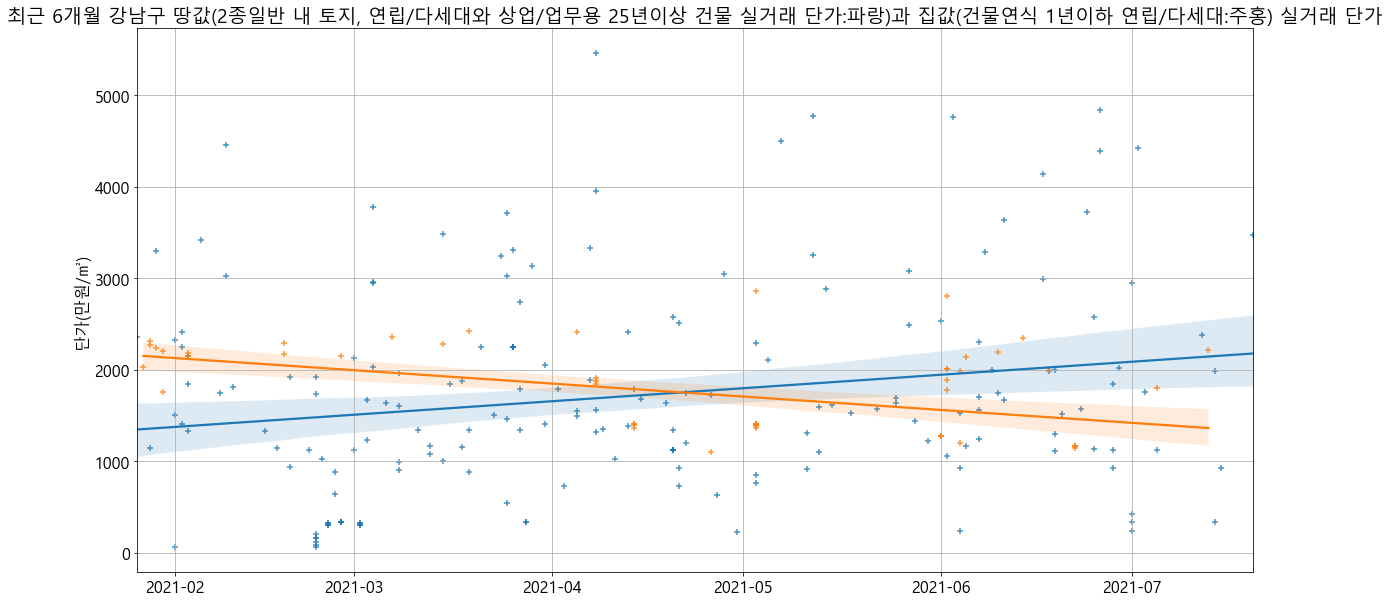

<Figure size 432x288 with 0 Axes>

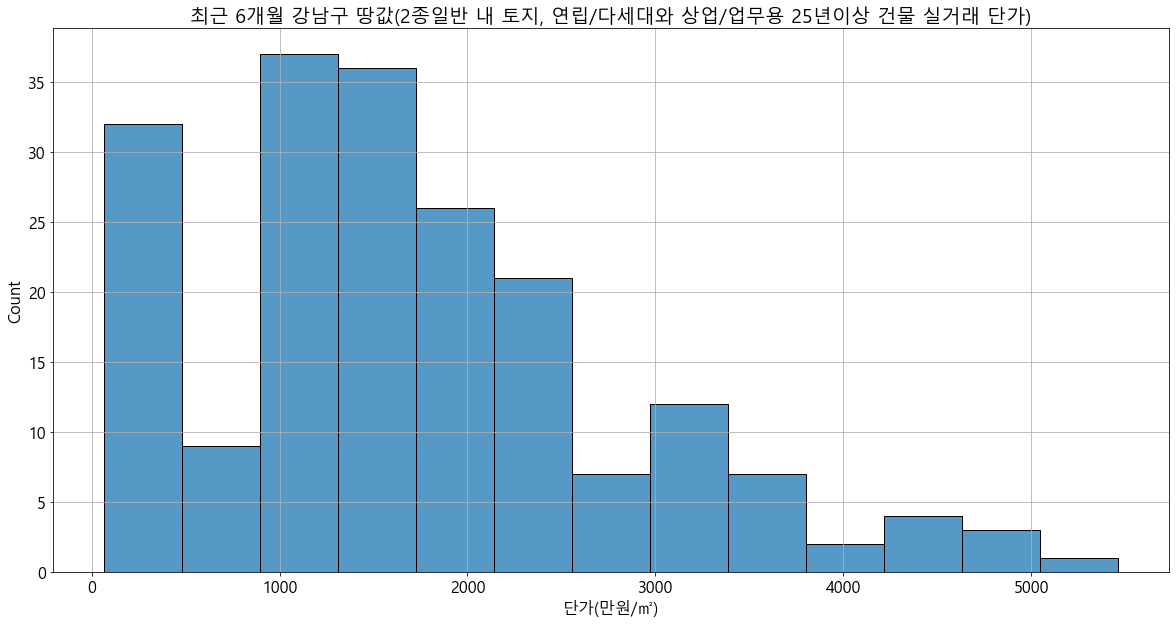

<Figure size 432x288 with 0 Axes>

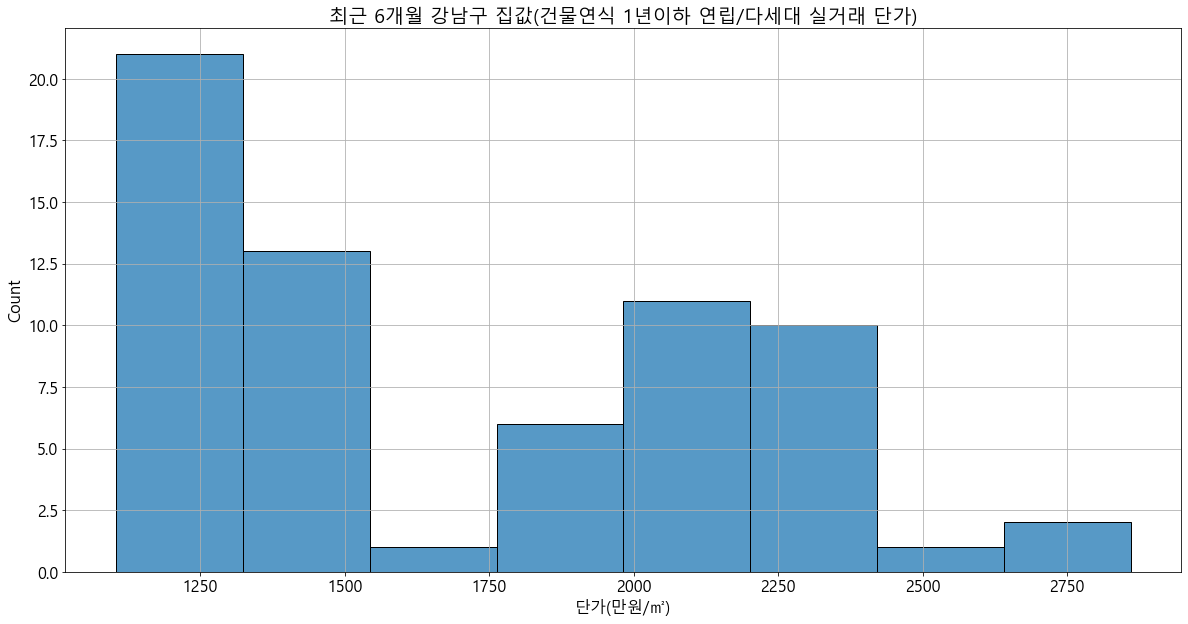

count      65.000000
mean     1710.668548
std       471.566837
min      1104.417671
25%      1274.247492
50%      1412.098930
75%      2151.260504
max      2859.526193
Name: 단가(만원/㎡), dtype: float64
count     197.000000
mean     1712.089085
std      1114.289361
min        63.348416
25%      1003.366559
50%      1559.818274
75%      2252.166225
max      5464.480874
Name: 단가(만원/㎡), dtype: float64
강동구
제2종일반주거지역    0.566183
개발제한구역       0.151090
제3종일반주거지역    0.143143
일반상업지역       0.051402
준주거지역        0.036430
자연녹지지역       0.031471
제1종일반주거지역    0.009982
근린상업지역       0.005690
제1종전용주거지역    0.004609
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

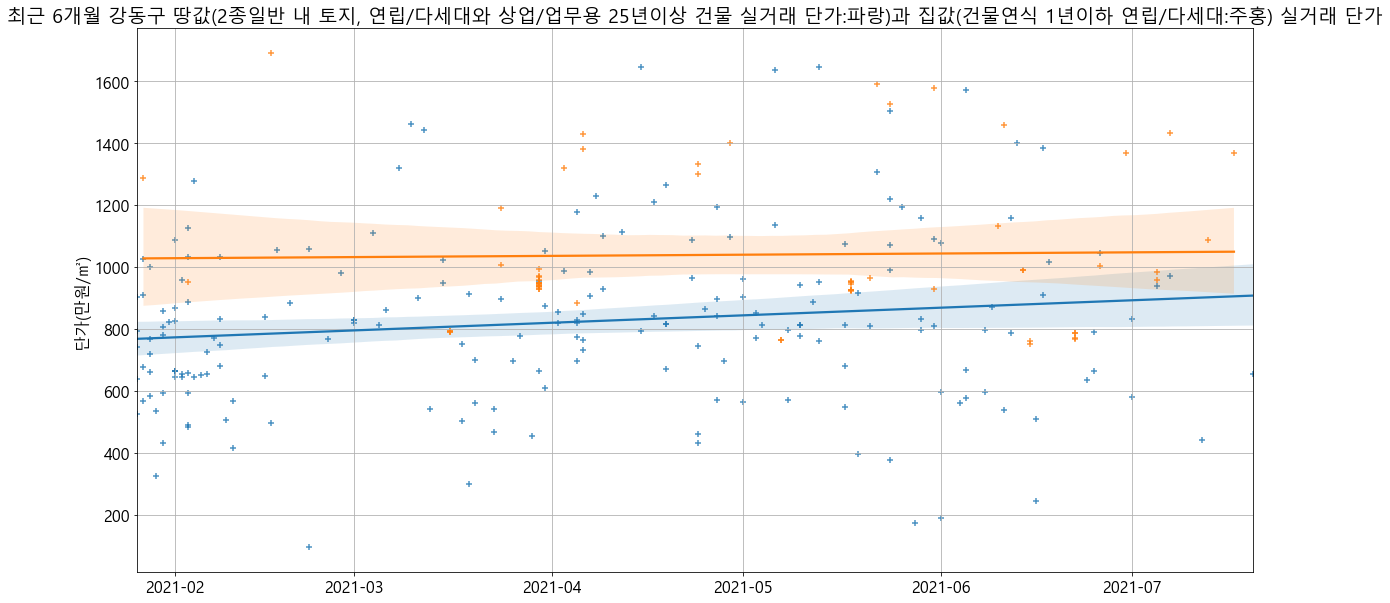

<Figure size 432x288 with 0 Axes>

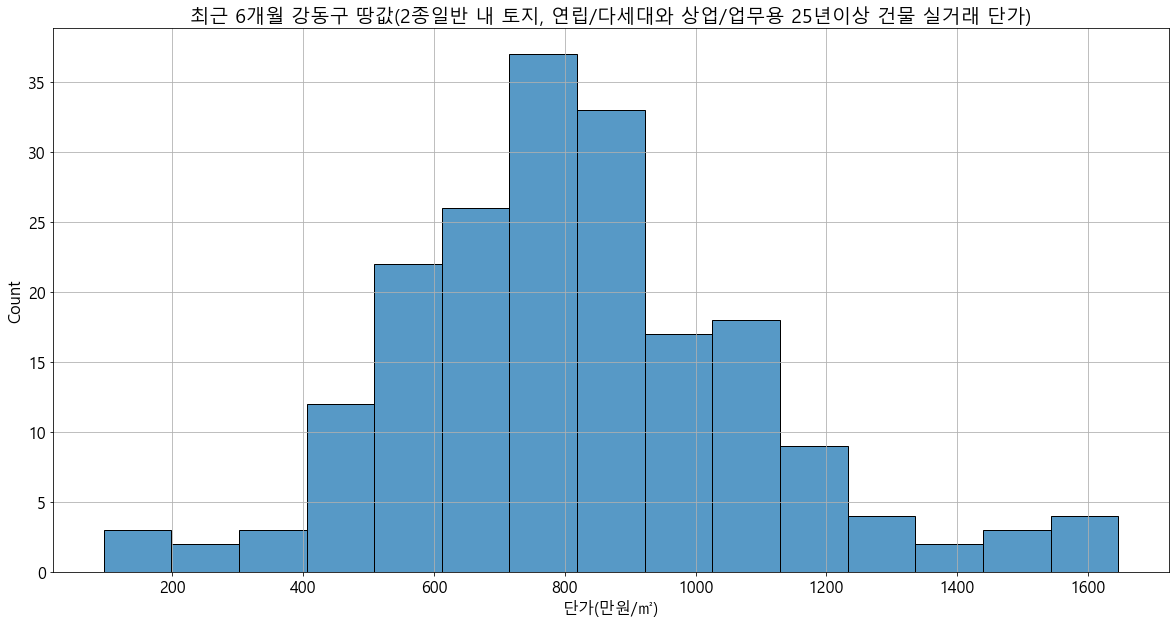

<Figure size 432x288 with 0 Axes>

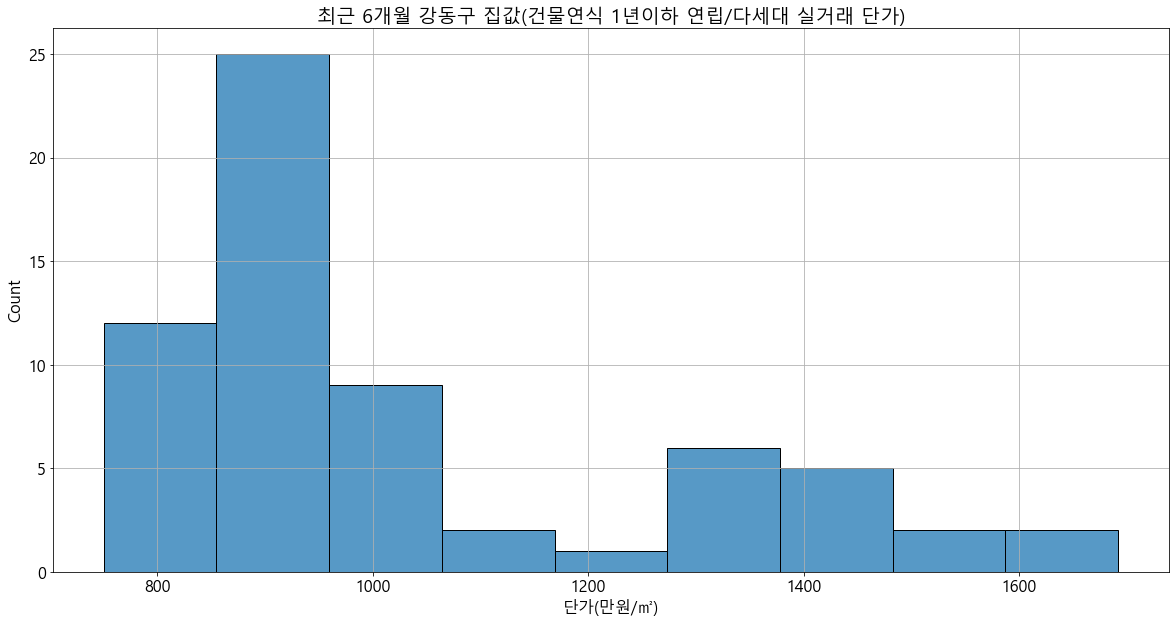

count      64.000000
mean     1040.114726
std       240.764333
min       750.338753
25%       926.994907
50%       951.045587
75%      1148.035298
max      1692.150866
Name: 단가(만원/㎡), dtype: float64
count     195.000000
mean      822.577359
std       274.081885
min        95.151515
25%       653.013468
50%       811.462239
75%       963.662904
max      1645.940015
Name: 단가(만원/㎡), dtype: float64
강북구
제2종일반주거지역    0.665558
제3종일반주거지역    0.138331
제1종일반주거지역    0.104683
준주거지역        0.045033
개발제한구역       0.023163
일반상업지역       0.019122
자연녹지지역       0.004111
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

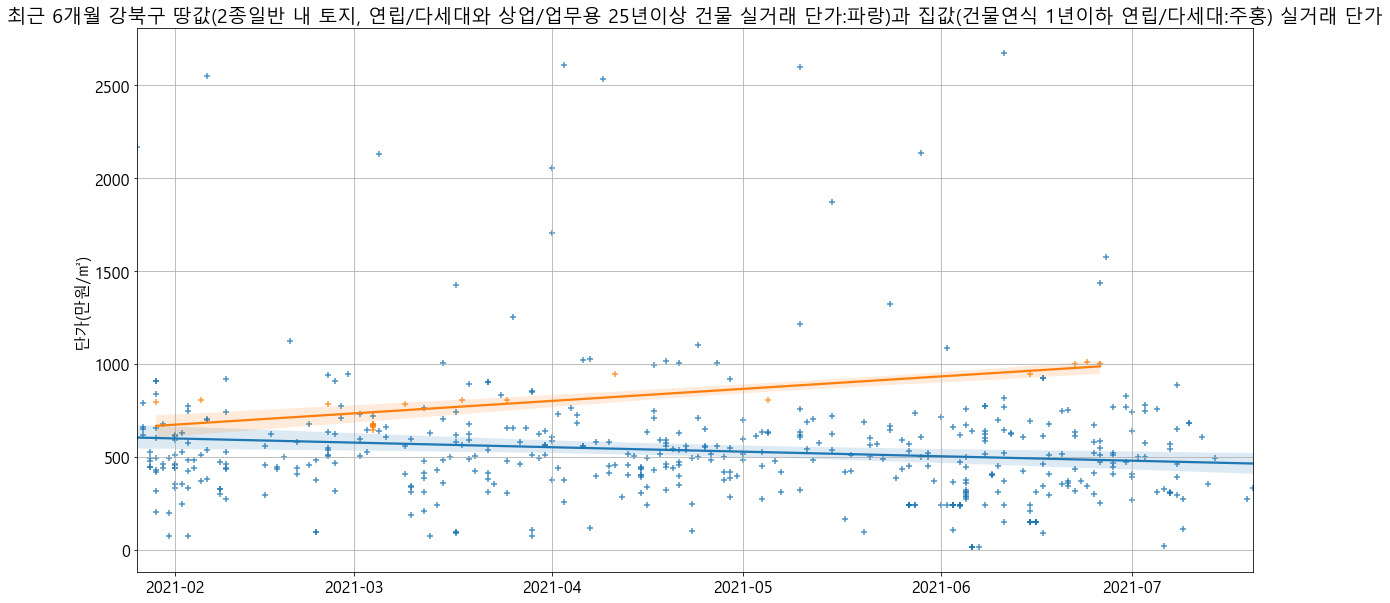

<Figure size 432x288 with 0 Axes>

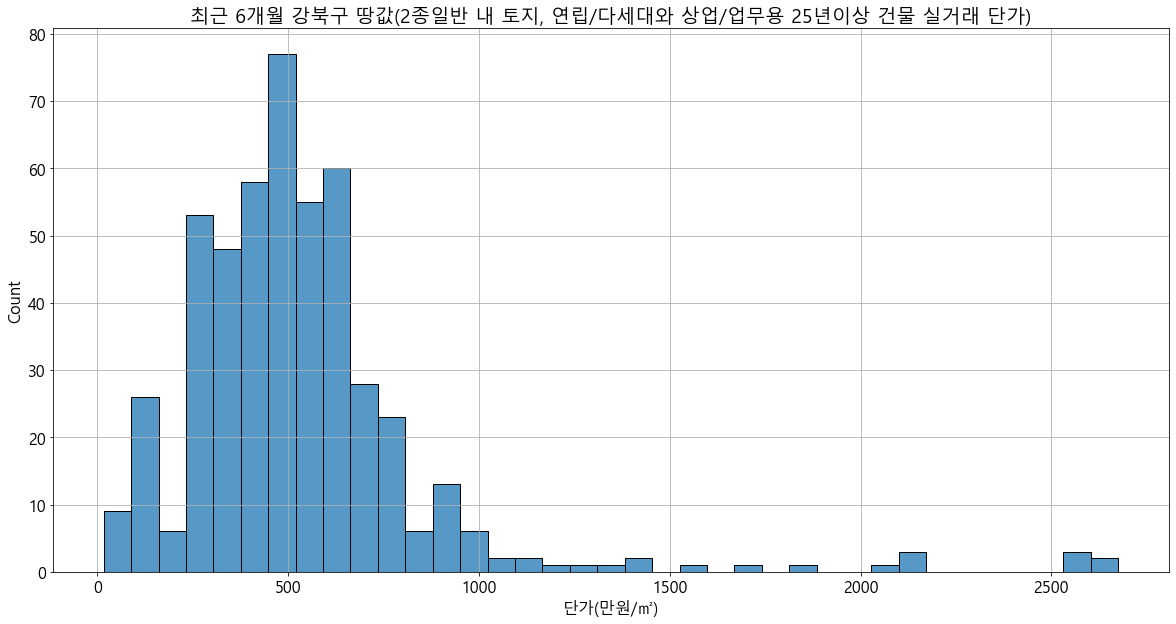

<Figure size 432x288 with 0 Axes>

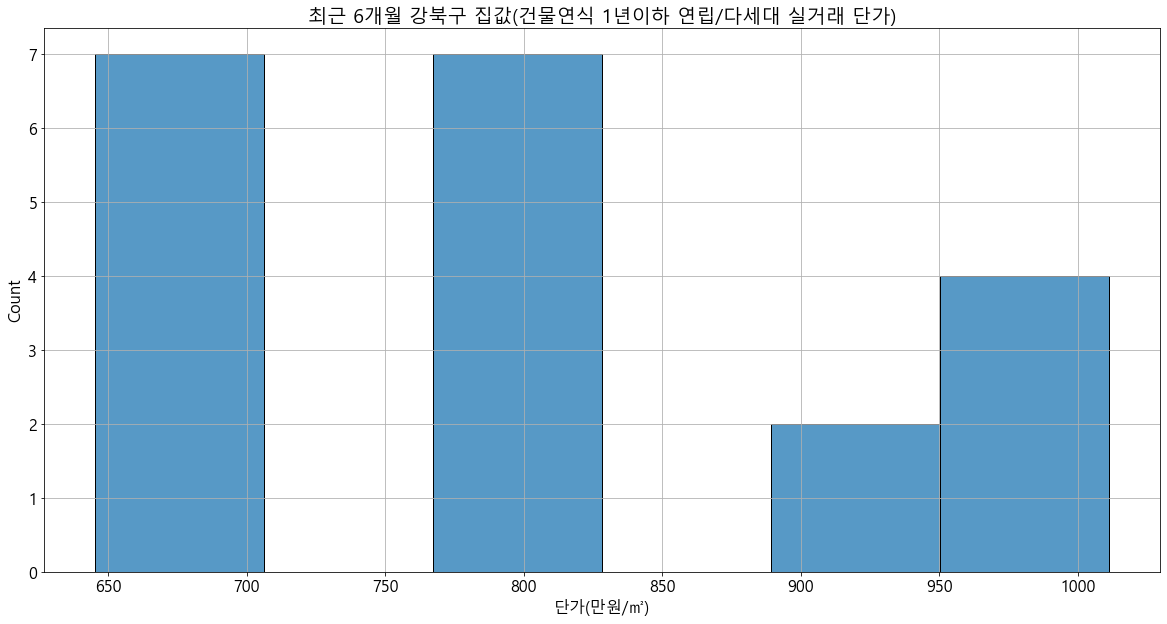

count      20.000000
mean      809.860348
std       131.910964
min       645.212429
25%       677.570093
50%       802.687487
75%       948.979592
max      1011.463250
Name: 단가(만원/㎡), dtype: float64
count     489.000000
mean      535.624308
std       352.450909
min        16.366612
25%       344.129555
50%       493.612079
75%       632.054176
max      2675.324675
Name: 단가(만원/㎡), dtype: float64
강서구
제2종일반주거지역    0.492100
개발제한구역       0.167655
제3종일반주거지역    0.117451
준공업지역        0.048529
제1종일반주거지역    0.045903
자연녹지지역       0.043594
일반상업지역       0.034473
제1종전용주거지역    0.018221
준주거지역        0.014305
근린상업지역       0.014215
생산녹지지역       0.003124
유통상업지역       0.000430
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

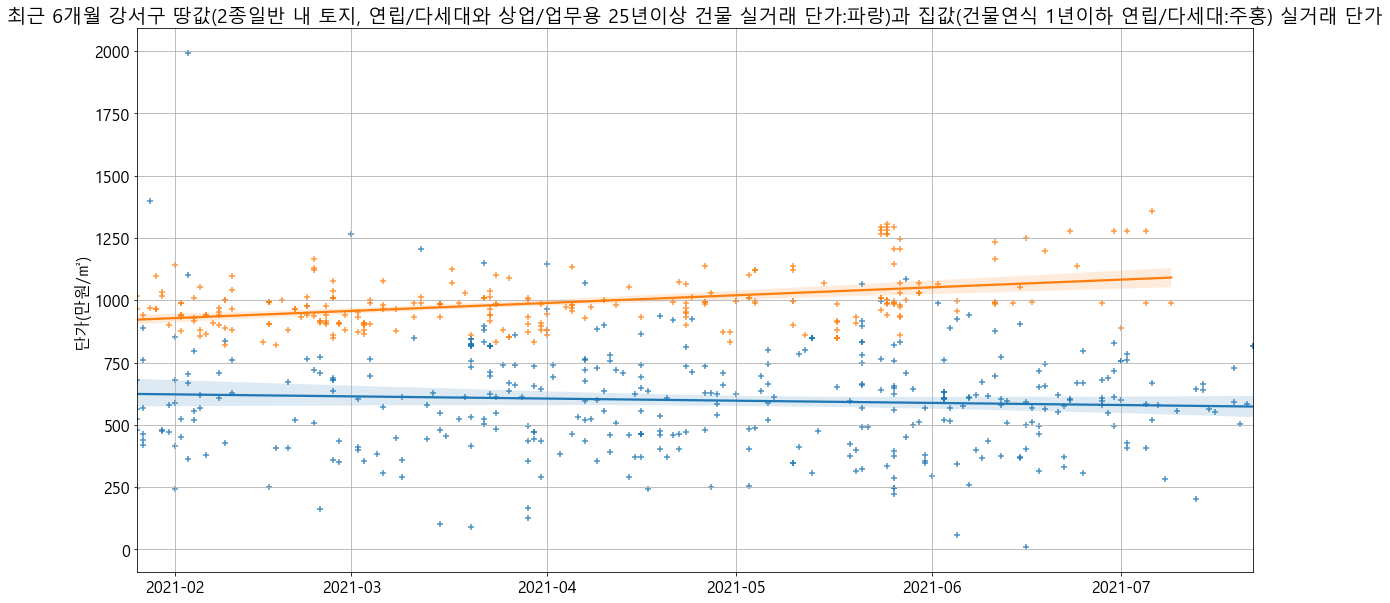

<Figure size 432x288 with 0 Axes>

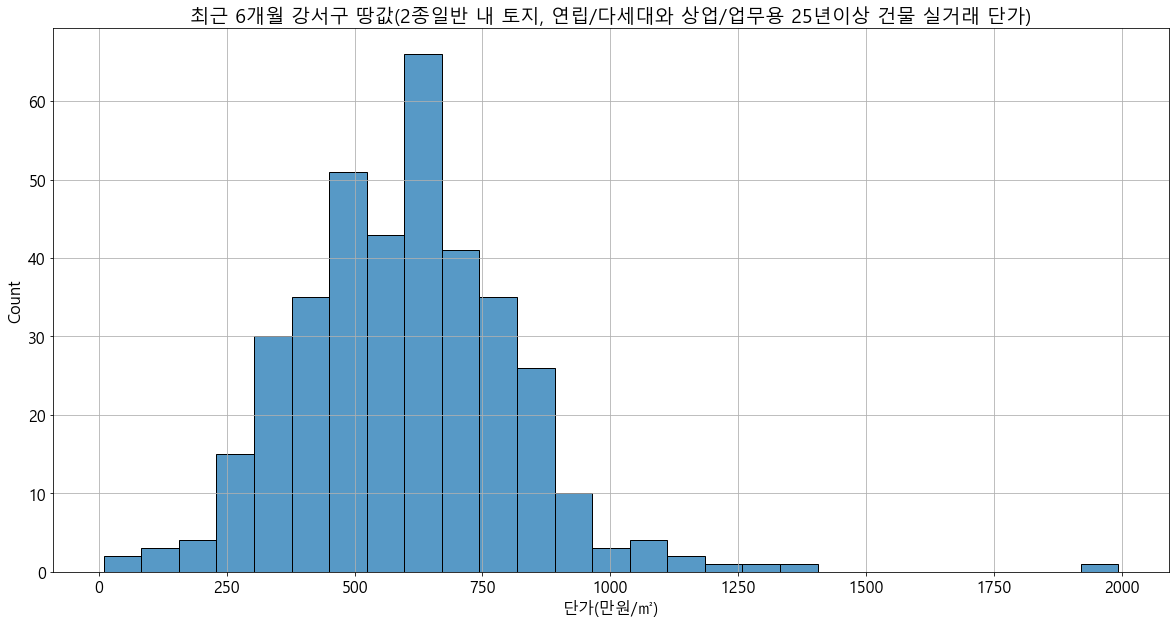

<Figure size 432x288 with 0 Axes>

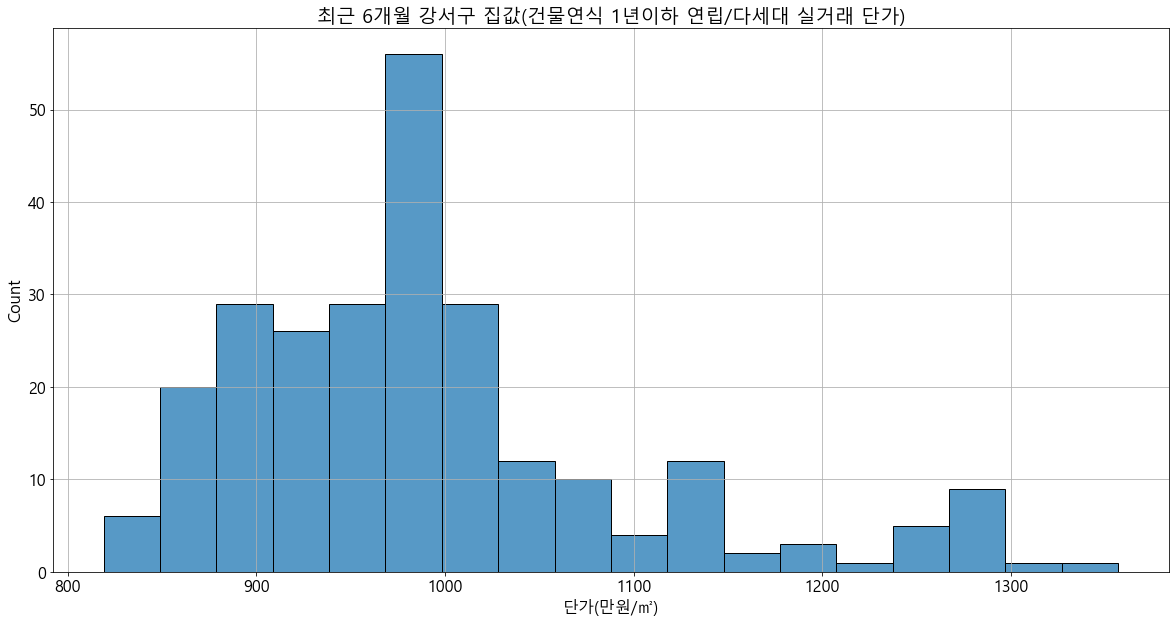

count     255.000000
mean      992.264803
std       107.615441
min       819.040952
25%       916.972324
50%       984.646195
75%      1014.591110
max      1356.783920
Name: 단가(만원/㎡), dtype: float64
count     374.000000
mean      599.062538
std       215.660012
min         9.562842
25%       459.679988
50%       601.894441
75%       731.348781
max      1992.592593
Name: 단가(만원/㎡), dtype: float64
관악구
제2종일반주거지역    0.605000
제1종일반주거지역    0.149492
제3종일반주거지역    0.133656
준주거지역        0.062320
일반상업지역       0.028943
자연녹지지역       0.017434
개발제한구역       0.003154
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

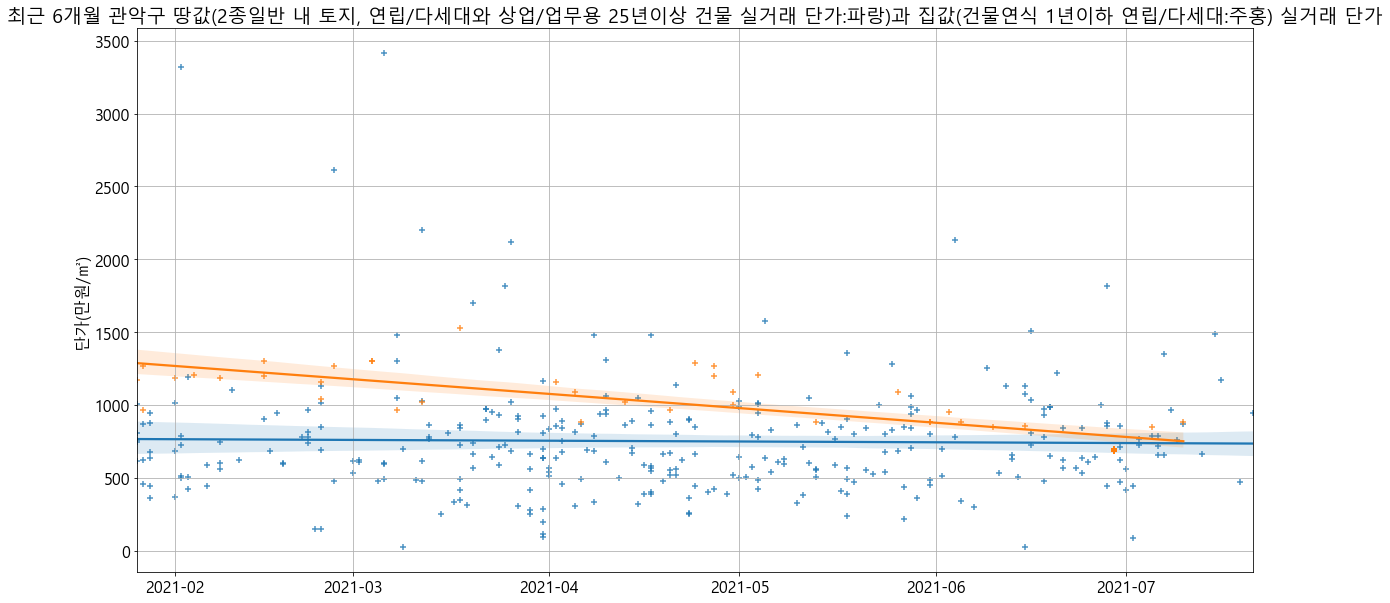

<Figure size 432x288 with 0 Axes>

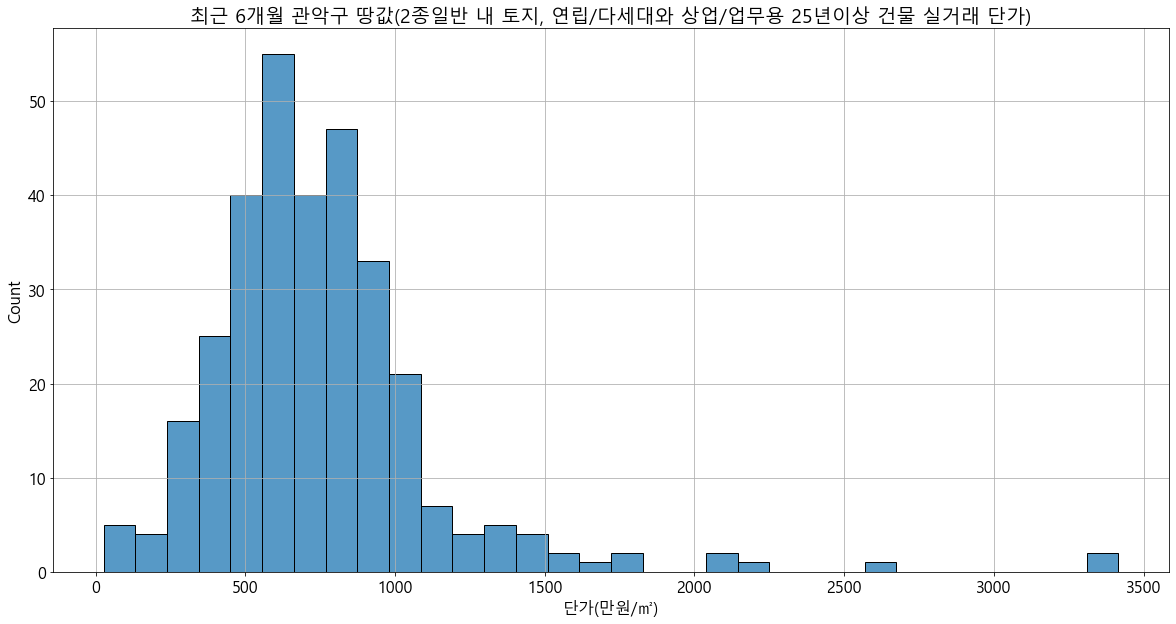

<Figure size 432x288 with 0 Axes>

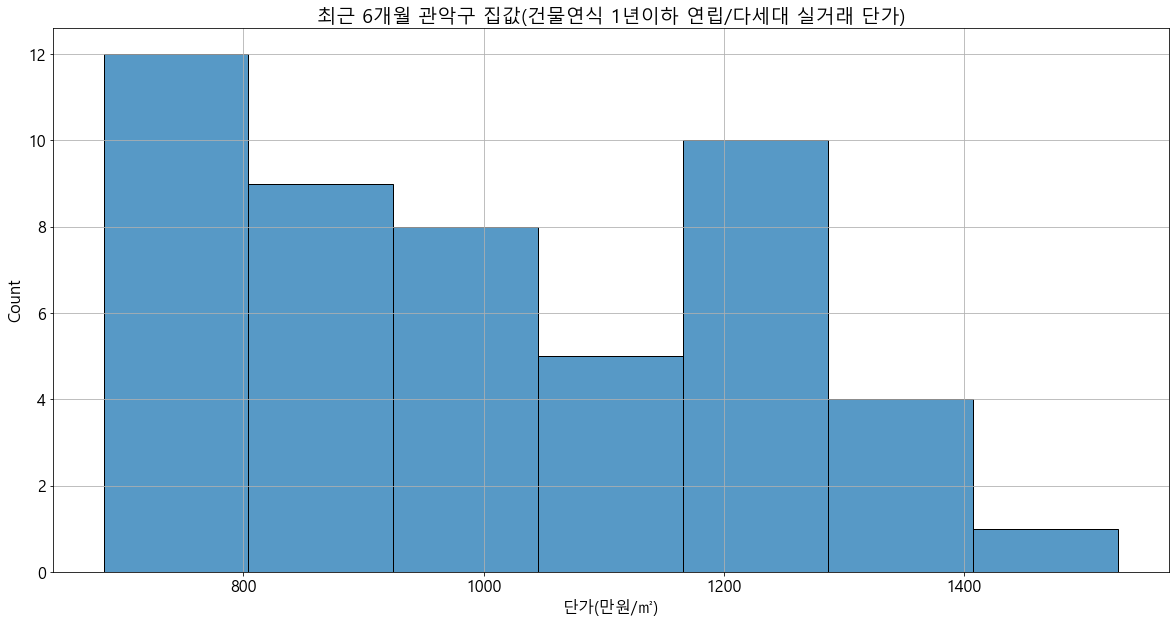

count      49.000000
mean      992.140393
std       226.707444
min       683.428957
25%       851.442822
50%       968.603874
75%      1187.713311
max      1528.532609
Name: 단가(만원/㎡), dtype: float64
count     317.000000
mean      753.371314
std       398.133046
min        27.253669
25%       520.446097
50%       689.013035
75%       892.857143
max      3415.559772
Name: 단가(만원/㎡), dtype: float64
광진구
제2종일반주거지역    0.609132
제3종일반주거지역    0.149905
제1종일반주거지역    0.143574
준주거지역        0.054354
자연녹지지역       0.018293
일반상업지역       0.018293
개발제한구역       0.005602
제1종전용주거지역    0.000846
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

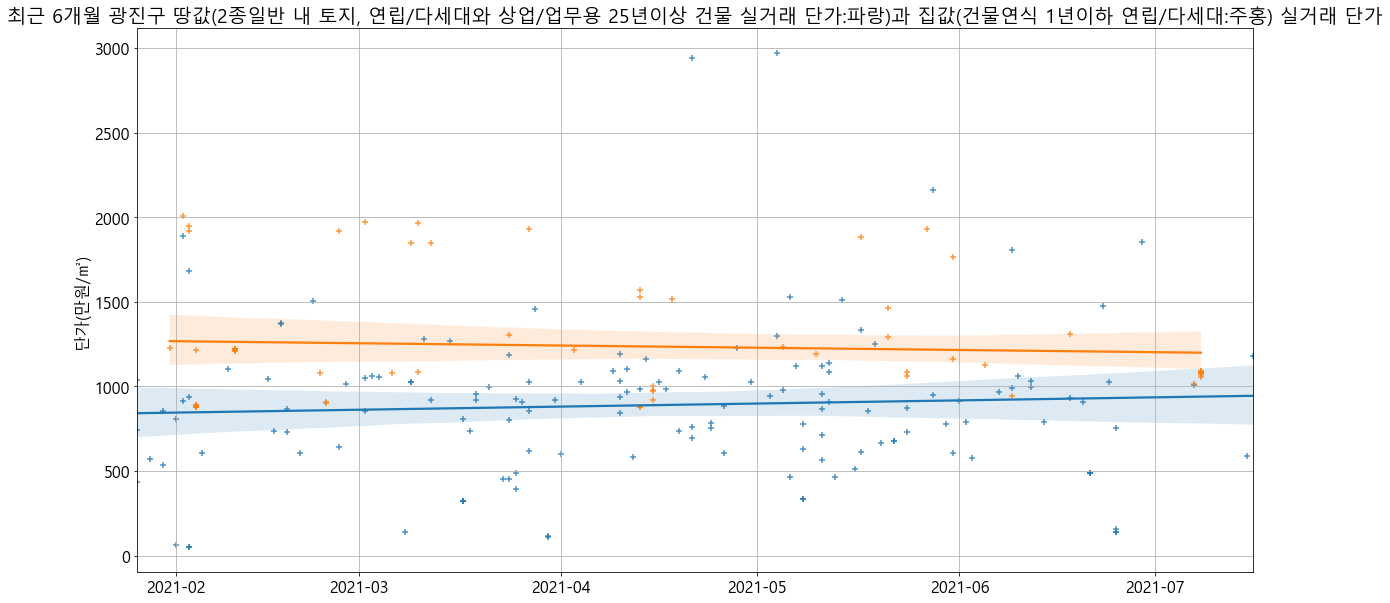

<Figure size 432x288 with 0 Axes>

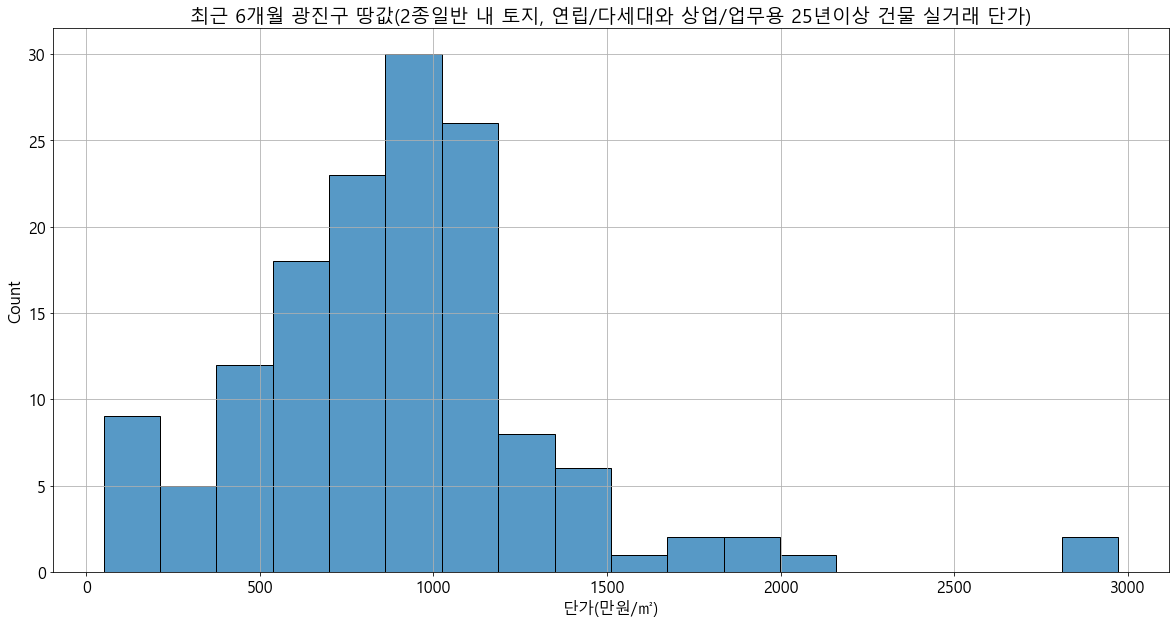

<Figure size 432x288 with 0 Axes>

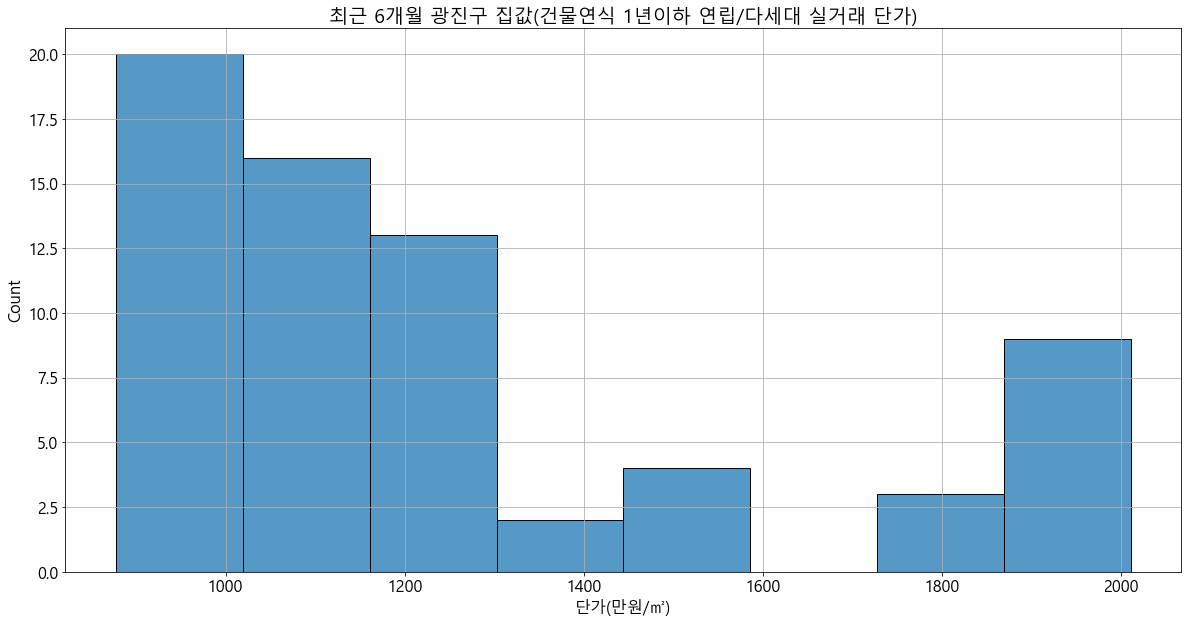

count      67.000000
mean     1239.214134
std       357.232865
min       877.785280
25%       976.377953
50%      1089.174070
75%      1307.380418
max      2010.619469
Name: 단가(만원/㎡), dtype: float64
count     145.000000
mean      889.839908
std       447.692583
min        50.280000
25%       609.756098
50%       910.746812
75%      1047.835991
max      2972.399151
Name: 단가(만원/㎡), dtype: float64
구로구
제2종일반주거지역    0.557169
제3종일반주거지역    0.168579
준공업지역        0.116077
제1종일반주거지역    0.041483
준주거지역        0.037845
개발제한구역       0.033780
일반상업지역       0.025703
자연녹지지역       0.019230
생산녹지지역       0.000134
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

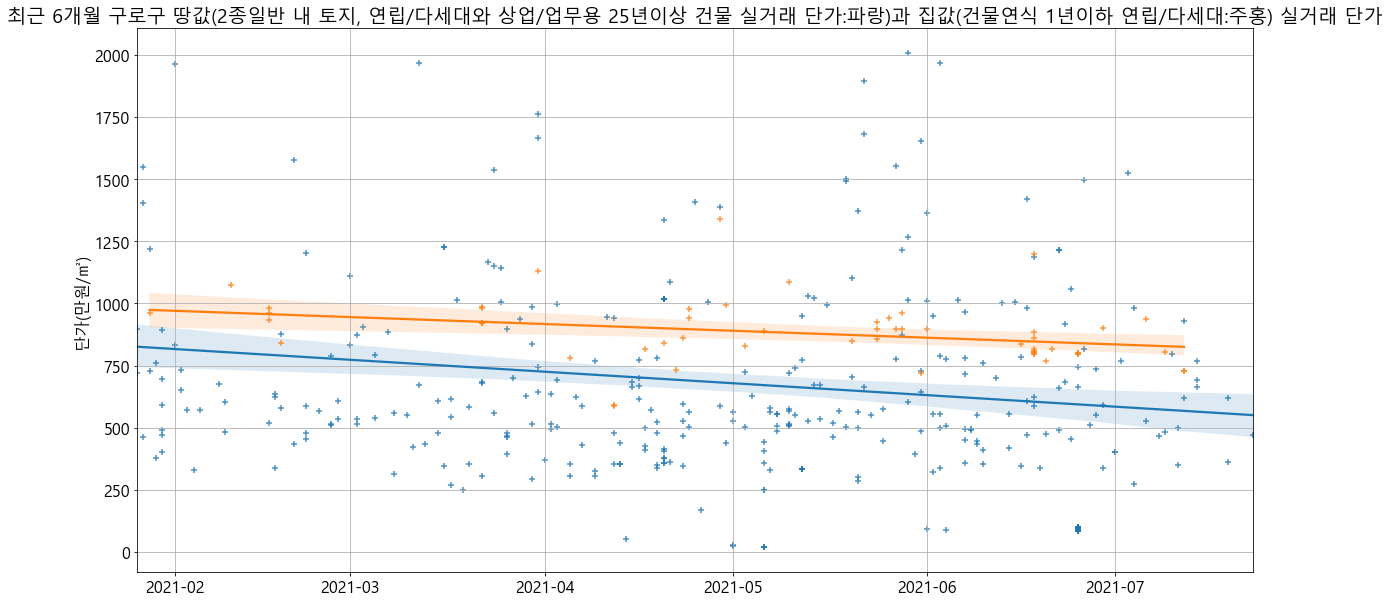

<Figure size 432x288 with 0 Axes>

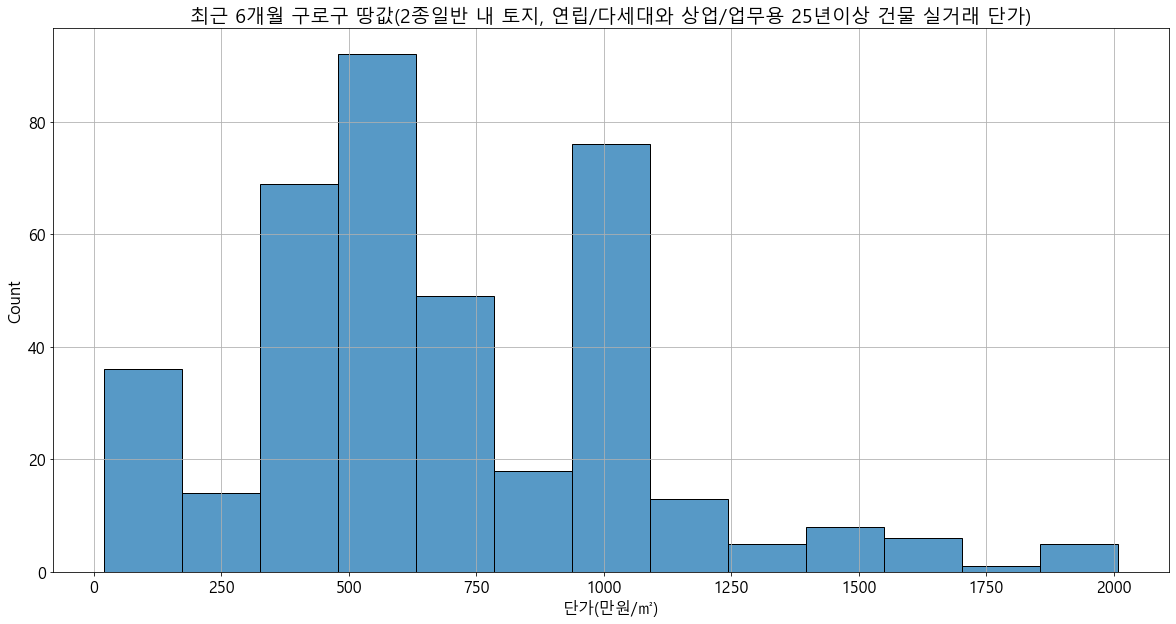

<Figure size 432x288 with 0 Axes>

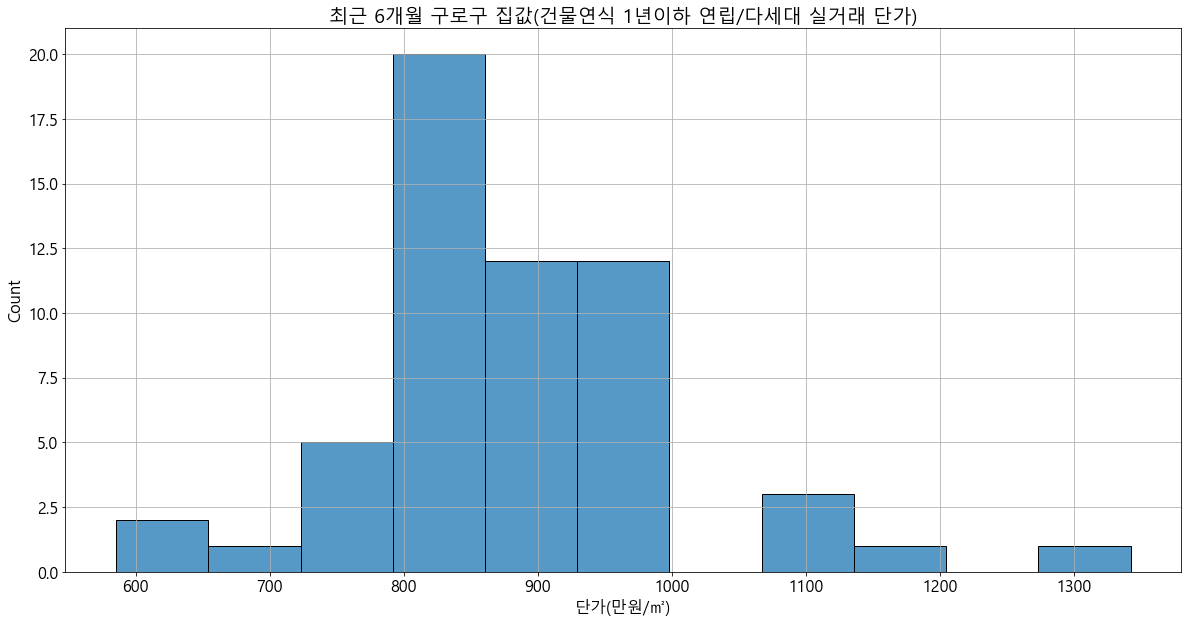

count      57.000000
mean      880.938522
std       128.490374
min       585.267407
25%       803.418803
50%       860.573716
75%       942.443622
max      1342.113515
Name: 단가(만원/㎡), dtype: float64
count     392.000000
mean      681.371380
std       380.997392
min        19.066667
25%       434.995599
50%       593.736810
75%      1010.759416
max      2008.928571
Name: 단가(만원/㎡), dtype: float64
금천구
제2종일반주거지역    0.606128
준공업지역        0.167313
제1종일반주거지역    0.107195
준주거지역        0.042713
제3종일반주거지역    0.032338
일반상업지역       0.015563
개발제한구역       0.013818
자연녹지지역       0.009793
근린상업지역       0.005139
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

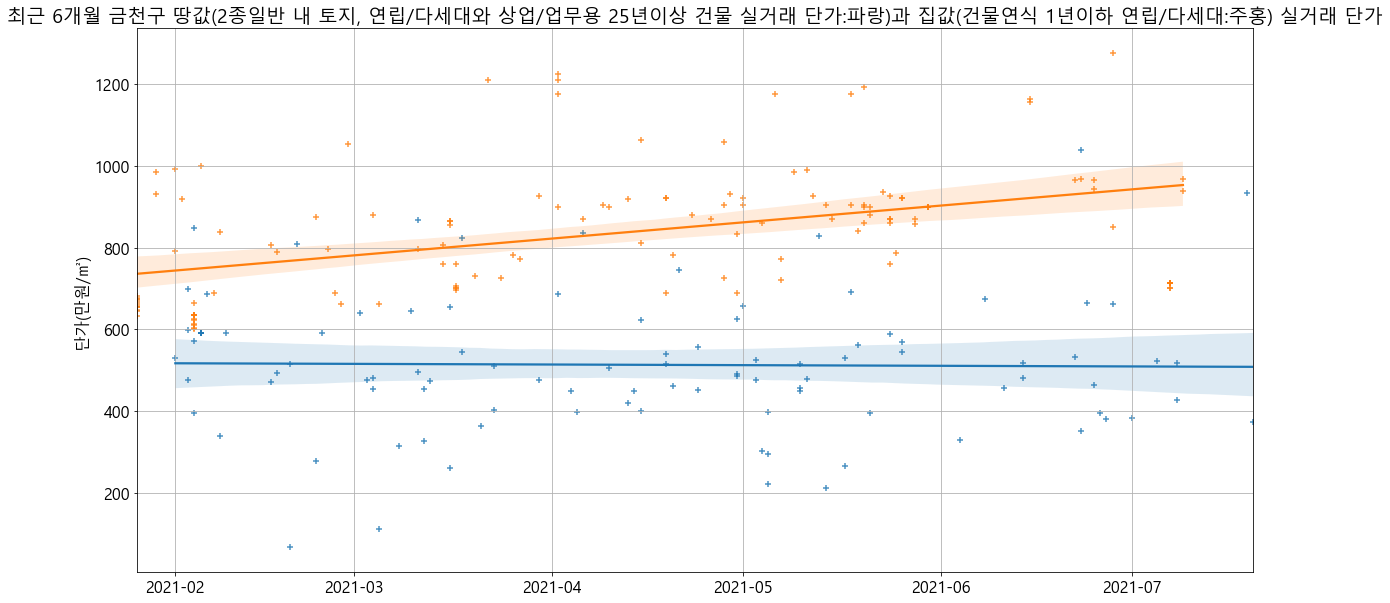

<Figure size 432x288 with 0 Axes>

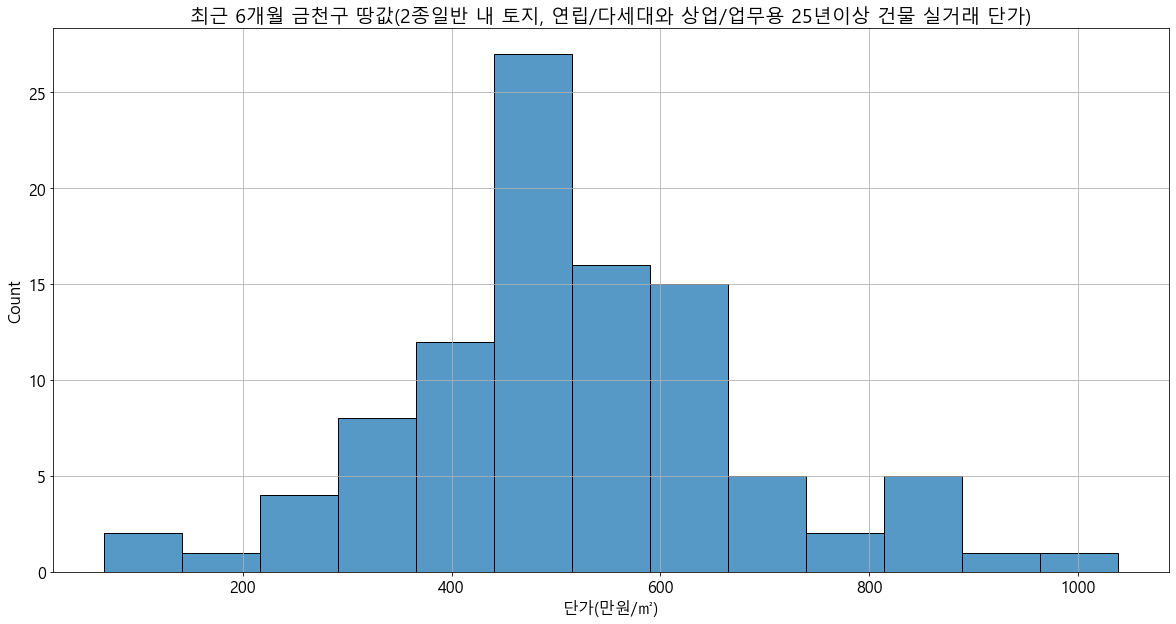

<Figure size 432x288 with 0 Axes>

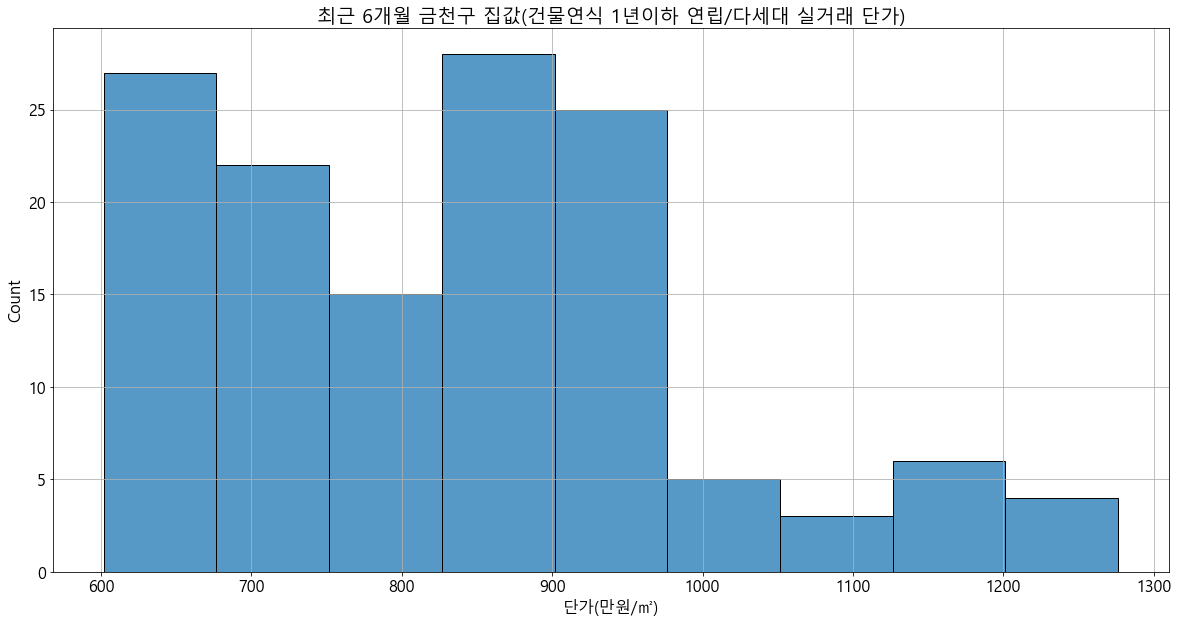

count     135.000000
mean      831.569540
std       157.144601
min       601.785714
25%       697.613059
50%       850.567045
75%       921.581769
max      1276.448144
Name: 단가(만원/㎡), dtype: float64
count      99.000000
mean      512.917608
std       165.907486
min        66.666667
25%       410.254435
50%       495.867769
75%       590.909091
max      1038.618374
Name: 단가(만원/㎡), dtype: float64
노원구
제2종일반주거지역    0.522110
제3종일반주거지역    0.196204
자연녹지지역       0.107321
개발제한구역       0.062756
제1종일반주거지역    0.053537
준주거지역        0.039734
일반상업지역       0.014740
제1종전용주거지역    0.003402
제2종전용주거지역    0.000197
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

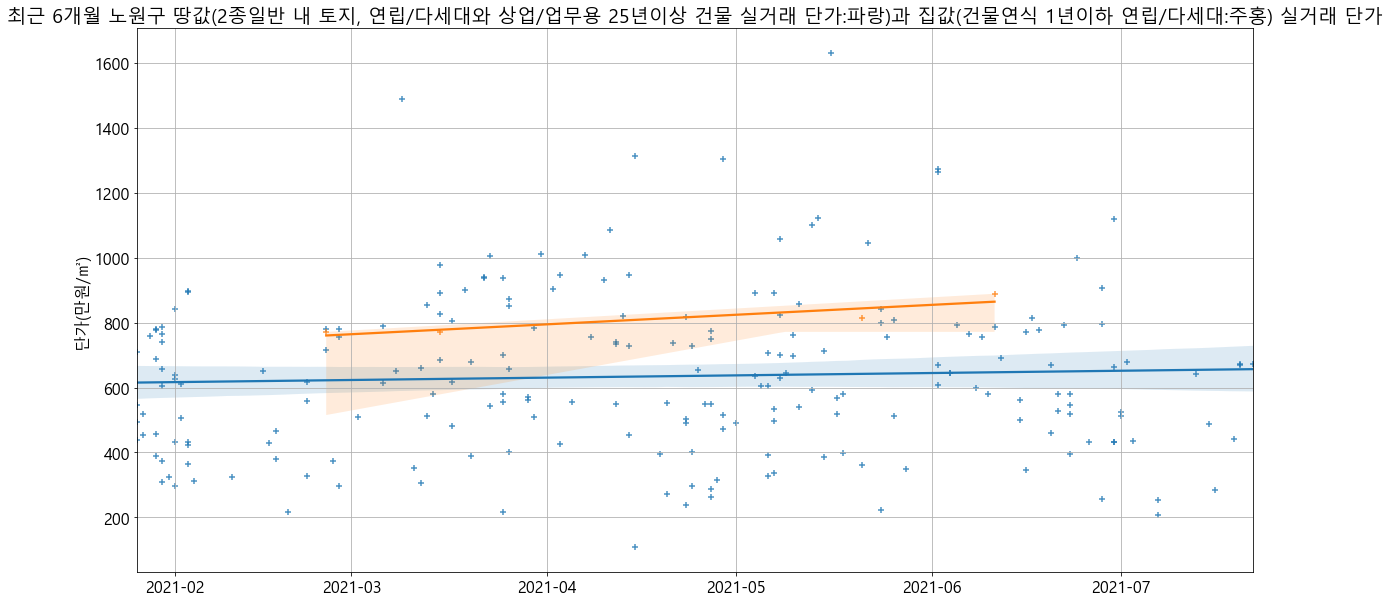

<Figure size 432x288 with 0 Axes>

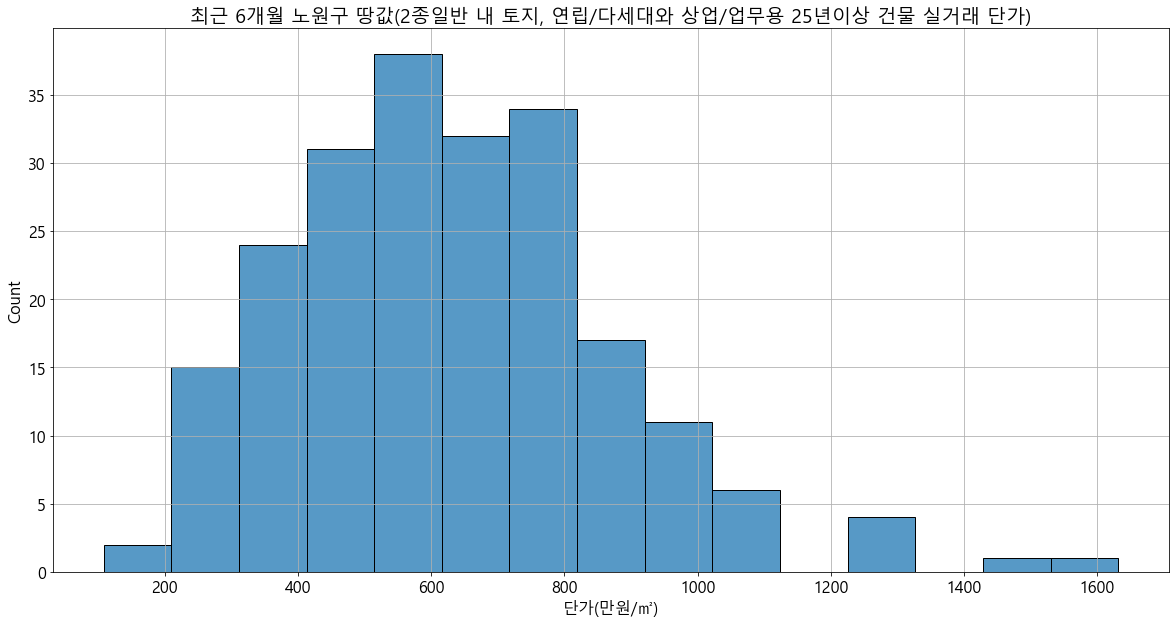

<Figure size 432x288 with 0 Axes>

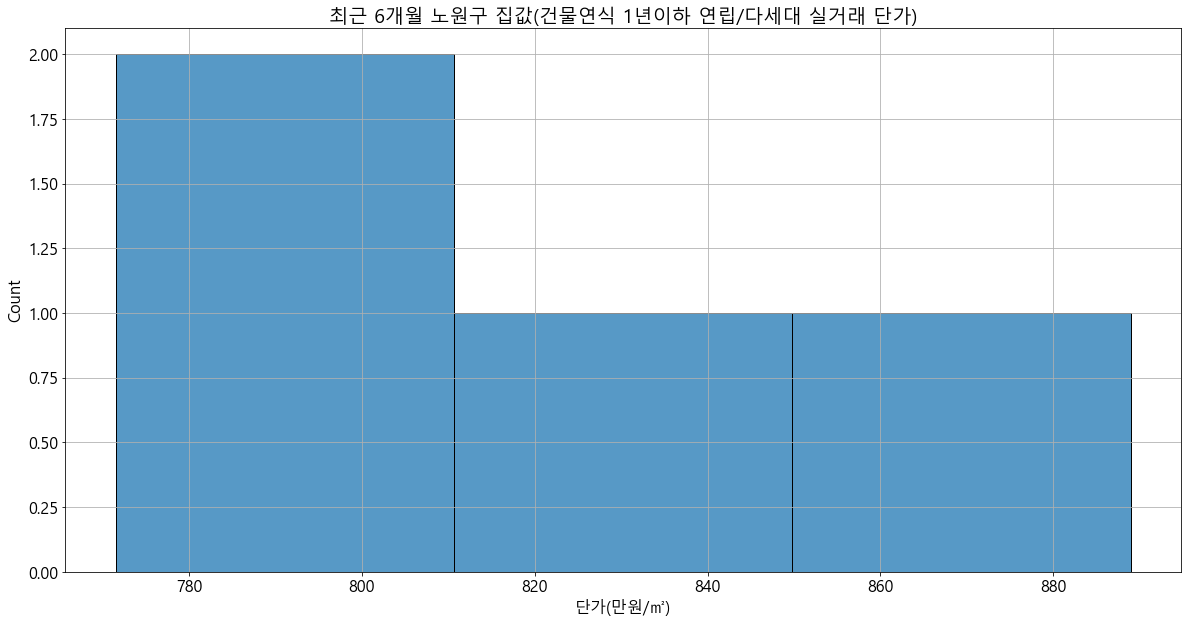

count      4.000000
mean     811.752588
std       55.388520
min      771.553170
25%      771.553170
50%      793.246874
75%      833.446292
max      888.963435
Name: 단가(만원/㎡), dtype: float64
count     216.000000
mean      634.215612
std       245.591029
min       108.333333
25%       455.454016
50%       614.162296
75%       781.059327
max      1631.205674
Name: 단가(만원/㎡), dtype: float64
도봉구
제2종일반주거지역    0.513204
제1종일반주거지역    0.136261
제3종일반주거지역    0.099616
준공업지역        0.098780
개발제한구역       0.070784
준주거지역        0.036520
자연녹지지역       0.030085
일반상업지역       0.013705
근린상업지역       0.001045
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

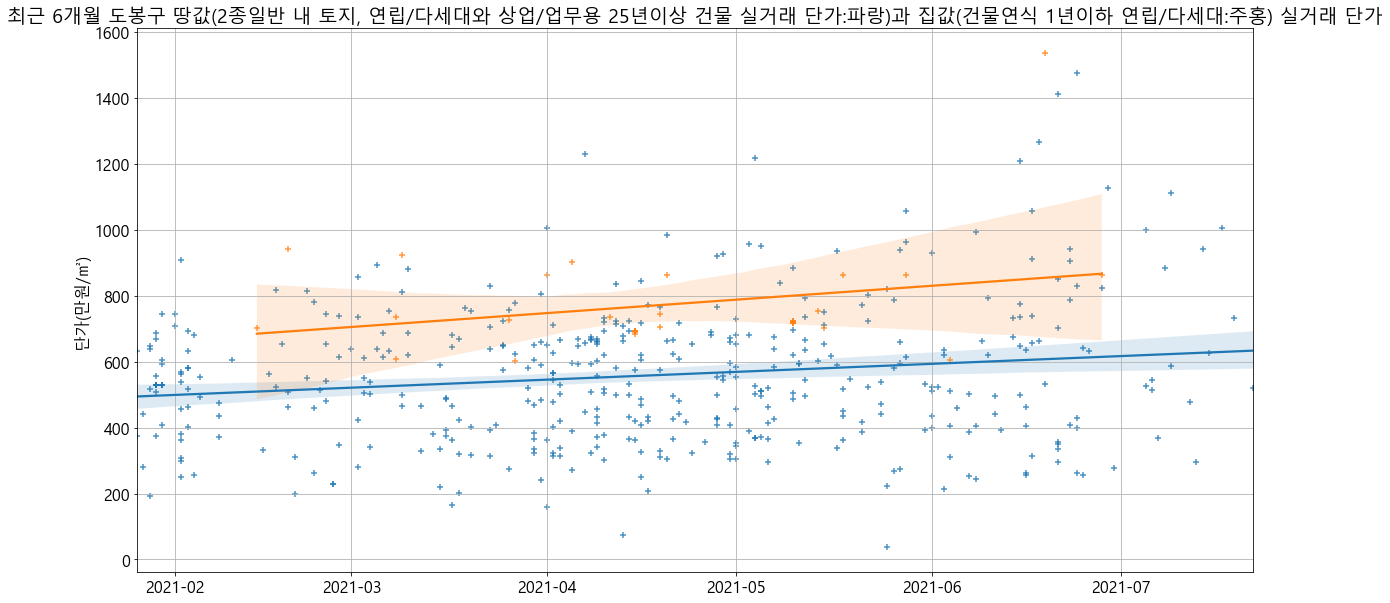

<Figure size 432x288 with 0 Axes>

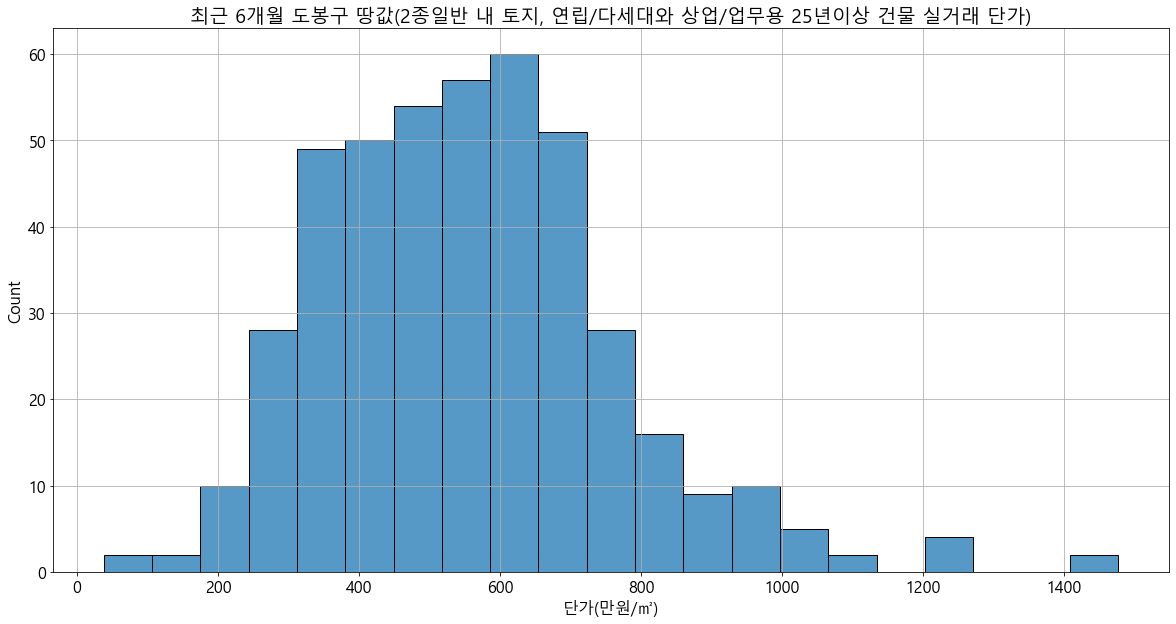

<Figure size 432x288 with 0 Axes>

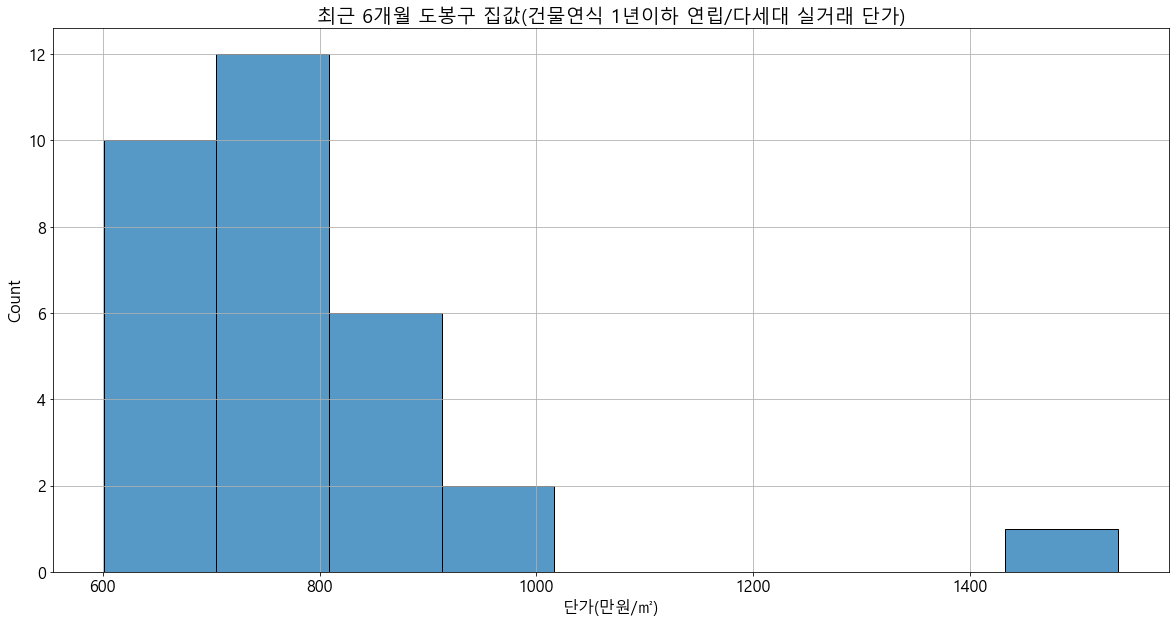

count      31.000000
mean      774.902884
std       168.113366
min       600.694444
25%       698.747103
50%       723.860590
75%       863.236290
max      1536.849459
Name: 단가(만원/㎡), dtype: float64
count     439.000000
mean      557.381899
std       207.298696
min        37.634409
25%       406.137992
50%       537.249284
75%       668.247095
max      1476.503597
Name: 단가(만원/㎡), dtype: float64
동대문구
제2종일반주거지역    0.658510
제3종일반주거지역    0.187740
준주거지역        0.052489
일반상업지역       0.047833
제1종일반주거지역    0.043427
근린상업지역       0.006410
자연녹지지역       0.003445
유통상업지역       0.000146
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

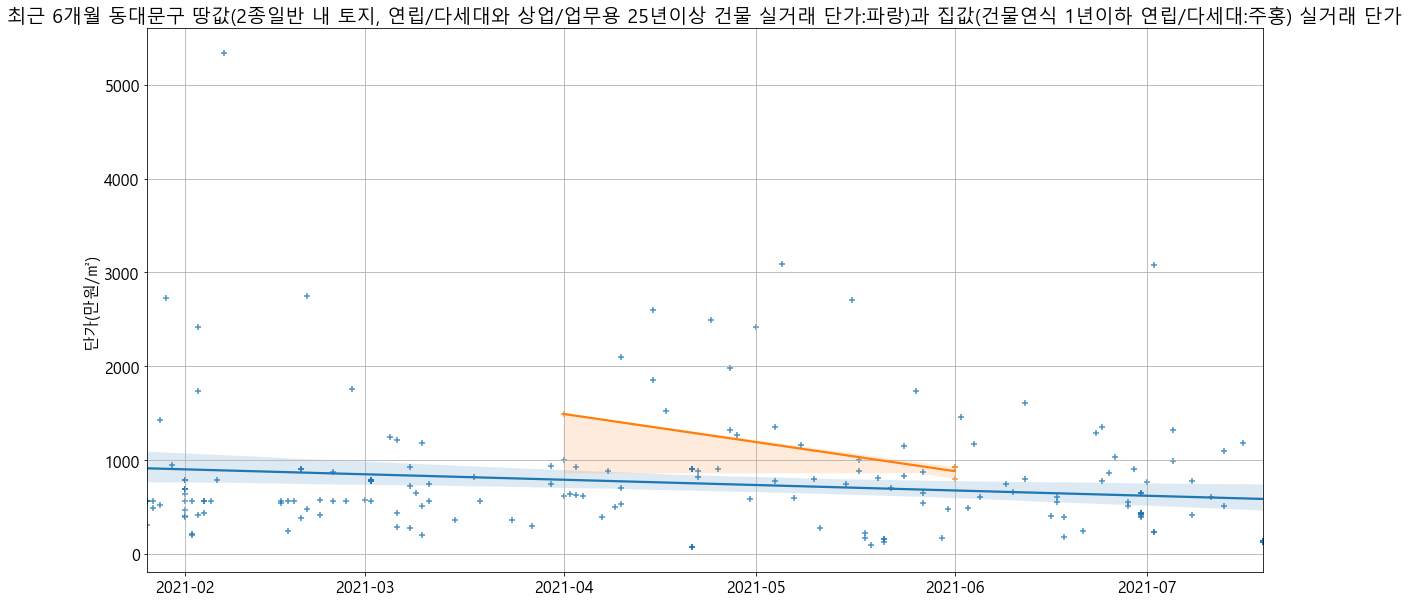

<Figure size 432x288 with 0 Axes>

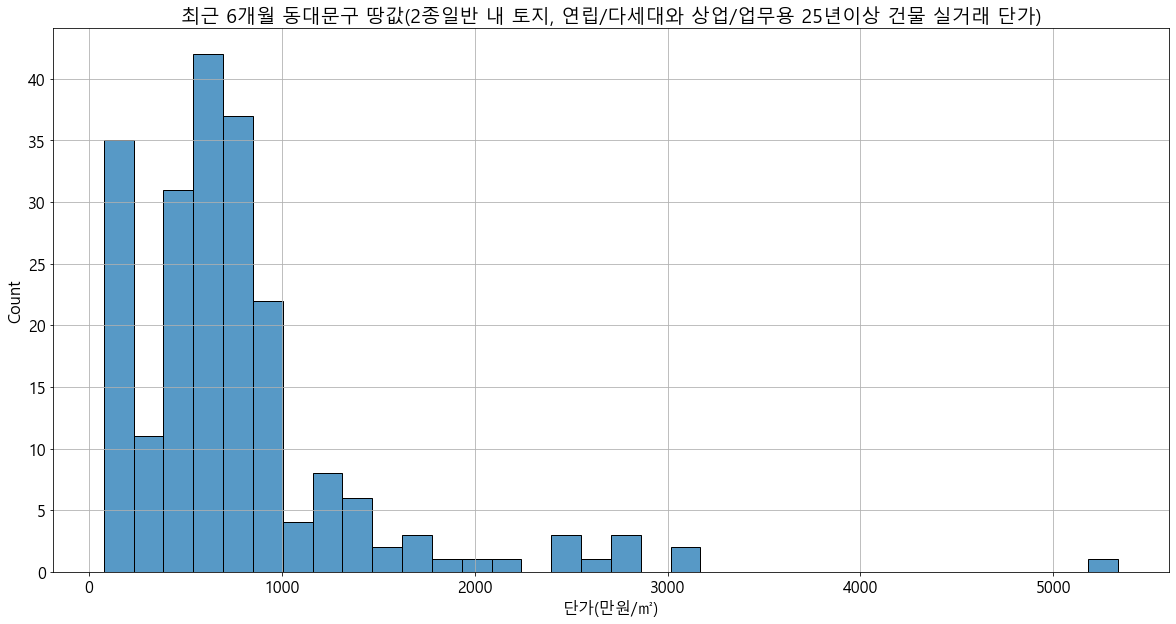

<Figure size 432x288 with 0 Axes>

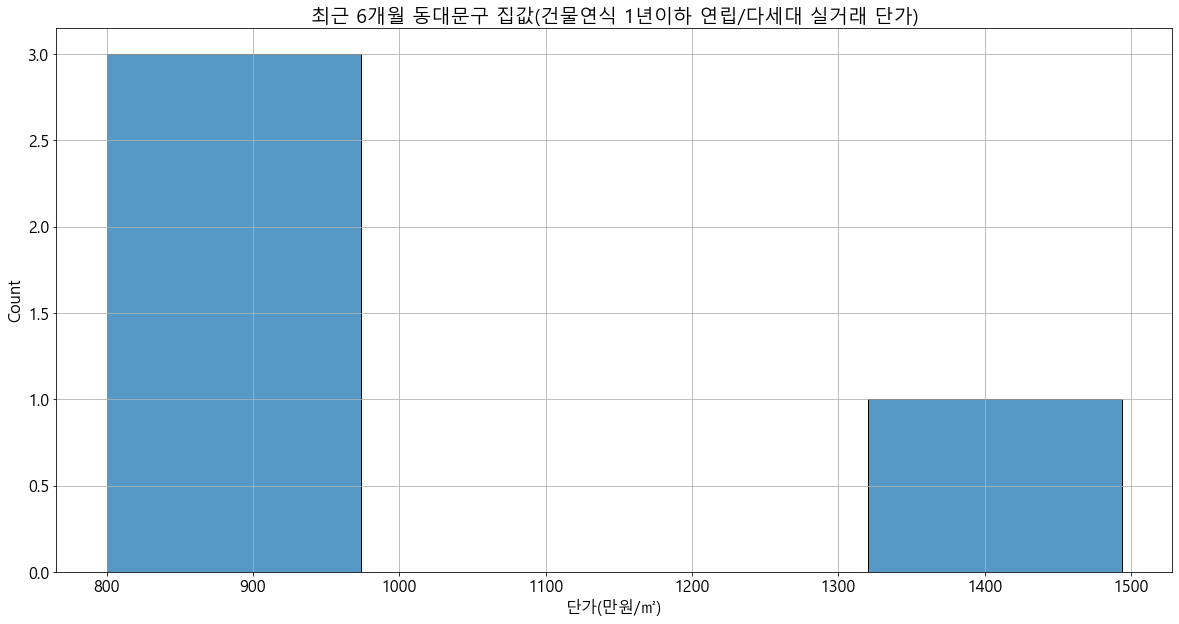

count       4.000000
mean     1036.998577
std       310.210244
min       800.415800
25%       895.335694
50%       926.975659
75%      1068.638542
max      1493.627191
Name: 단가(만원/㎡), dtype: float64
count     214.000000
mean      755.921992
std       646.877261
min        76.301616
25%       411.658305
50%       606.060606
75%       887.311679
max      5337.007874
Name: 단가(만원/㎡), dtype: float64
동작구
제2종일반주거지역    0.578469
제3종일반주거지역    0.227138
제1종일반주거지역    0.128928
일반상업지역       0.024311
준주거지역        0.020872
자연녹지지역       0.015948
근린상업지역       0.003581
유통상업지역       0.000754
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

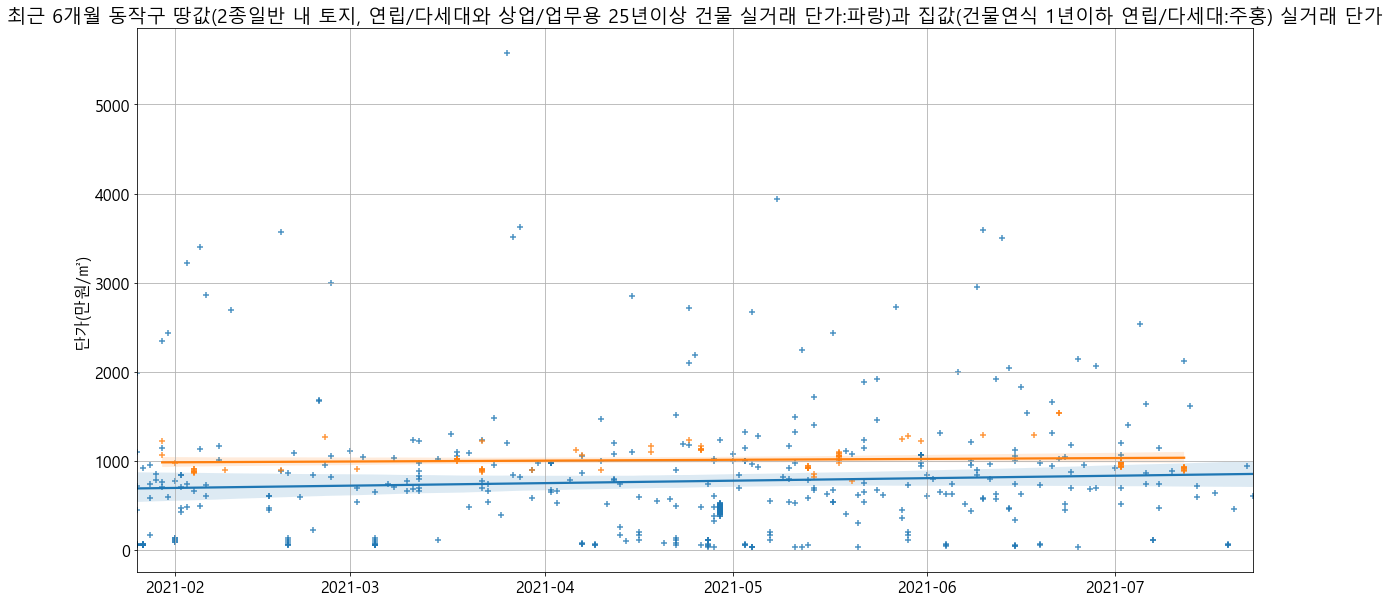

<Figure size 432x288 with 0 Axes>

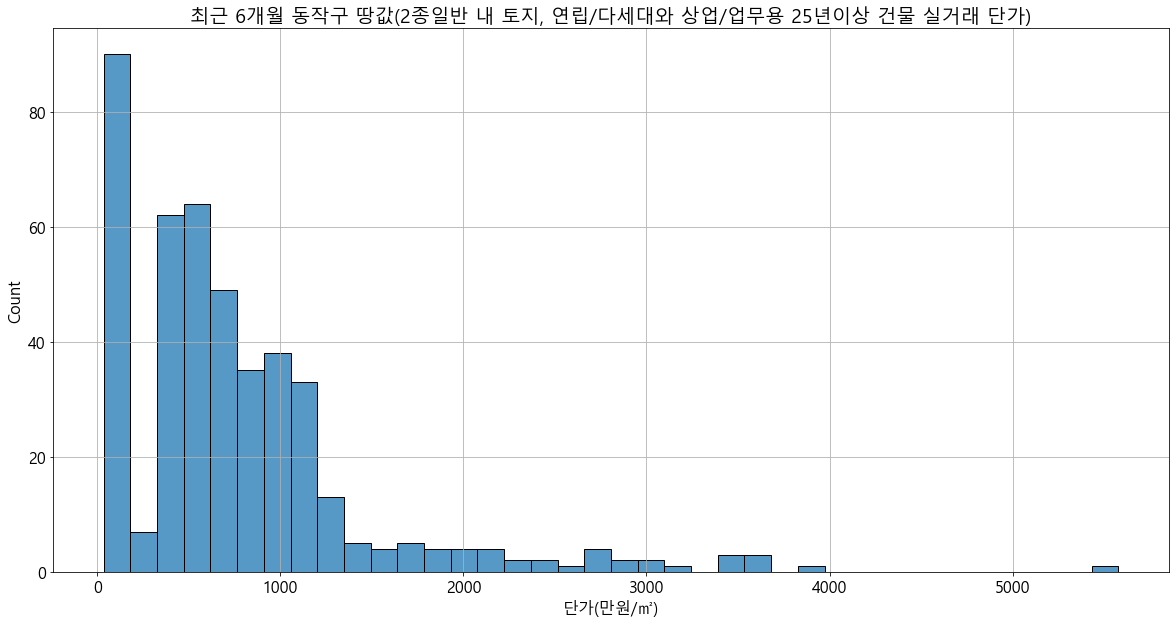

<Figure size 432x288 with 0 Axes>

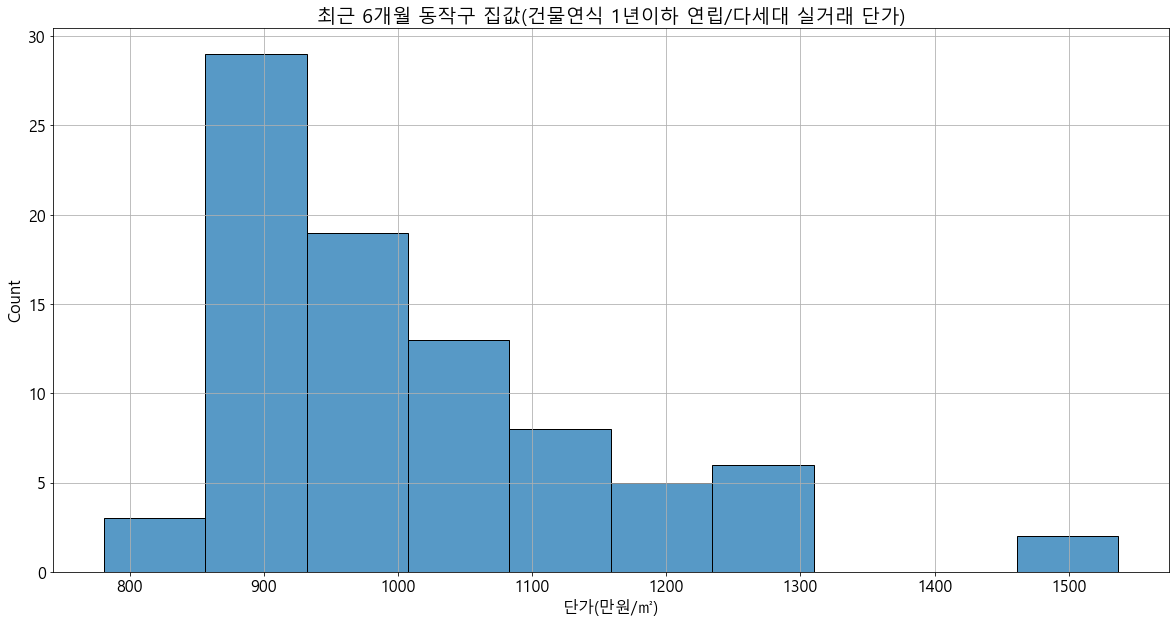

count      85.000000
mean     1013.996721
std       144.690959
min       780.454700
25%       915.404040
50%       973.807925
75%      1082.981716
max      1536.919479
Name: 단가(만원/㎡), dtype: float64
count     439.000000
mean      770.080345
std       715.742997
min        34.822104
25%       424.506311
50%       606.060606
75%       980.525583
max      5576.916181
Name: 단가(만원/㎡), dtype: float64
마포구
제2종일반주거지역    0.679573
제3종일반주거지역    0.175468
준주거지역        0.053293
자연녹지지역       0.040928
일반상업지역       0.028319
제1종일반주거지역    0.014717
근린상업지역       0.005372
유통상업지역       0.001358
개발제한구역       0.000973
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

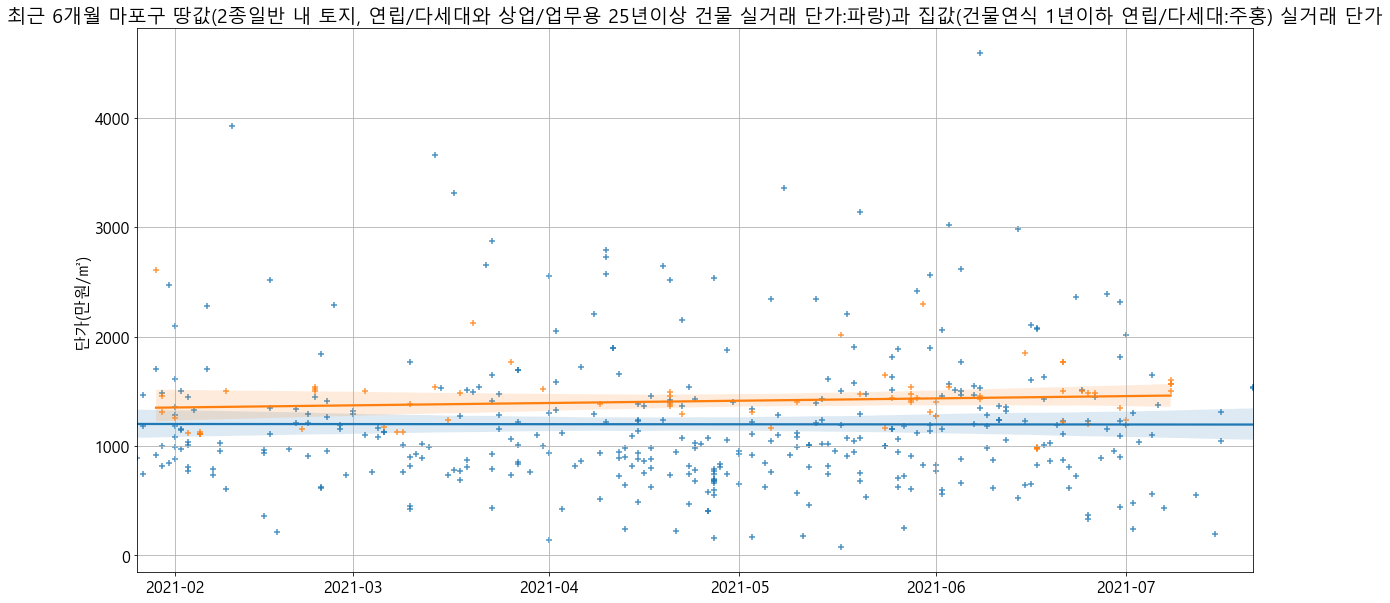

<Figure size 432x288 with 0 Axes>

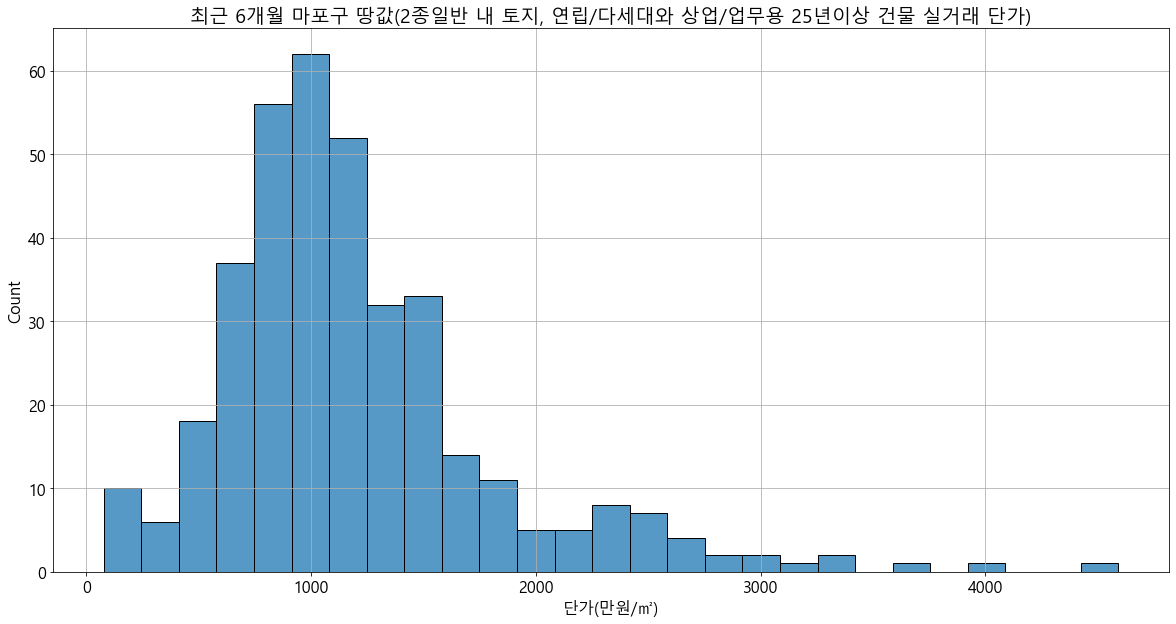

<Figure size 432x288 with 0 Axes>

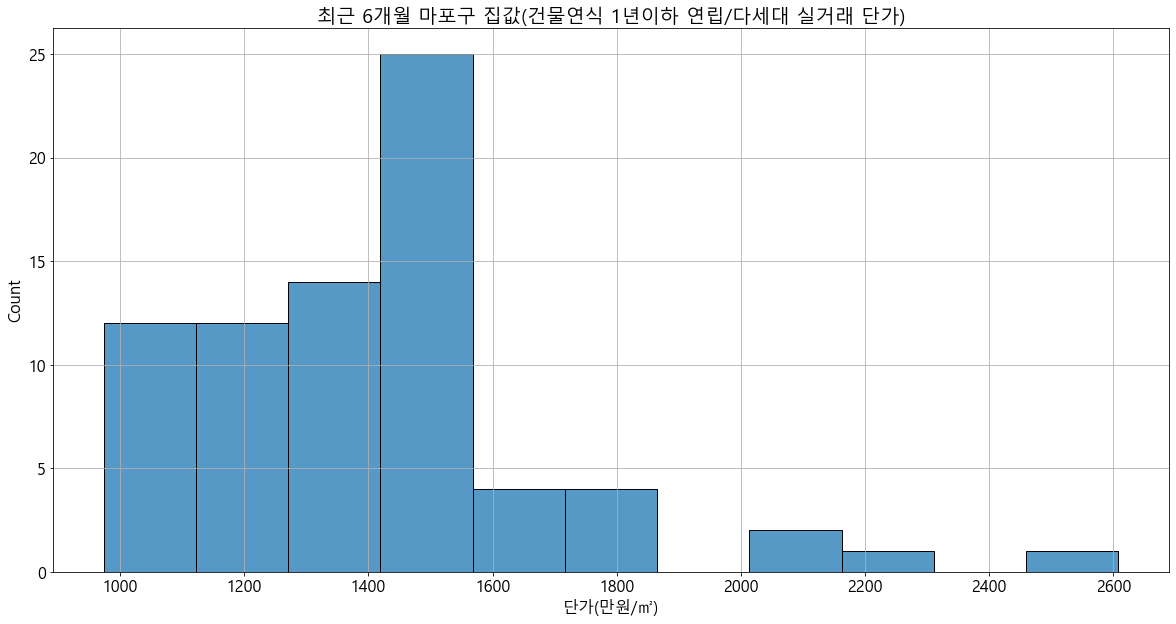

count      75.000000
mean     1409.325240
std       289.005942
min       973.613894
25%      1190.556680
50%      1405.152225
75%      1504.120879
max      2607.823470
Name: 단가(만원/㎡), dtype: float64
count     370.000000
mean     1198.982349
std       627.401588
min        76.731249
25%       812.364818
50%      1073.603142
75%      1432.762153
max      4591.836735
Name: 단가(만원/㎡), dtype: float64
서대문구
제2종일반주거지역    0.543558
제3종일반주거지역    0.198496
제1종일반주거지역    0.151040
준주거지역        0.046004
일반상업지역       0.026692
제1종전용주거지역    0.021083
개발제한구역       0.009249
자연녹지지역       0.003023
근린상업지역       0.000855
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

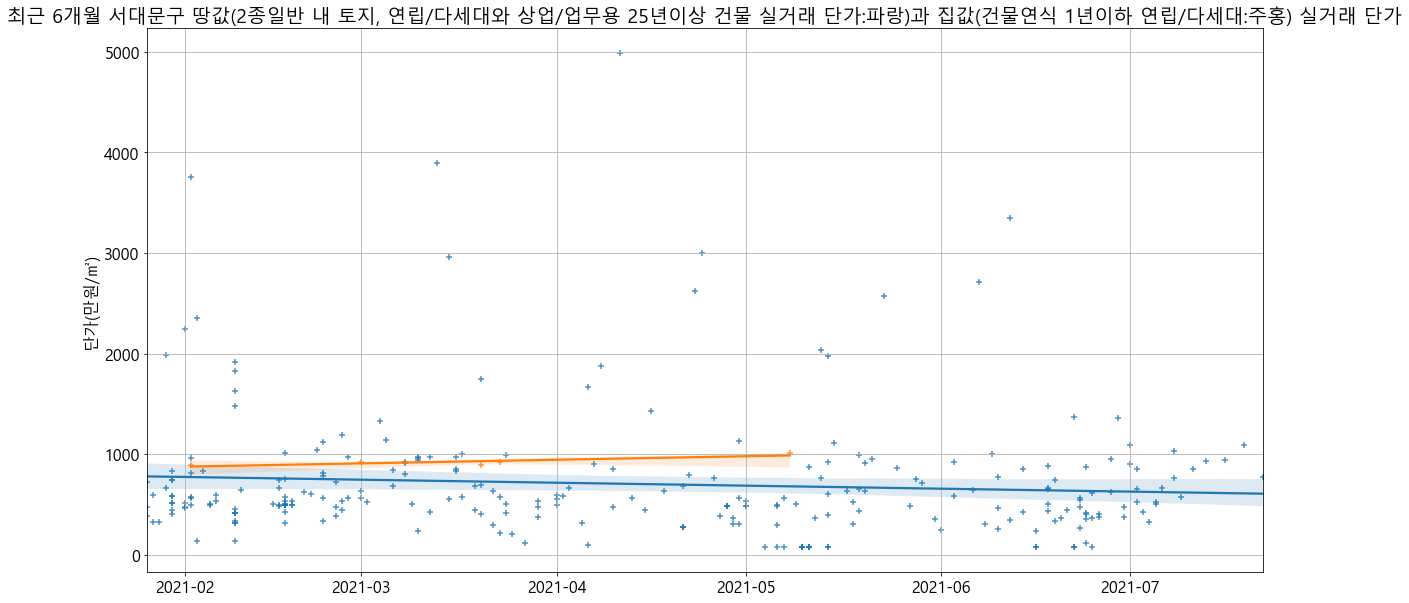

<Figure size 432x288 with 0 Axes>

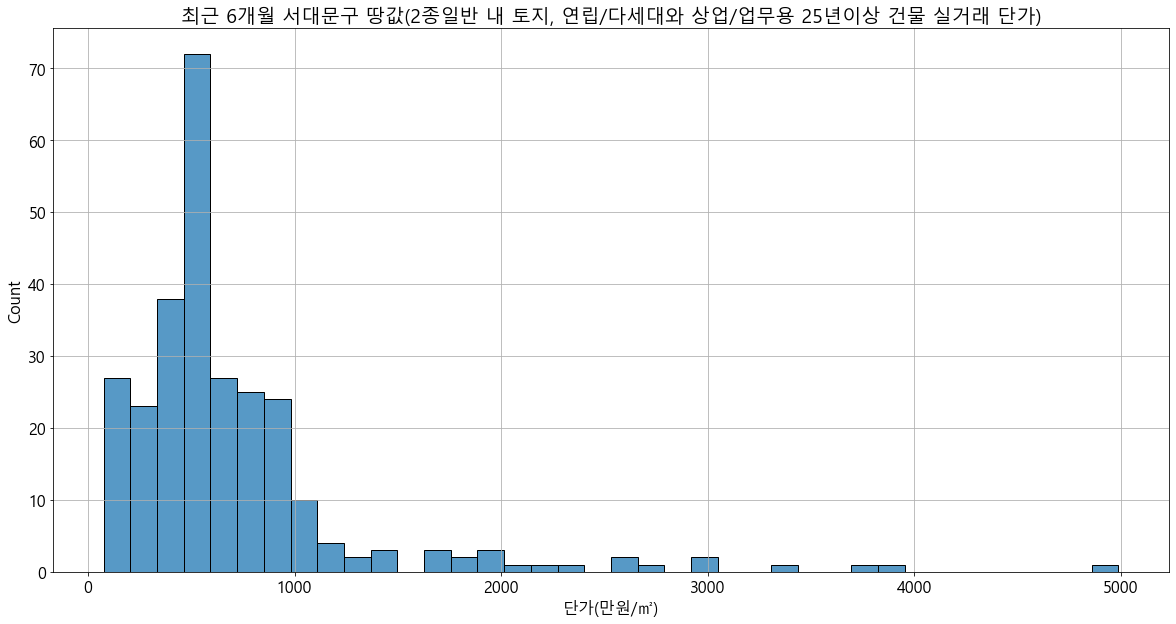

<Figure size 432x288 with 0 Axes>

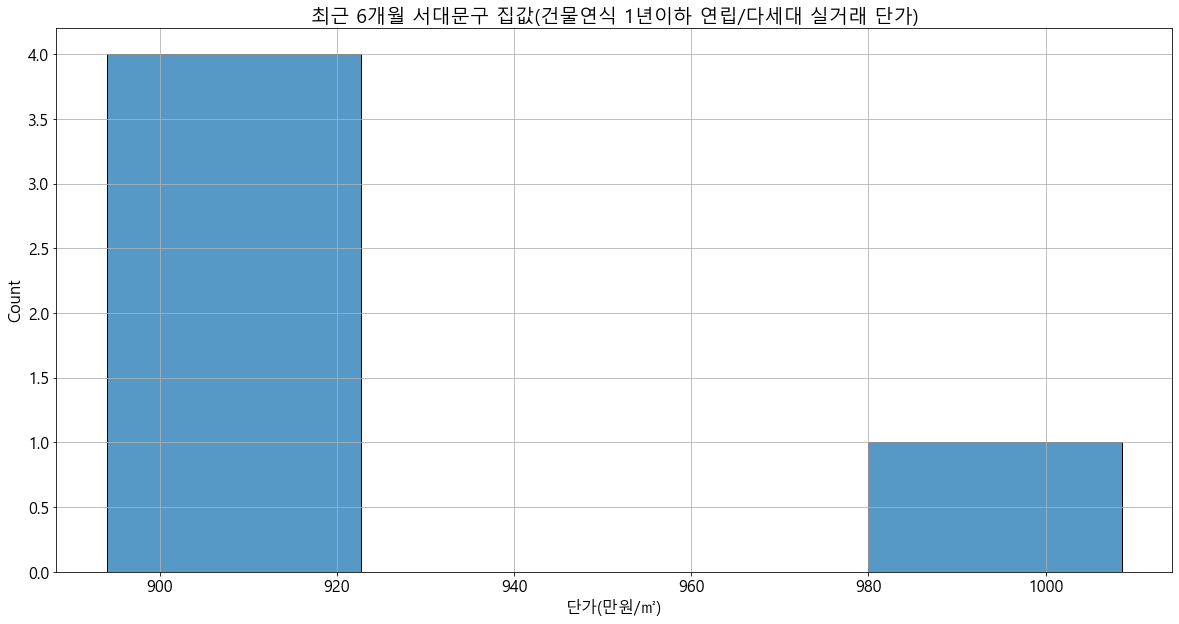

count       5.000000
mean      926.991467
std        47.308273
min       894.062078
25%       894.062078
50%       919.117647
75%       919.117647
max      1008.597884
Name: 단가(만원/㎡), dtype: float64
count     275.000000
mean      704.041450
std       633.226840
min        75.804878
25%       405.342015
50%       538.090909
75%       834.189747
max      4988.009592
Name: 단가(만원/㎡), dtype: float64
서초구
제2종일반주거지역    0.370525
개발제한구역       0.225410
제3종일반주거지역    0.182405
제1종일반주거지역    0.069611
제1종전용주거지역    0.061308
자연녹지지역       0.045296
일반상업지역       0.039731
준주거지역        0.005714
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

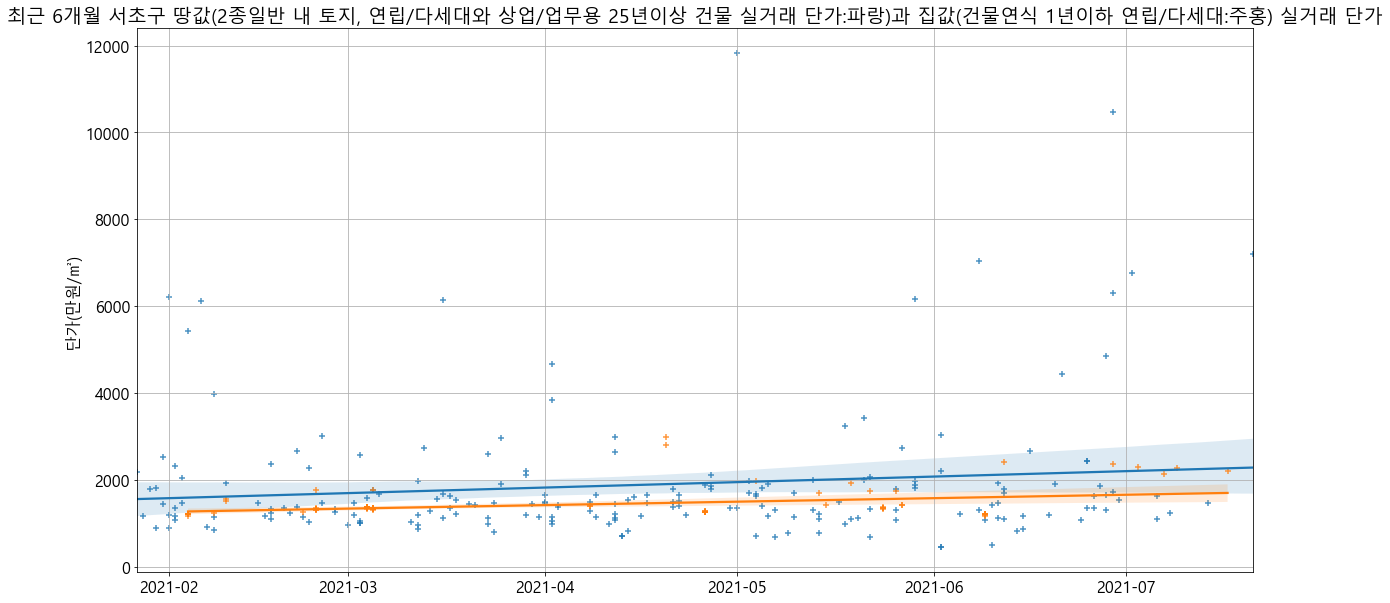

<Figure size 432x288 with 0 Axes>

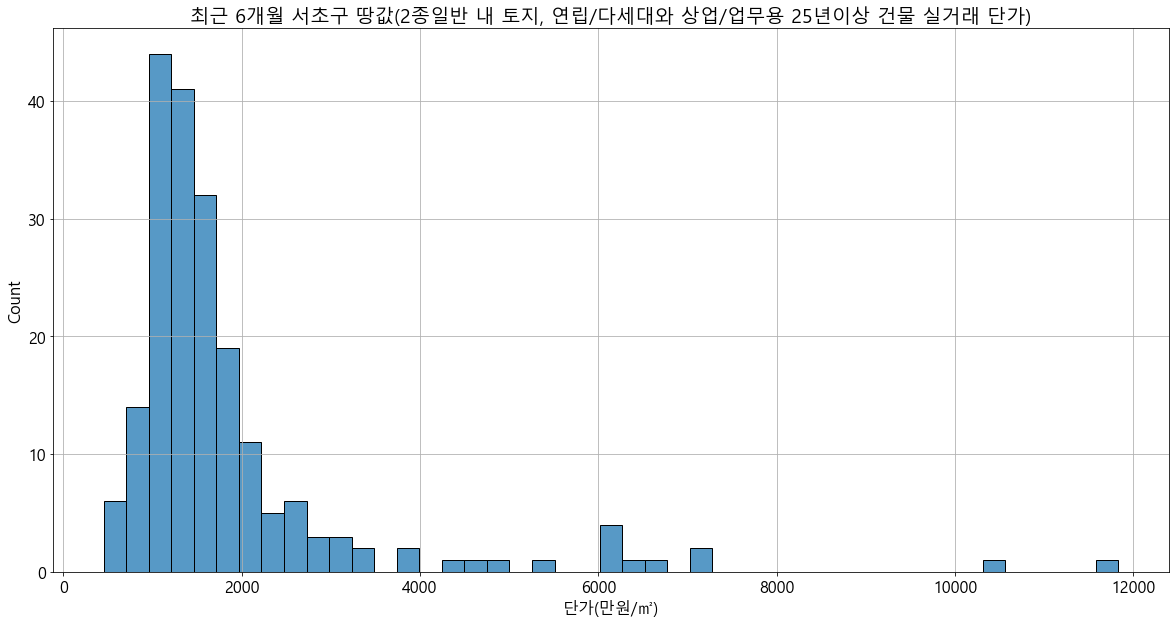

<Figure size 432x288 with 0 Axes>

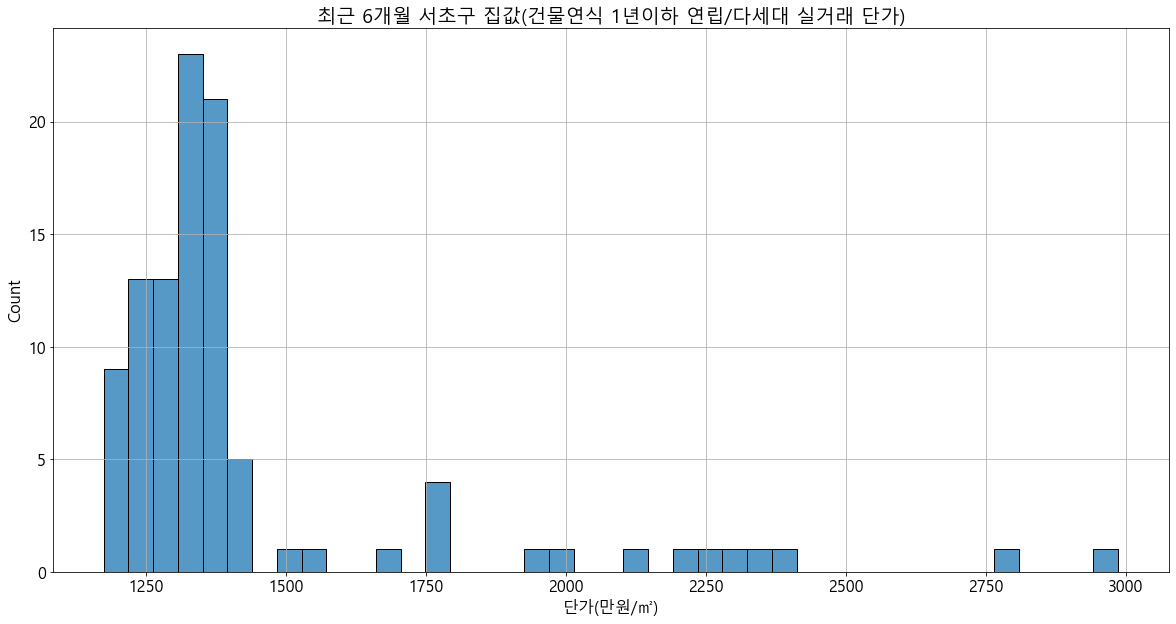

count     101.000000
mean     1434.912277
std       337.445857
min      1173.955936
25%      1263.978312
50%      1343.385881
75%      1368.312757
max      2986.611740
Name: 단가(만원/㎡), dtype: float64
count      202.000000
mean      1886.368799
std       1530.840340
min        453.710549
25%       1151.866548
50%       1455.561982
75%       1898.433935
max      11829.573935
Name: 단가(만원/㎡), dtype: float64
성동구
제2종일반주거지역    0.481518
제3종일반주거지역    0.282662
준공업지역        0.107325
제1종일반주거지역    0.041124
자연녹지지역       0.030765
준주거지역        0.027680
일반상업지역       0.026180
근린상업지역       0.002151
유통상업지역       0.000594
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

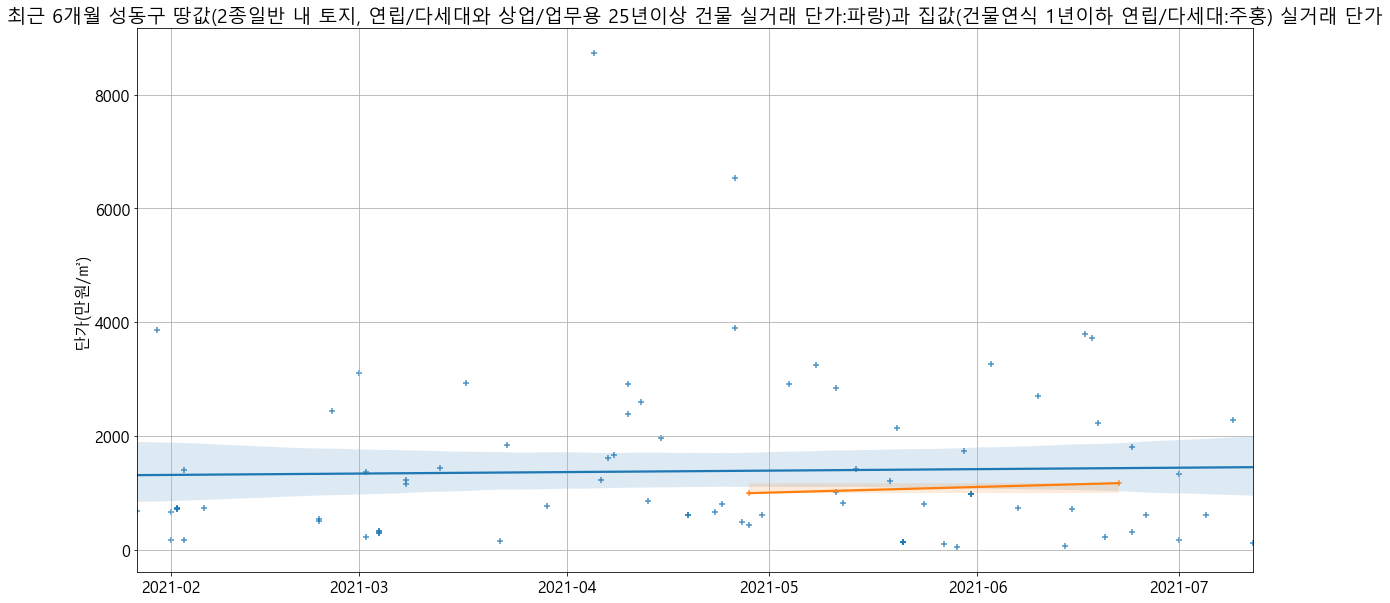

<Figure size 432x288 with 0 Axes>

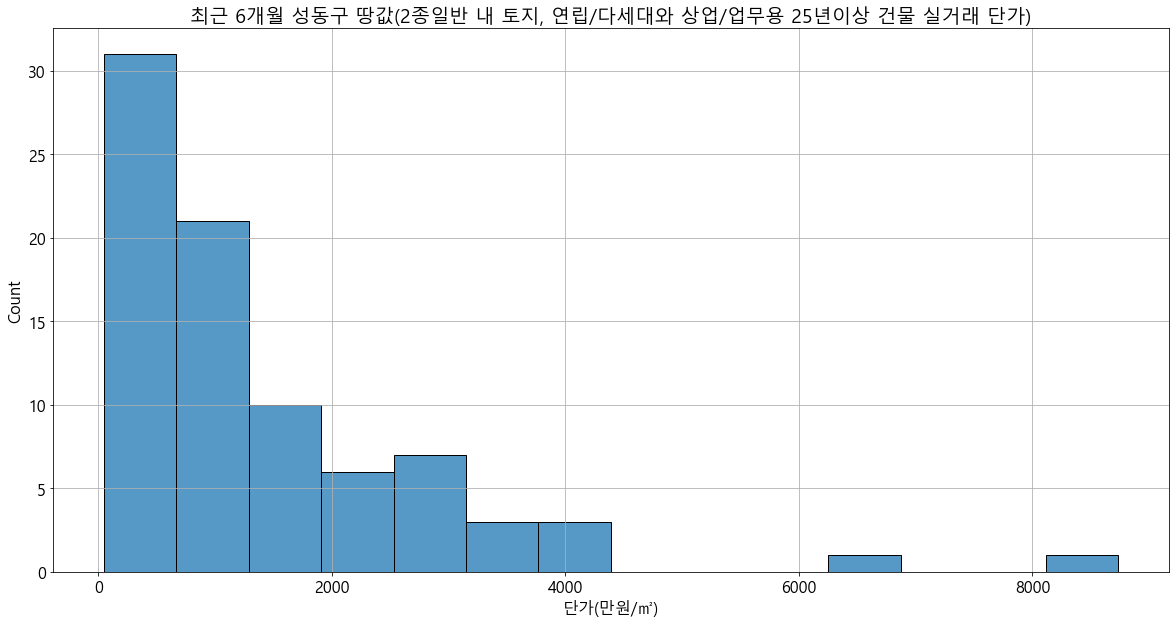

<Figure size 432x288 with 0 Axes>

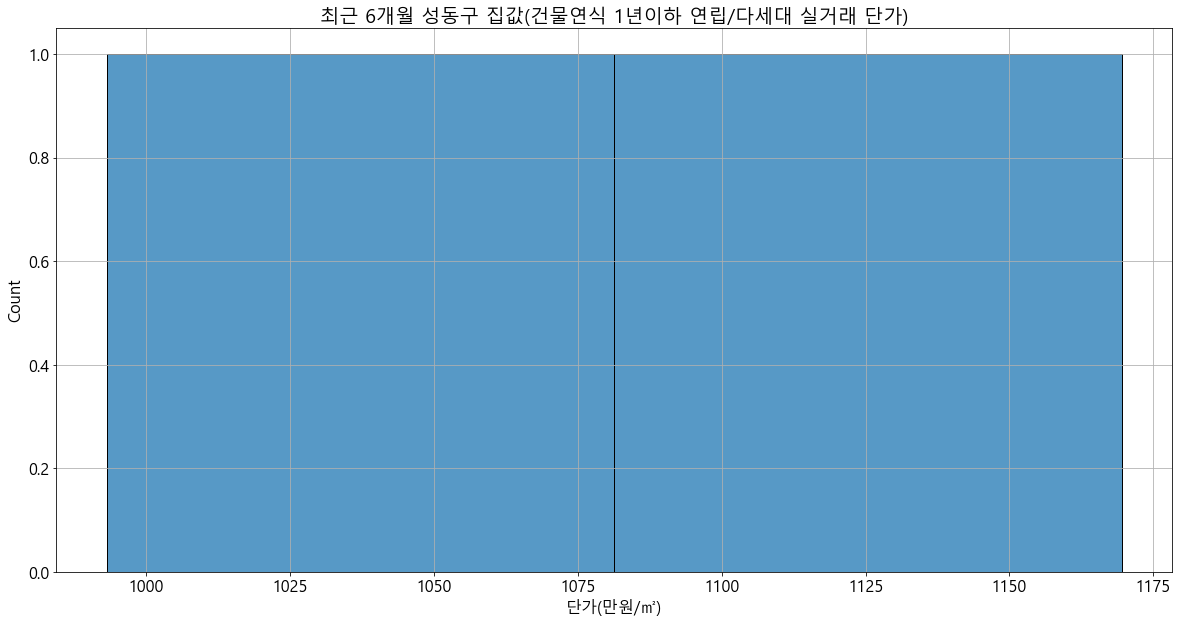

count       2.000000
mean     1081.364396
std       124.687133
min       993.197279
25%      1037.280838
50%      1081.364396
75%      1125.447955
max      1169.531513
Name: 단가(만원/㎡), dtype: float64
count      83.000000
mean     1380.342584
std      1457.406681
min        44.835329
25%       461.174242
50%       802.683322
75%      1907.284123
max      8734.522942
Name: 단가(만원/㎡), dtype: float64
성북구
제2종일반주거지역    0.598666
제3종일반주거지역    0.138970
제1종일반주거지역    0.128011
준주거지역        0.051691
제1종전용주거지역    0.034504
일반상업지역       0.026963
자연녹지지역       0.011124
개발제한구역       0.005356
근린상업지역       0.004716
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

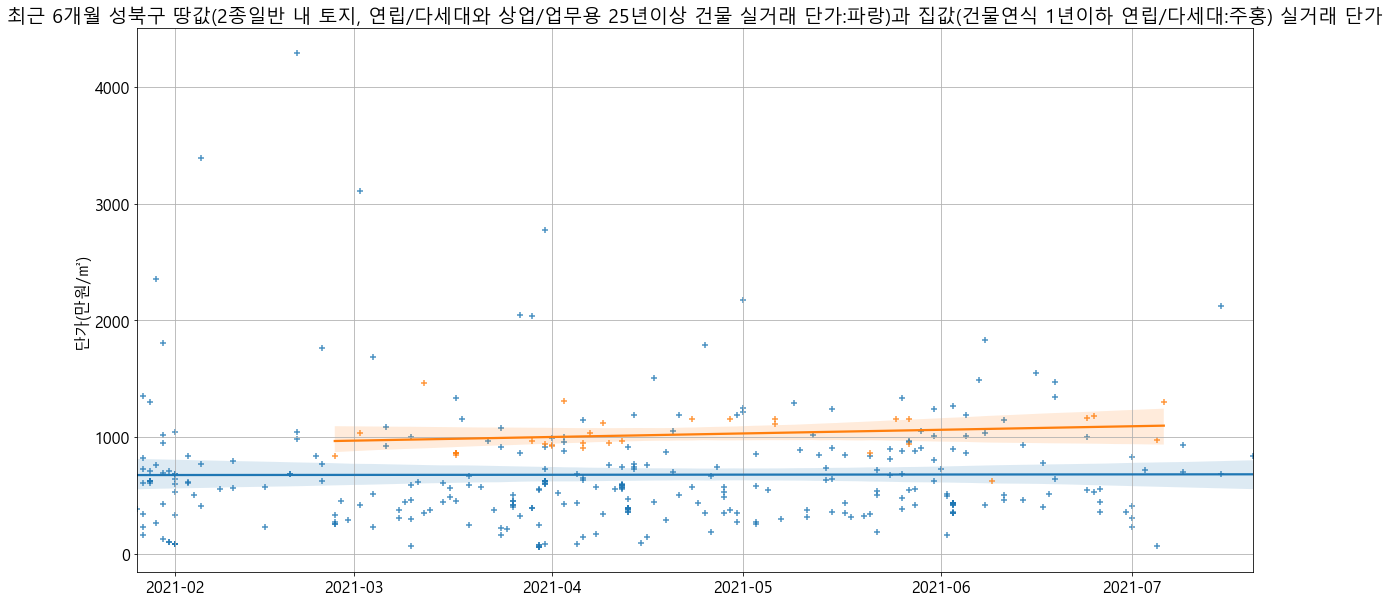

<Figure size 432x288 with 0 Axes>

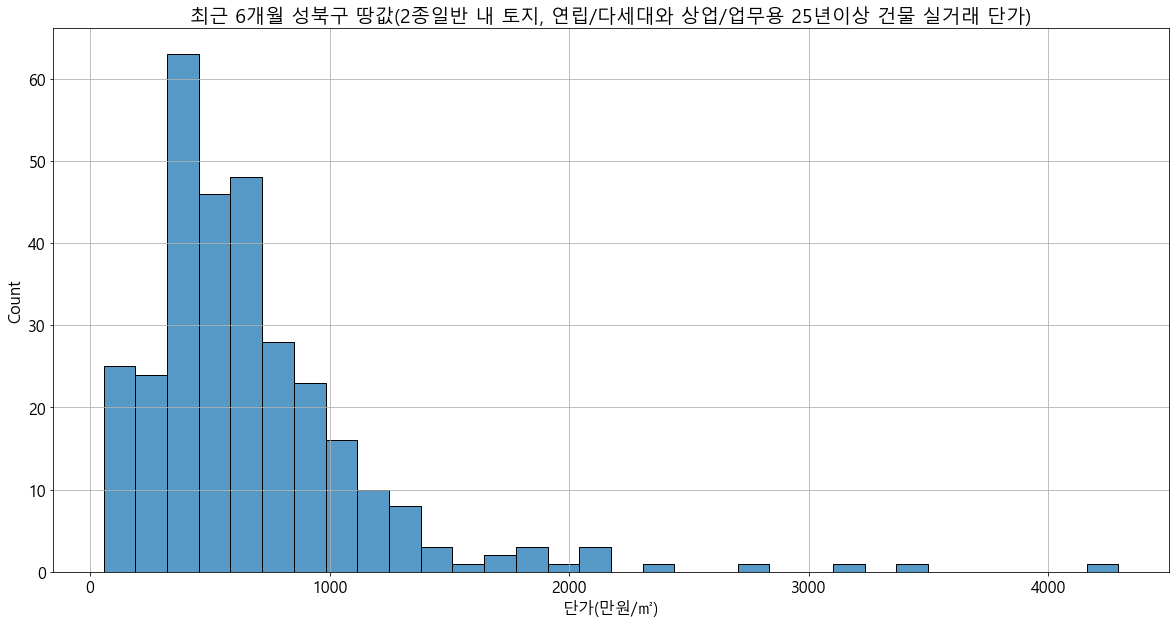

<Figure size 432x288 with 0 Axes>

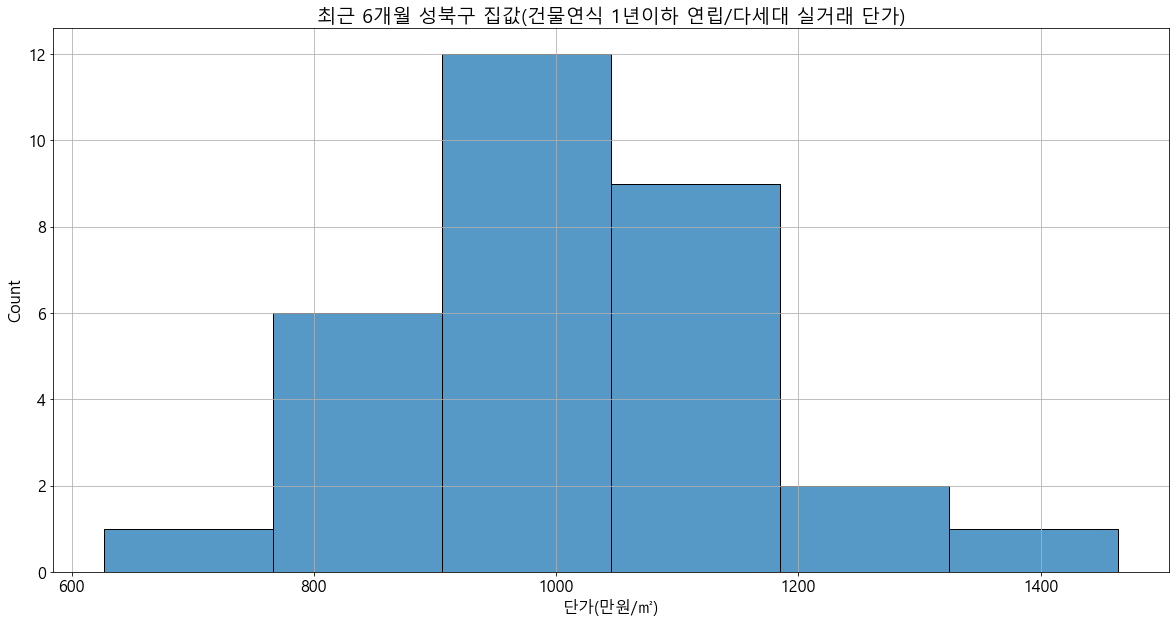

count      31.000000
mean     1021.749202
std       172.556819
min       626.304802
25%       912.396206
50%       962.245239
75%      1154.855643
max      1464.002756
Name: 단가(만원/㎡), dtype: float64
count     309.000000
mean      676.792381
std       504.638634
min        56.731757
25%       384.974335
50%       574.468085
75%       840.840841
max      4291.024960
Name: 단가(만원/㎡), dtype: float64
송파구
제2종일반주거지역    0.636650
제3종일반주거지역    0.194431
자연녹지지역       0.052236
제1종일반주거지역    0.041237
준주거지역        0.028269
개발제한구역       0.019937
일반상업지역       0.018634
생산녹지지역       0.007363
유통상업지역       0.001000
근린상업지역       0.000242
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

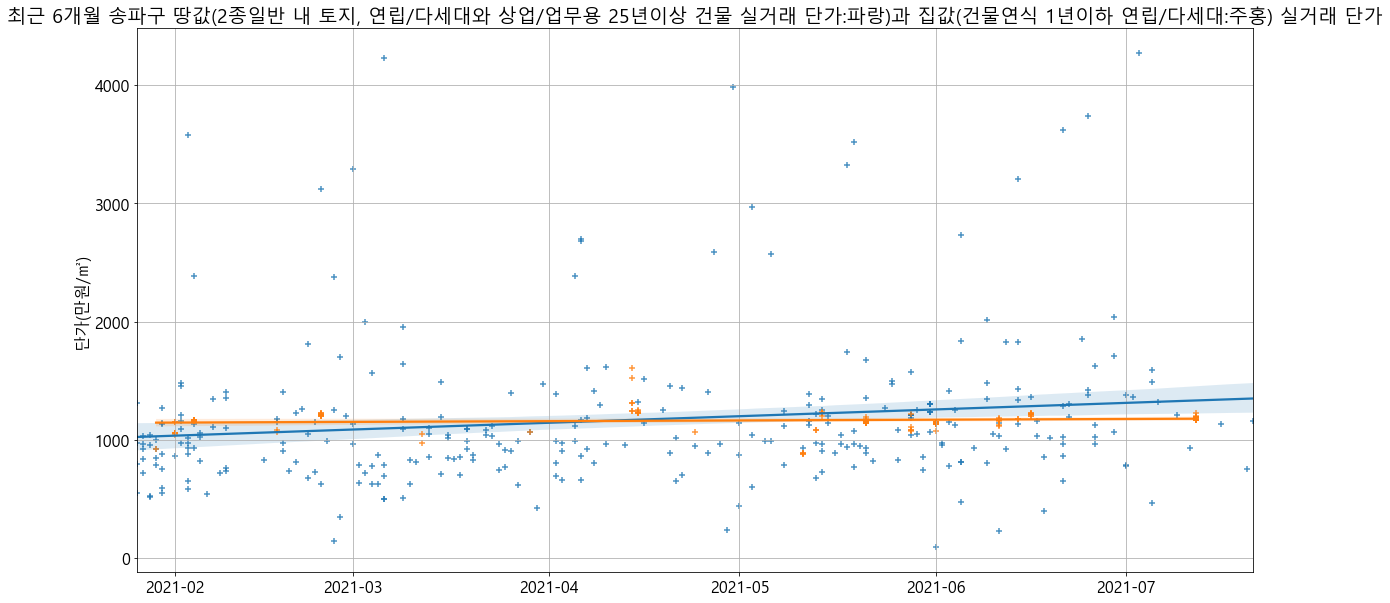

<Figure size 432x288 with 0 Axes>

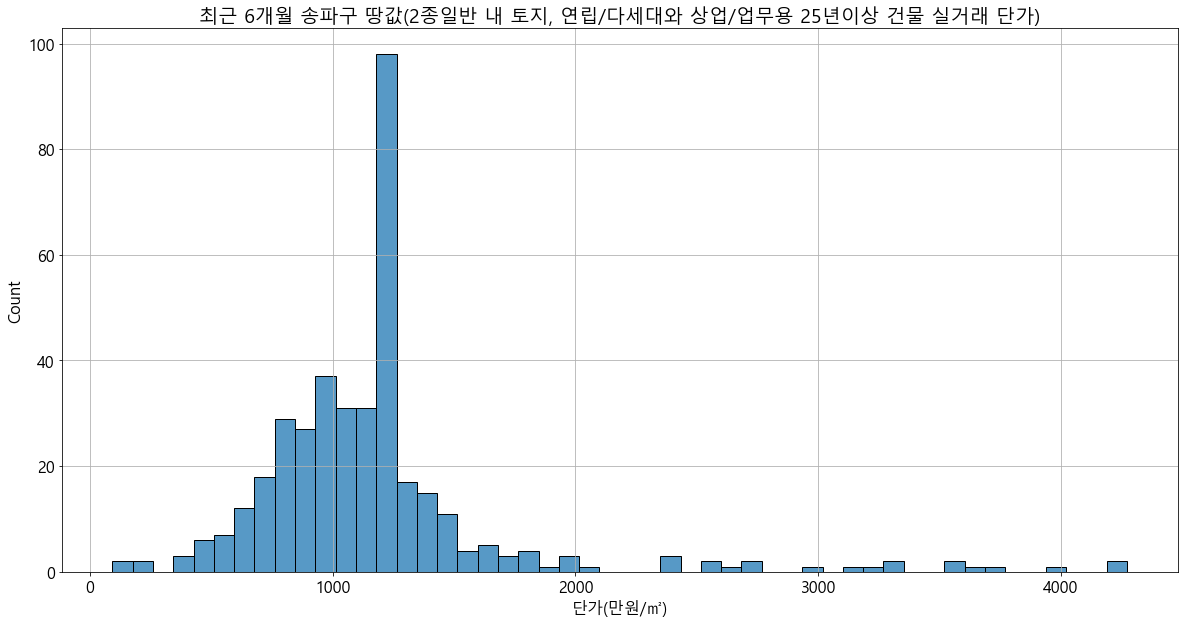

<Figure size 432x288 with 0 Axes>

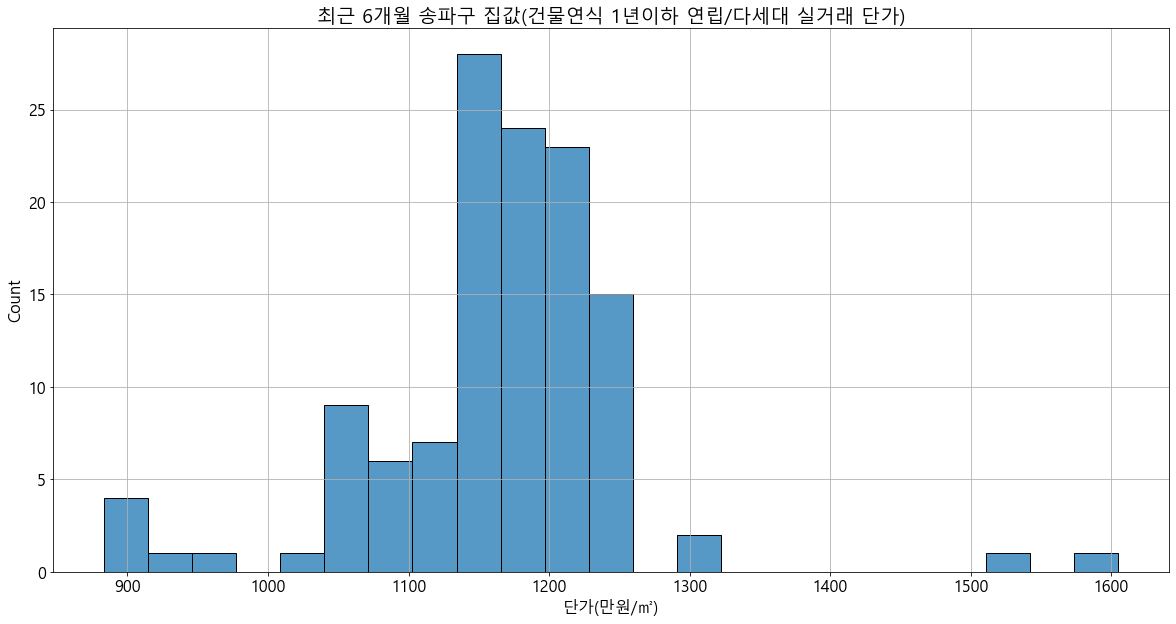

count     123.000000
mean     1163.740928
std        94.496540
min       883.147585
25%      1139.046646
50%      1170.390130
75%      1217.212927
max      1604.850214
Name: 단가(만원/㎡), dtype: float64
count     387.000000
mean     1183.699824
std       564.112856
min        92.178771
25%       905.637706
50%      1147.446931
75%      1210.902132
max      4272.397721
Name: 단가(만원/㎡), dtype: float64
양천구
제2종일반주거지역    0.663748
제3종일반주거지역    0.181202
제1종일반주거지역    0.064732
준주거지역        0.037693
자연녹지지역       0.026151
일반상업지역       0.010735
근린상업지역       0.007950
개발제한구역       0.007345
준공업지역        0.000444
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

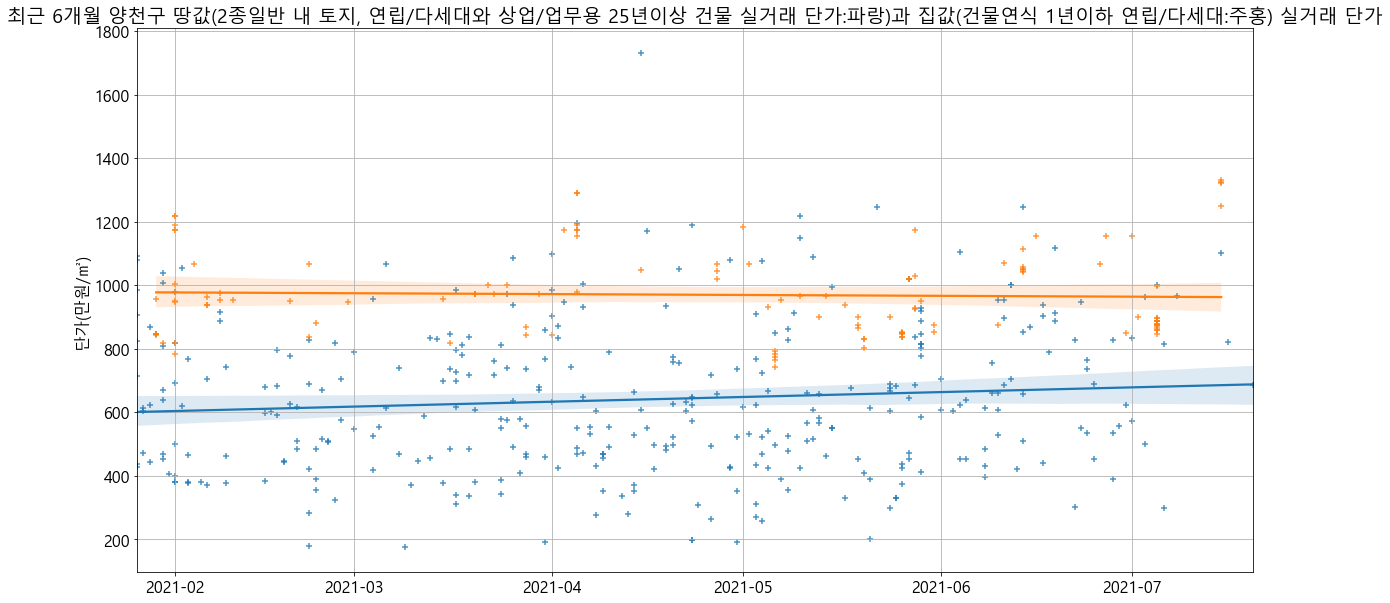

<Figure size 432x288 with 0 Axes>

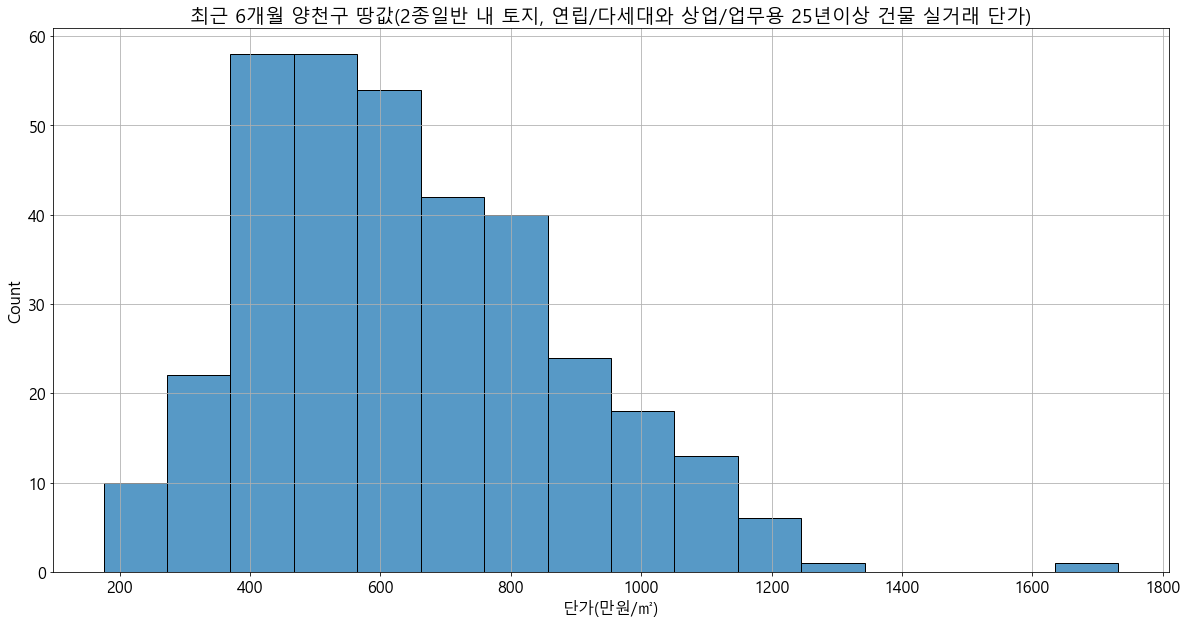

<Figure size 432x288 with 0 Axes>

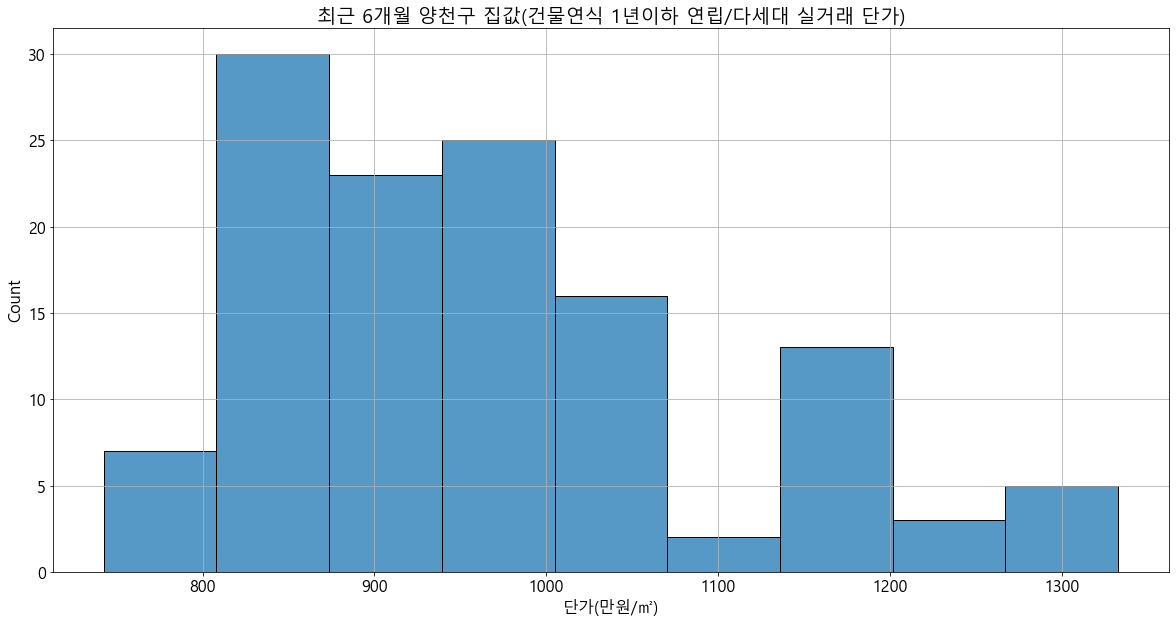

count     124.000000
mean      969.599585
std       136.404661
min       742.474916
25%       866.220736
50%       948.700685
75%      1049.582396
max      1332.658570
Name: 단가(만원/㎡), dtype: float64
count     347.000000
mean      639.916001
std       236.491129
min       175.492611
25%       460.971276
50%       614.182021
75%       809.246619
max      1731.553578
Name: 단가(만원/㎡), dtype: float64
영등포구
제2종일반주거지역    0.550862
준공업지역        0.221425
준주거지역        0.091364
일반상업지역       0.060216
제3종일반주거지역    0.038786
자연녹지지역       0.025503
근린상업지역       0.006066
제1종일반주거지역    0.005778
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

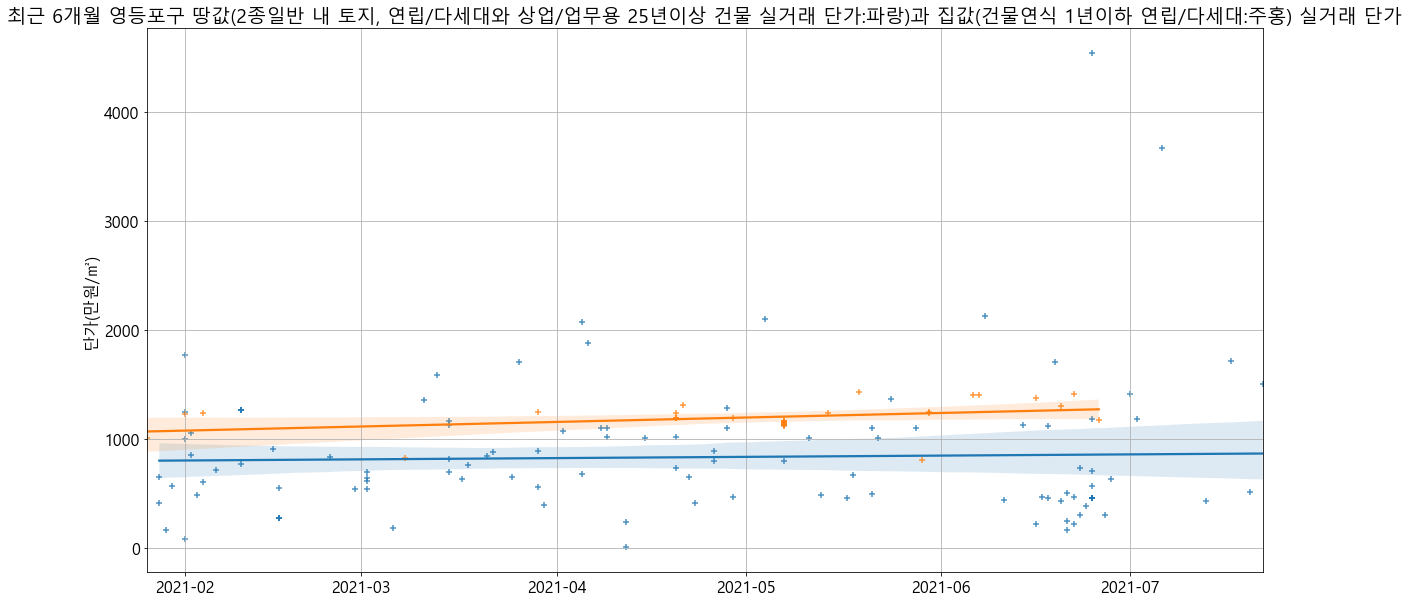

<Figure size 432x288 with 0 Axes>

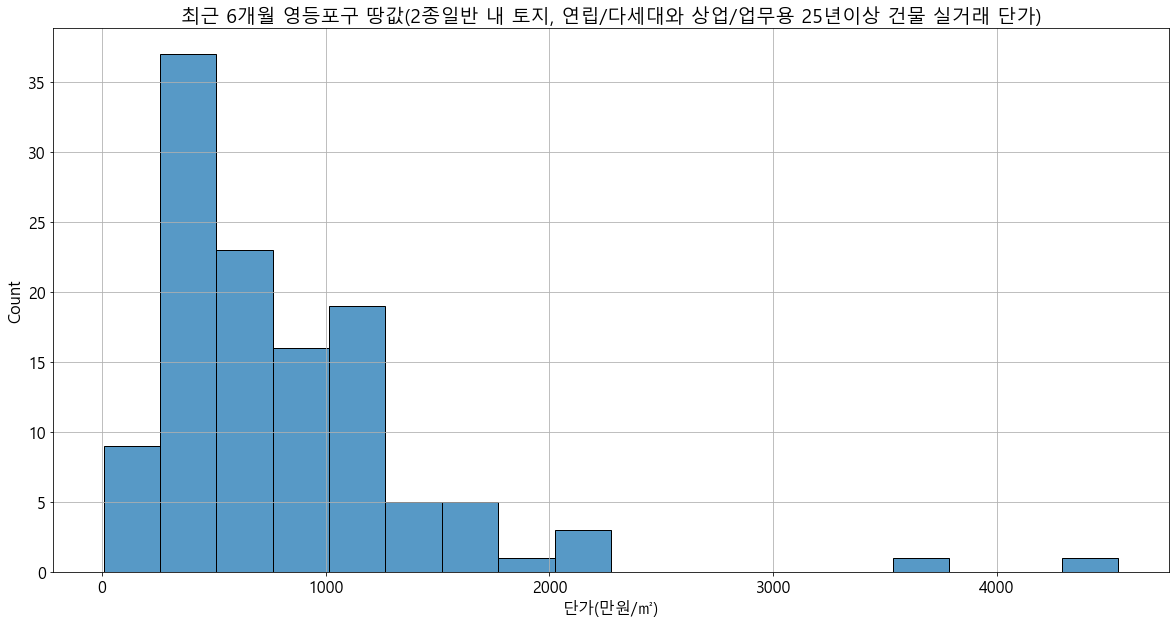

<Figure size 432x288 with 0 Axes>

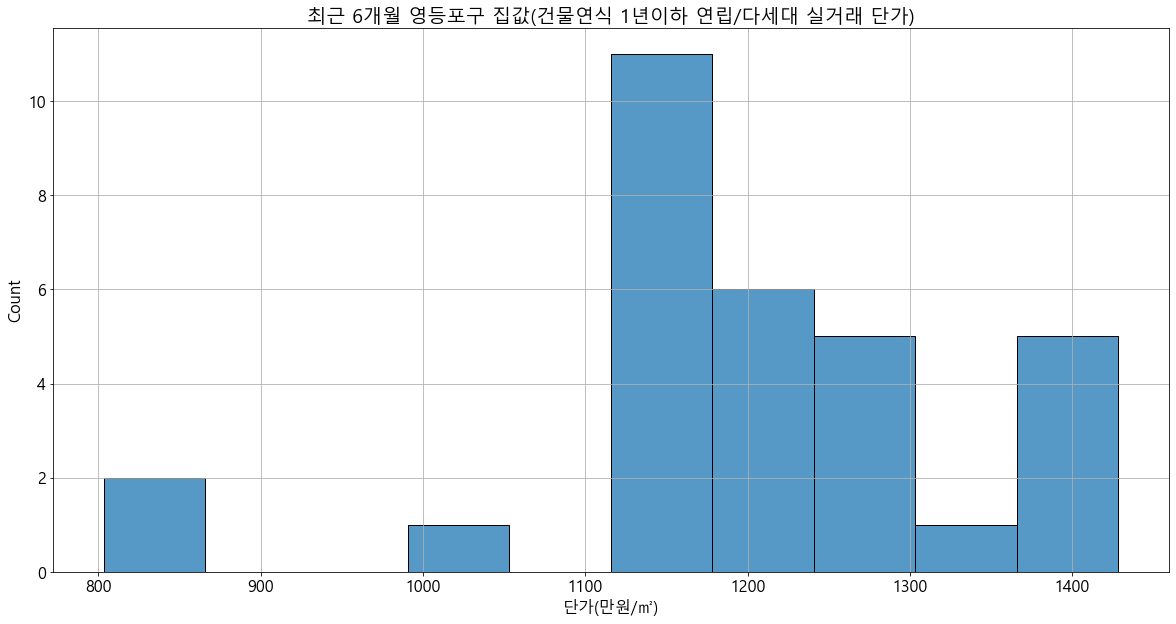

count      31.000000
mean     1198.551823
std       143.513415
min       803.212851
25%      1148.889663
50%      1188.884981
75%      1250.845166
max      1428.094761
Name: 단가(만원/㎡), dtype: float64
count     120.000000
mean      833.755138
std       622.966219
min         7.552870
25%       453.574363
50%       657.201195
75%      1099.124771
max      4541.718044
Name: 단가(만원/㎡), dtype: float64
용산구
제2종일반주거지역    0.476538
제1종일반주거지역    0.239756
제3종일반주거지역    0.105674
일반상업지역       0.098337
준주거지역        0.058650
제1종전용주거지역    0.011254
자연녹지지역       0.008577
보전녹지지역       0.001215
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

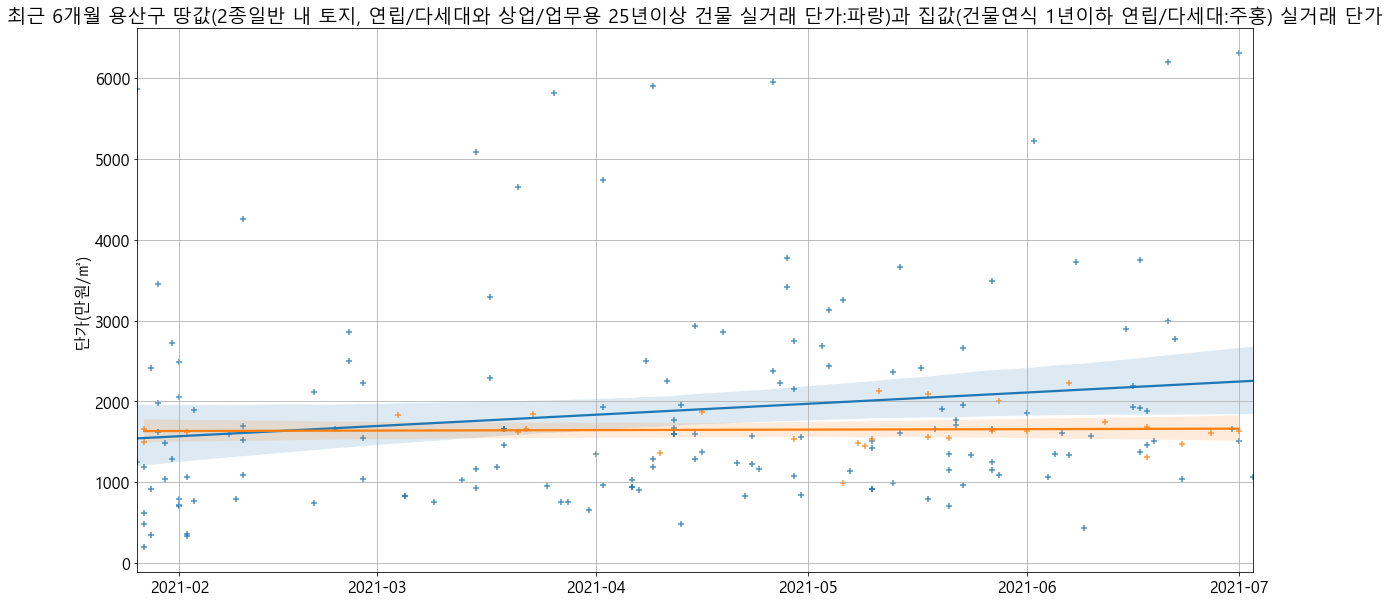

<Figure size 432x288 with 0 Axes>

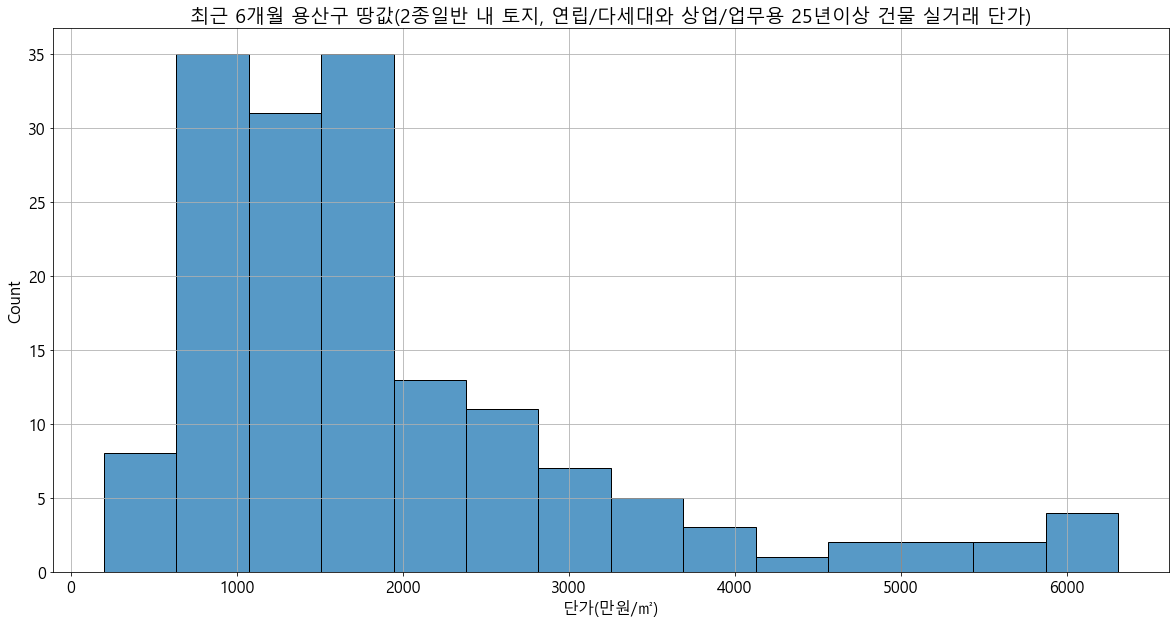

<Figure size 432x288 with 0 Axes>

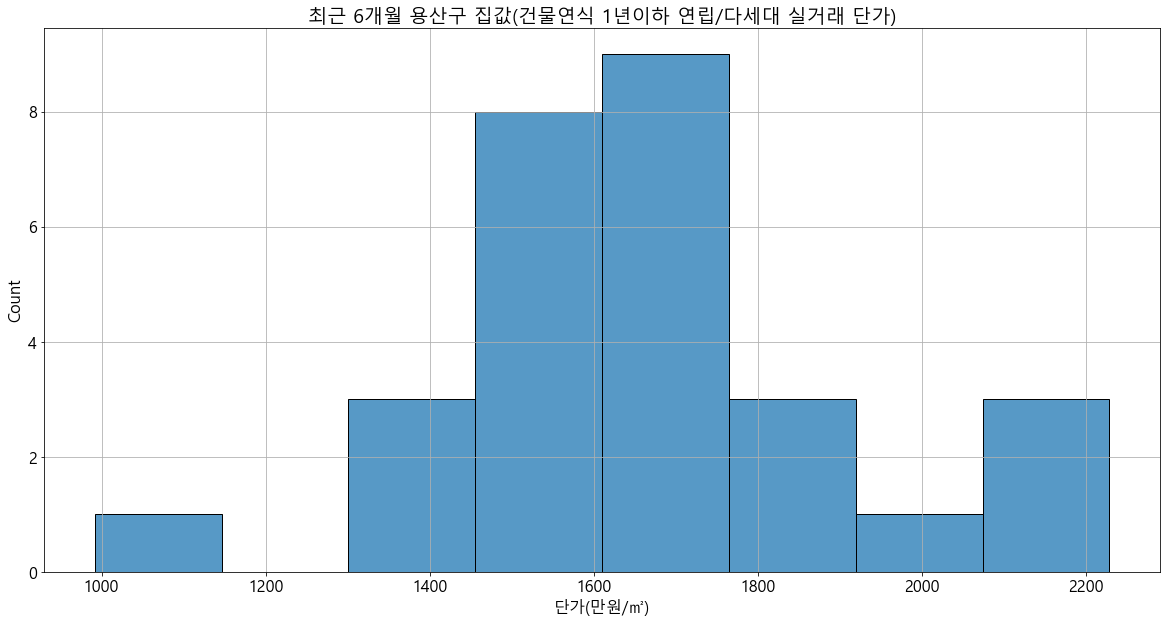

count      28.000000
mean     1650.974651
std       259.297443
min       991.796665
25%      1524.840165
50%      1627.477326
75%      1768.227491
max      2228.412256
Name: 단가(만원/㎡), dtype: float64
count     159.000000
mean     1879.165321
std      1258.127020
min       197.368421
25%      1048.460062
50%      1571.428571
75%      2275.087695
max      6311.475410
Name: 단가(만원/㎡), dtype: float64
은평구
제2종일반주거지역    0.601820
제3종일반주거지역    0.141751
제1종일반주거지역    0.096667
준주거지역        0.063859
개발제한구역       0.053247
일반상업지역       0.025391
근린상업지역       0.009579
제1종전용주거지역    0.006118
자연녹지지역       0.001147
제2종전용주거지역    0.000421
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

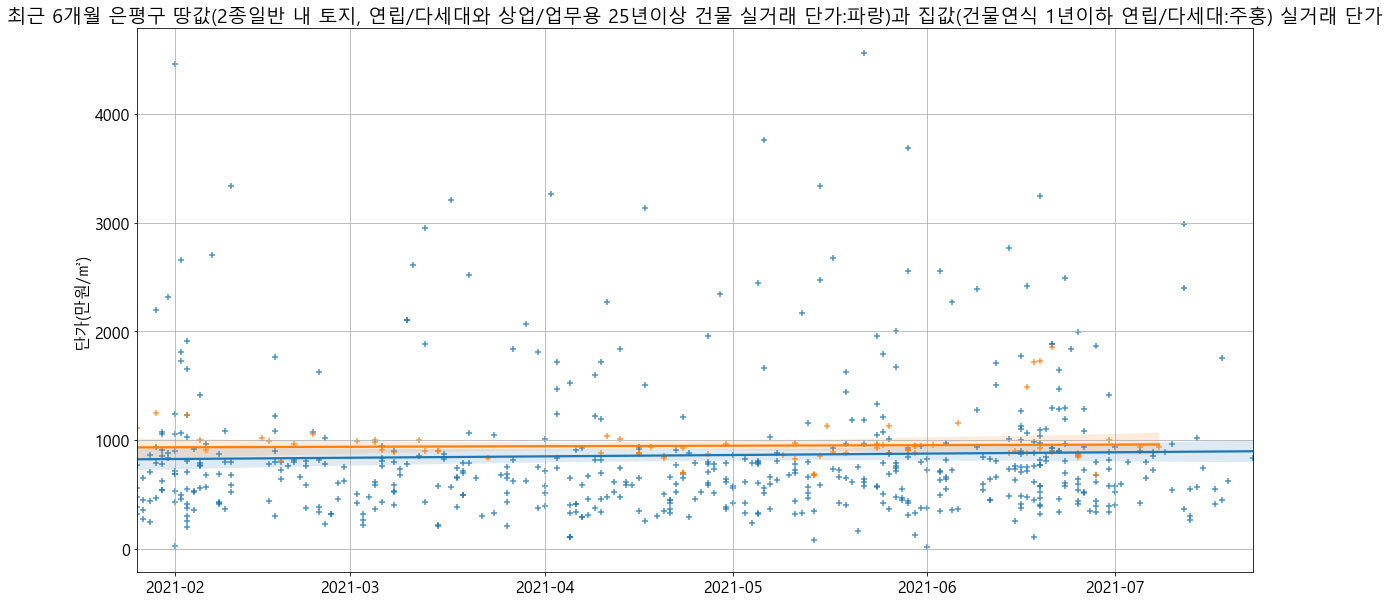

<Figure size 432x288 with 0 Axes>

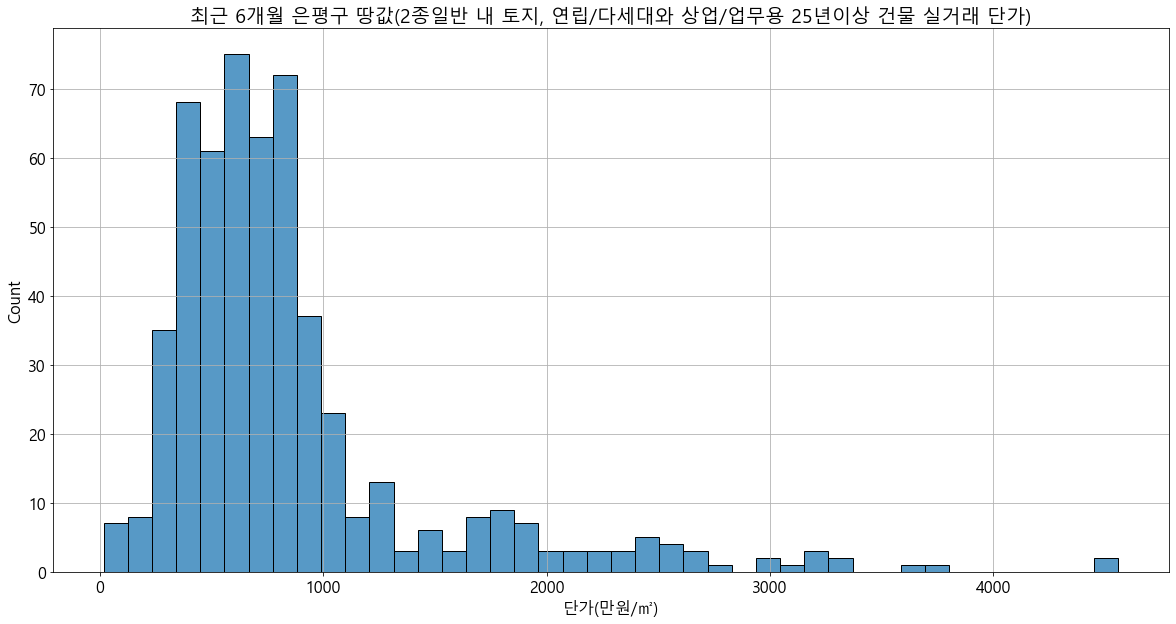

<Figure size 432x288 with 0 Axes>

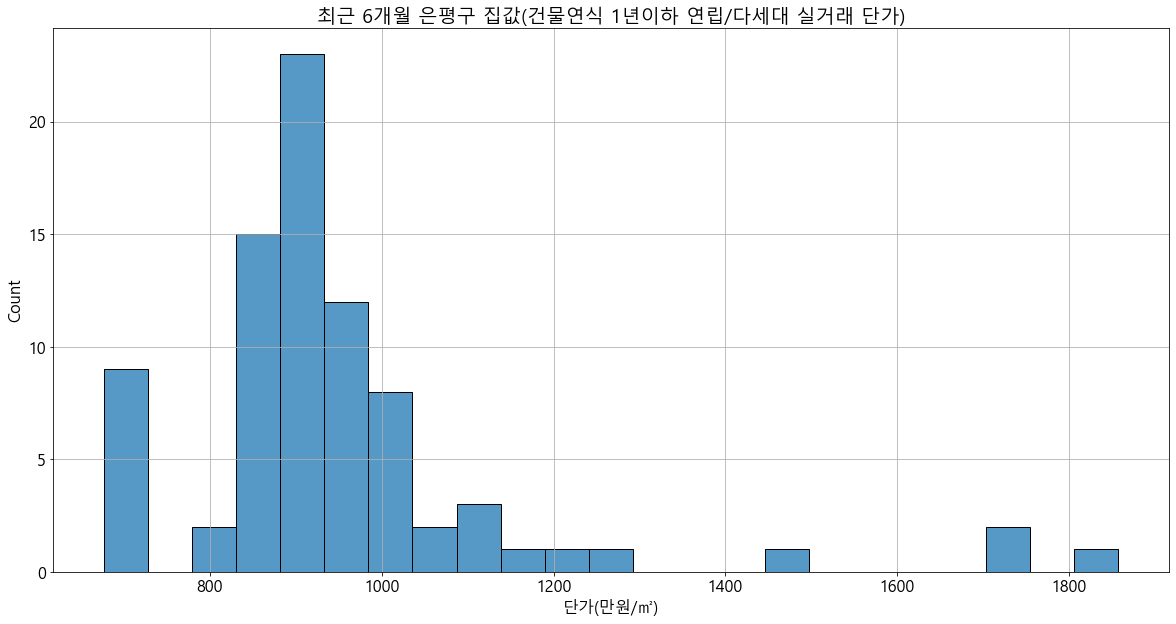

count      81.000000
mean      948.848952
std       208.441172
min       676.328502
25%       867.823765
50%       908.156271
75%       982.111540
max      1857.142857
Name: 단가(만원/㎡), dtype: float64
count     543.000000
mean      860.178824
std       640.396188
min        16.666667
25%       475.196286
50%       703.703704
75%       923.788076
max      4559.859155
Name: 단가(만원/㎡), dtype: float64
종로구
제2종일반주거지역    0.324589
일반상업지역       0.270031
제1종일반주거지역    0.230027
제3종일반주거지역    0.061698
제1종전용주거지역    0.053756
개발제한구역       0.030379
준주거지역        0.020912
자연녹지지역       0.008607
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

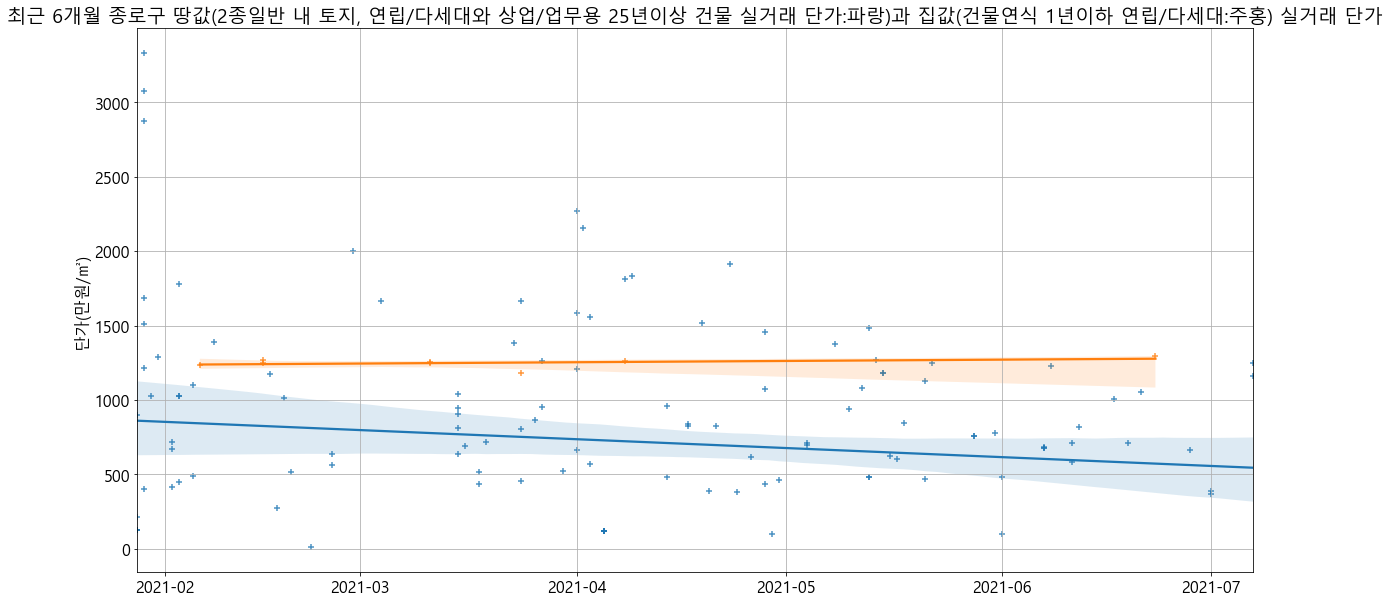

<Figure size 432x288 with 0 Axes>

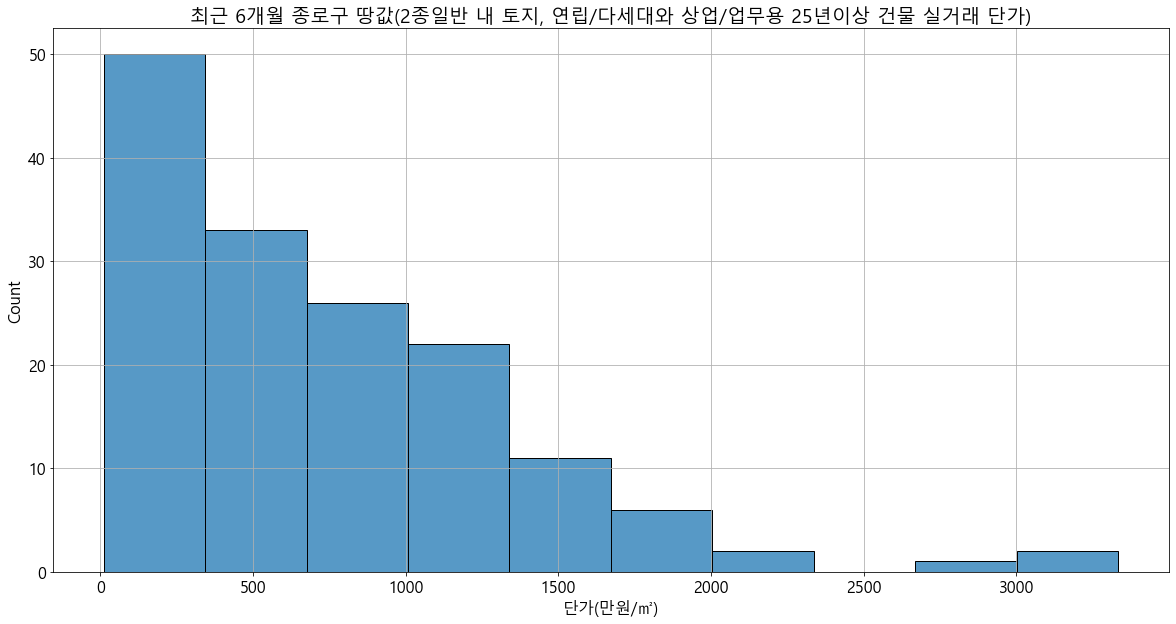

<Figure size 432x288 with 0 Axes>

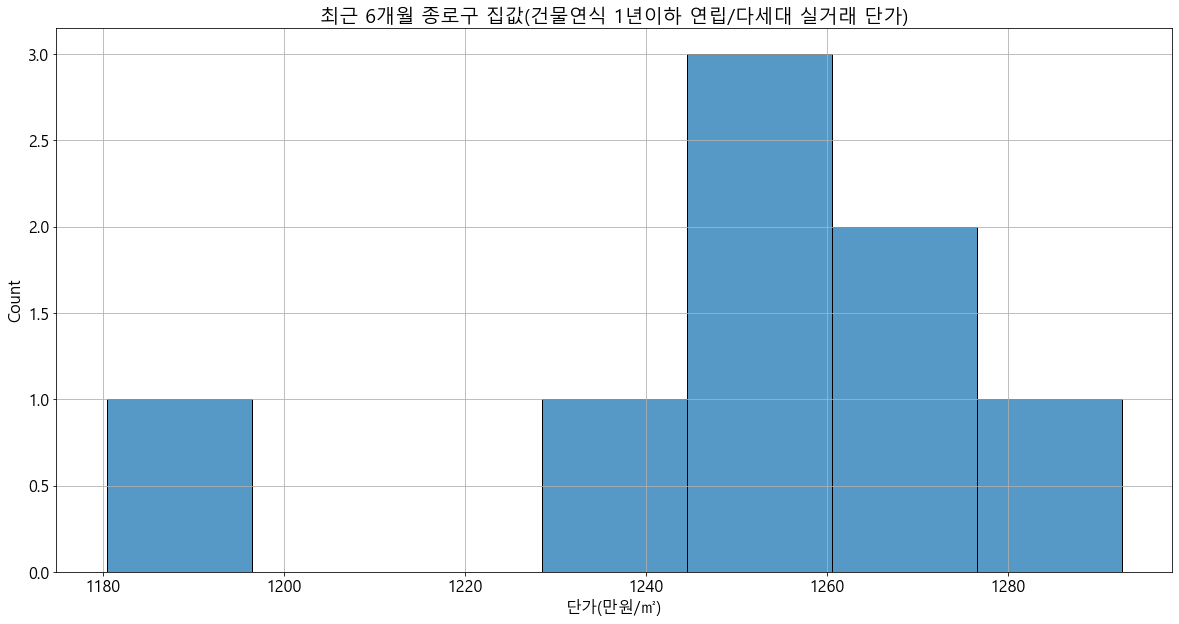

count       8.000000
mean     1249.933997
std        32.676807
min      1180.509042
25%      1246.664910
50%      1254.024779
75%      1264.197155
max      1292.517007
Name: 단가(만원/㎡), dtype: float64
count     153.000000
mean      726.368800
std       629.003175
min        10.781671
25%       121.212121
50%       636.704120
75%      1054.216867
max      3333.333333
Name: 단가(만원/㎡), dtype: float64
중구
일반상업지역       0.462572
제2종일반주거지역    0.294176
제3종일반주거지역    0.089881
제1종일반주거지역    0.088600
준주거지역        0.035430
중심상업지역       0.029342
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

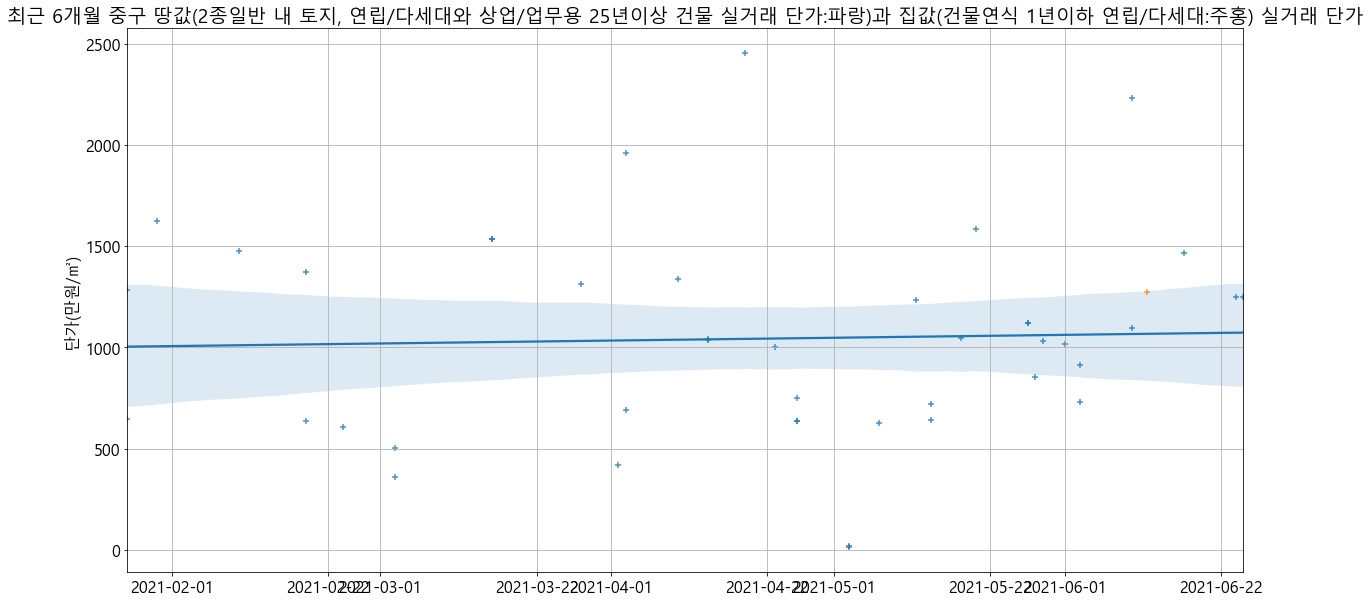

<Figure size 432x288 with 0 Axes>

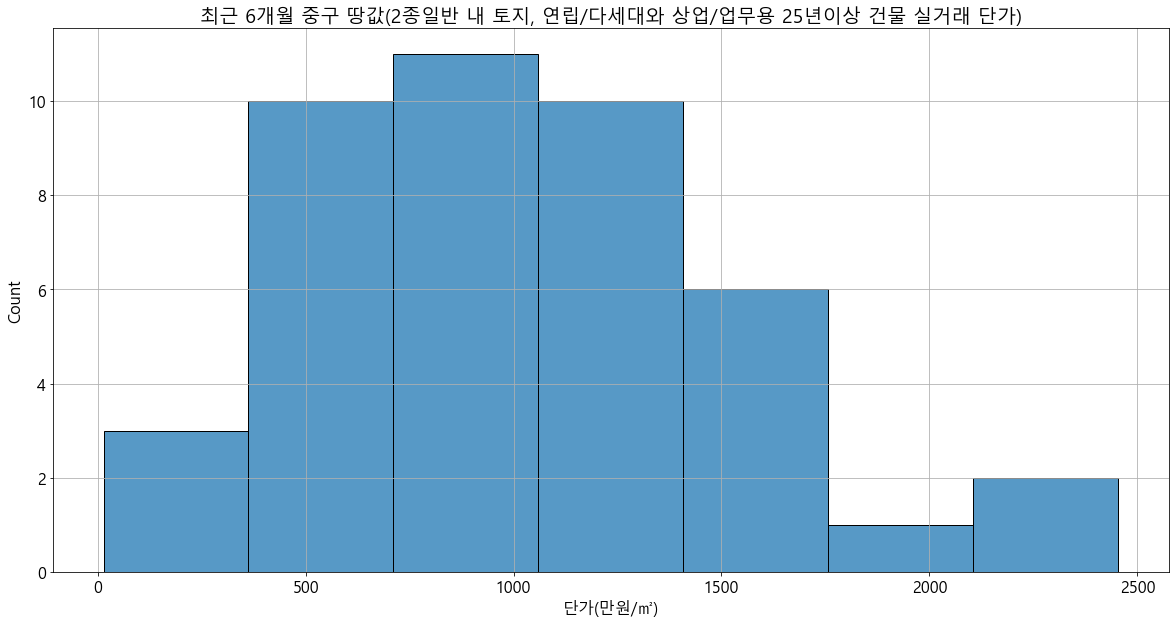

<Figure size 432x288 with 0 Axes>

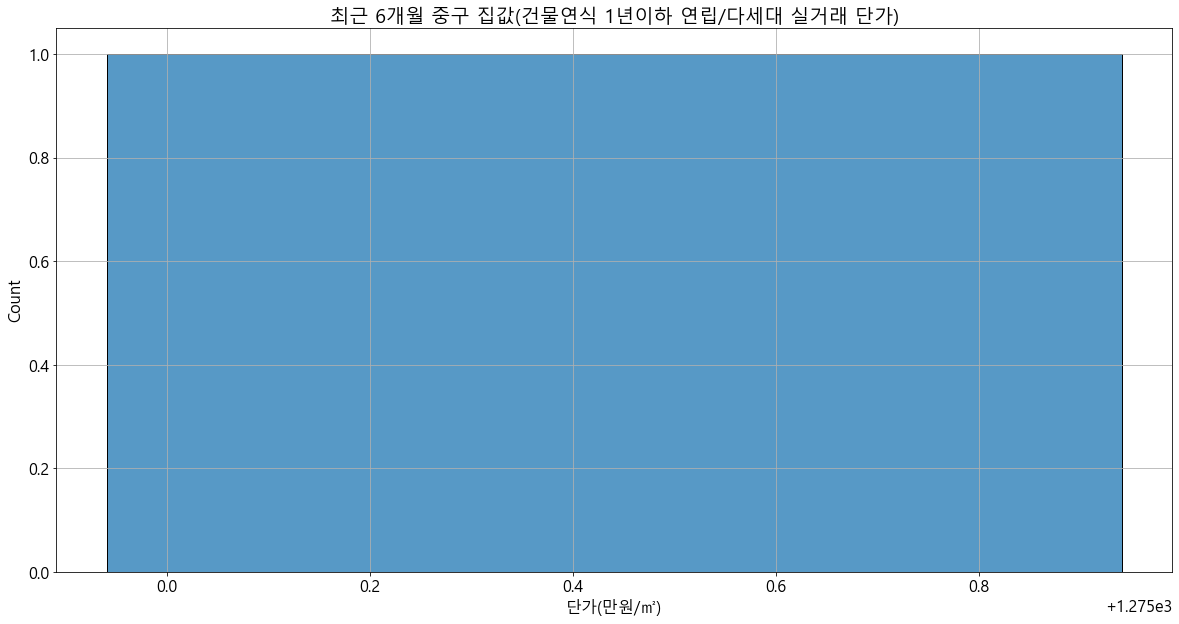

count       1.000000
mean     1275.440977
std              NaN
min      1275.440977
25%      1275.440977
50%      1275.440977
75%      1275.440977
max      1275.440977
Name: 단가(만원/㎡), dtype: float64
count      43.000000
mean     1042.560185
std       513.768816
min        14.285714
25%       643.960086
50%      1035.502959
75%      1325.651421
max      2453.580902
Name: 단가(만원/㎡), dtype: float64
중랑구
제2종일반주거지역    0.615623
제3종일반주거지역    0.185899
준주거지역        0.058450
제1종일반주거지역    0.047925
개발제한구역       0.042507
자연녹지지역       0.027805
일반상업지역       0.011814
근린상업지역       0.009976
Name: 용도지역명1, dtype: float64


<Figure size 432x288 with 0 Axes>

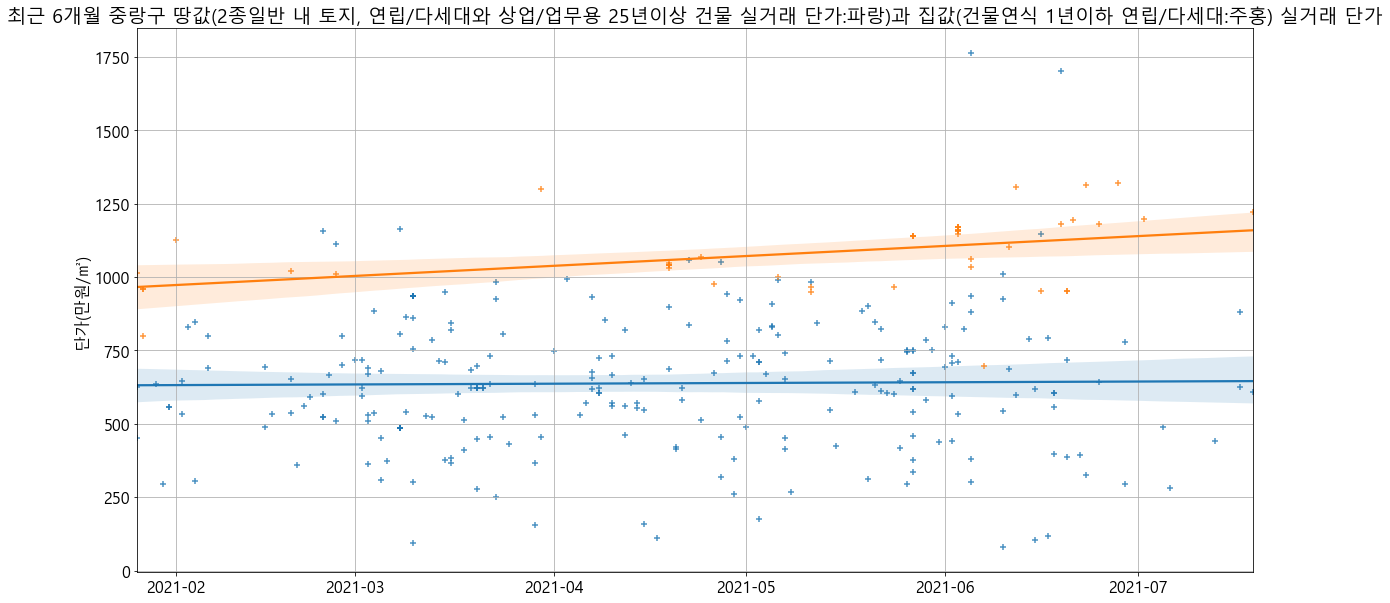

<Figure size 432x288 with 0 Axes>

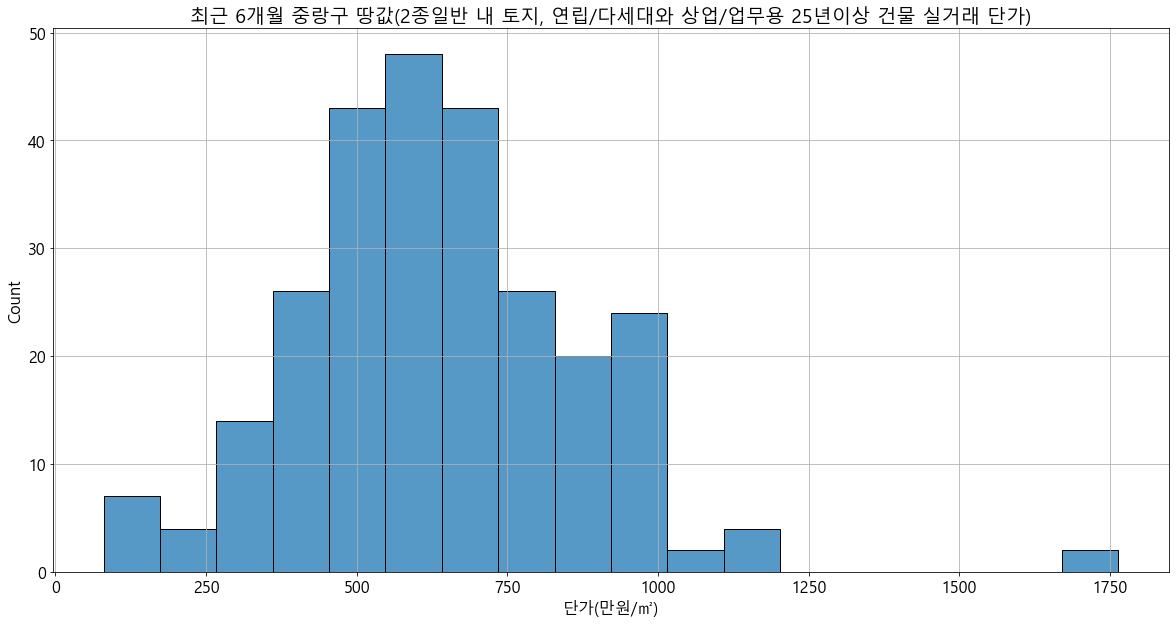

<Figure size 432x288 with 0 Axes>

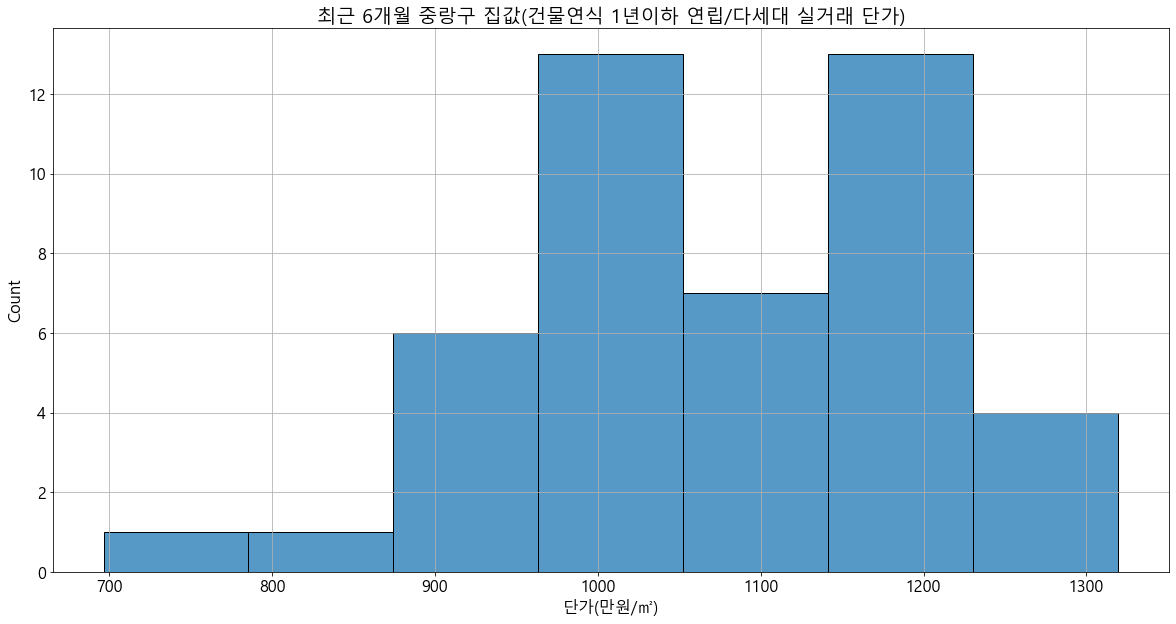

count      45.000000
mean     1082.405154
std       128.943851
min       696.428571
25%       999.310820
50%      1068.228808
75%      1171.457219
max      1319.490958
Name: 단가(만원/㎡), dtype: float64
count     263.000000
mean      637.972539
std       233.248632
min        80.213904
25%       485.057370
50%       620.828806
75%       786.375661
max      1763.803681
Name: 단가(만원/㎡), dtype: float64


<Figure size 432x288 with 0 Axes>

In [27]:
stats_df = pd.DataFrame({'구':[], '땅값_중간값':[], '땅값_평균':[], '집값_중간값':[], '집값_평균':[]})

target_purpose = '2종일반'
font = {'size': 16}
matplotlib.rc('font', **font)
count = 0
for gu in yunrip_merge_df['구'].unique():
    print(gu)
    
    last_addr_df = last_df[
        (last_df['구'] == gu)
    ]
    
    val_counts = last_addr_df['용도지역명1'].value_counts(normalize=True)
    print(val_counts)
    
    # 집값
    yunrip_addr_df = yunrip_merge_df[
        (yunrip_merge_df['구'] == gu)
    ]
    
    # 땅값
    common_addr_df = common_df[
        (common_df['구'] == gu)
        &(common_df['용도지역'].str.contains(target_purpose))
    ]
    
    val_counts_df = pd.DataFrame({'{}'.format(gu):[idx for idx in val_counts.index],
                                  '비율':[v for v in val_counts.values]
                                 })
    
    val_counts_df.to_excel('./국토교통부_실거래가_공개시스템/땅집값_비교분석_최근{}개월_구별/{}_용도지역_비율.xlsx'.format(target_months, gu), index=False)
    
    f, ax = plt.subplots(figsize=(20,10))
    plt.title('최근 {}개월 {} 땅값(2종일반 내 토지, 연립/다세대와 상업/업무용 25년이상 건물 실거래 단가:파랑)과 집값(건물연식 1년이하 연립/다세대:주홍) 실거래 단가'.format(target_months, gu))
    plt.grid(True)
    ax.xaxis.update_units(common_addr_df['계약날짜'])
    sns.regplot(x=ax.xaxis.convert_units(common_addr_df['계약날짜']), y=common_addr_df['단가(만원/㎡)'], order=1,# ci=None,
                marker='+'
               )
    ax.xaxis.update_units(yunrip_addr_df['계약날짜'])
    sns.regplot(x=ax.xaxis.convert_units(yunrip_addr_df['계약날짜']), y=yunrip_addr_df['단가(만원/㎡)'], order=1,# ci=None,
                marker='+'
               )
    #plt.ylim([0, 1500])
    plt.savefig('국토교통부_실거래가_공개시스템/땅집값_비교분석_최근{}개월_구별/{}_산포도.png'.format(target_months, gu))
    
    plt.show()
    plt.clf()
    
    f, ax = plt.subplots(figsize=(20,10))
    plt.title('최근 {}개월 {} 땅값(2종일반 내 토지, 연립/다세대와 상업/업무용 25년이상 건물 실거래 단가)'.format(target_months, gu))
    plt.grid(True)
    sns.histplot(common_addr_df['단가(만원/㎡)'])
    
    plt.savefig('국토교통부_실거래가_공개시스템/땅집값_비교분석_최근{}개월_구별/{}_땅값_분포도.png'.format(target_months, gu))
    
    plt.show()
    plt.clf()
    
    f, ax = plt.subplots(figsize=(20,10))
    plt.title('최근 {}개월 {} 집값(건물연식 1년이하 연립/다세대 실거래 단가)'.format(target_months, gu))
    plt.grid(True)
    sns.histplot(yunrip_addr_df['단가(만원/㎡)'])
    
    plt.savefig('국토교통부_실거래가_공개시스템/땅집값_비교분석_최근{}개월_구별/{}_집값_분포도.png'.format(target_months, gu))
    
    plt.show()
    plt.clf()
    
    
    
    house_price_description = yunrip_addr_df['단가(만원/㎡)'].describe()
    land_price_description = common_addr_df['단가(만원/㎡)'].describe()
    
    print(house_price_description)
    print(land_price_description)
    
    house_price_description_df = pd.DataFrame({'{}'.format(gu): [idx for idx in house_price_description.index],
                                               '값': [v for v in house_price_description.values]
                                              })
    land_price_description_df = pd.DataFrame({'{}'.format(gu): [idx for idx in land_price_description.index],
                                               '값': [v for v in land_price_description.values]
                                              })
    
    house_price_description_df.to_excel('./국토교통부_실거래가_공개시스템/땅집값_비교분석_최근{}개월_구별/{}_집값_통계수치들.xlsx'.format(target_months, gu), index=False)
    land_price_description_df.to_excel('./국토교통부_실거래가_공개시스템/땅집값_비교분석_최근{}개월_구별/{}_땅값_통계수치들.xlsx'.format(target_months, gu), index=False)
    
    stats_df.loc[count, '구'] = gu
    stats_df.loc[count, '땅값_중간값'] = land_price_description['50%']
    stats_df.loc[count, '땅값_평균'] = land_price_description['mean']
    stats_df.loc[count, '집값_중간값'] = house_price_description['50%']
    stats_df.loc[count, '집값_평균'] = house_price_description['mean']
    
    count += 1

In [28]:
stats_df.head()

,구,땅값_중간값,땅값_평균,집값_중간값,집값_평균
0,강남구,1559.818274,1712.089085,1412.098930,1710.668548
1,강동구,811.462239,822.577359,951.045587,1040.114726
2,강북구,493.612079,535.624308,802.687487,809.860348
3,강서구,601.894441,599.062538,984.646195,992.264803
4,관악구,689.013035,753.371314,968.603874,992.140393


In [29]:
stats_df['중간값_차이'] = stats_df['집값_중간값'] - stats_df['땅값_중간값']
stats_df['평균_차이'] = stats_df['집값_평균'] - stats_df['땅값_평균']

In [30]:
print(stats_df.shape)
stats_df.head()

(25, 7)


,구,땅값_중간값,땅값_평균,집값_중간값,집값_평균,중간값_차이,평균_차이
0,강남구,1559.818274,1712.089085,1412.098930,1710.668548,-147.719343,-1.420537
1,강동구,811.462239,822.577359,951.045587,1040.114726,139.583348,217.537367
2,강북구,493.612079,535.624308,802.687487,809.860348,309.075408,274.236040
3,강서구,601.894441,599.062538,984.646195,992.264803,382.751754,393.202265
4,관악구,689.013035,753.371314,968.603874,992.140393,279.590839,238.769079


In [31]:
stats_ordered_by_median_df = stats_df.sort_values(['중간값_차이'], ascending=False)
print(stats_ordered_by_median_df.shape)
stats_ordered_by_median_df.head()

(25, 7)


,구,땅값_중간값,땅값_평균,집값_중간값,집값_평균,중간값_차이,평균_차이
22,종로구,636.704120,726.368800,1254.024779,1249.933997,617.320659,523.565196
19,영등포구,657.201195,833.755138,1188.884981,1198.551823,531.683785,364.796685
24,중랑구,620.828806,637.972539,1068.228808,1082.405154,447.400001,444.432615
16,성북구,574.468085,676.792381,962.245239,1021.749202,387.777154,344.956821
3,강서구,601.894441,599.062538,984.646195,992.264803,382.751754,393.202265


In [32]:
stats_ordered_by_mean_df = stats_df.sort_values(['평균_차이'], ascending=False)
print(stats_ordered_by_mean_df.shape)
stats_ordered_by_mean_df.head()

(25, 7)


,구,땅값_중간값,땅값_평균,집값_중간값,집값_평균,중간값_차이,평균_차이
22,종로구,636.704120,726.368800,1254.024779,1249.933997,617.320659,523.565196
24,중랑구,620.828806,637.972539,1068.228808,1082.405154,447.400001,444.432615
3,강서구,601.894441,599.062538,984.646195,992.264803,382.751754,393.202265
19,영등포구,657.201195,833.755138,1188.884981,1198.551823,531.683785,364.796685
5,광진구,910.746812,889.839908,1089.174070,1239.214134,178.427258,349.374226


In [33]:
stats_ordered_by_median_df.to_excel('국토교통부_실거래가_공개시스템/땅집값_비교분석_최근{}개월_구별/취합_통계자료/땅집값_비교통계_중간값순정렬.xlsx'.format(target_months), index=False)

In [34]:
stats_ordered_by_mean_df.to_excel('국토교통부_실거래가_공개시스템/땅집값_비교분석_최근{}개월_구별/취합_통계자료/땅집값_비교통계_평균순정렬.xlsx'.format(target_months), index=False)

In [35]:
jongro_df = last_df[last_df['구'] == '종로구']
print(jongro_df.shape)
jongro_df.head()

(51120, 10)


,지번주소,지목명,토지면적,용도지역명1,토지이동상황,지형높이,지형형상,도로접면,구,동
851669,서울특별시 종로구 가회동 1-1,대,63.8,제1종일반주거지역,연립,완경사,부정형,중로한면,종로구,가회동
851670,서울특별시 종로구 가회동 1-10,대,1835.8,제1종일반주거지역,연립,완경사,부정형,중로한면,종로구,가회동
851671,서울특별시 종로구 가회동 1-100,도로,1073.5,제1종일반주거지역,도로등,지정되지않음,지정되지않음,지정되지않음,종로구,가회동
851672,서울특별시 종로구 가회동 1-101,도로,98.5,제1종일반주거지역,도로등,지정되지않음,지정되지않음,지정되지않음,종로구,가회동
851673,서울특별시 종로구 가회동 1-11,대,1655.3,제1종일반주거지역,단독,완경사,부정형,중로한면,종로구,가회동


In [36]:
jongro_semiliving_df = jongro_df[jongro_df['용도지역명1'].str.contains('준주거')]
print(jongro_semiliving_df.shape)
jongro_semiliving_df.head()

(1069, 10)


,지번주소,지목명,토지면적,용도지역명1,토지이동상황,지형높이,지형형상,도로접면,구,동
852899,서울특별시 종로구 계동 140-100,대,9.5,준주거지역,상업용,평지,사다리형,중로한면,종로구,계동
852909,서울특별시 종로구 계동 140-111,도로,1149.8,준주거지역,도로등,지정되지않음,지정되지않음,지정되지않음,종로구,계동
852914,서울특별시 종로구 계동 140-2,대,19366.8,준주거지역,업무용,평지,사다리형,광대소각,종로구,계동
852940,서울특별시 종로구 계동 140-49,대,59.6,준주거지역,상업용,평지,가로장방,중로한면,종로구,계동
852942,서울특별시 종로구 계동 140-50,대,57.5,준주거지역,상업용,평지,가로장방,중로한면,종로구,계동


In [37]:
jongro_semiliving_df = jongro_semiliving_df.sort_values(['지번주소'])

In [38]:
jongro_semiliving_df.to_excel('종로구_준주거.xlsx', index=False)

In [39]:
jongro_semiliving_df['동'].value_counts(normalize=True)

창신동      0.453695
숭인동      0.323667
신문로2가    0.092610
원서동      0.041160
신문로1가    0.023386
내수동      0.019645
계동       0.013096
연건동      0.011225
운니동      0.005613
사직동      0.005613
내자동      0.005613
당주동      0.004677
Name: 동, dtype: float64

In [40]:
changsin_df = jongro_semiliving_df[jongro_semiliving_df['동'] == '창신동']
print(changsin_df.shape)
changsin_df.head()

(485, 10)


,지번주소,지목명,토지면적,용도지역명1,토지이동상황,지형높이,지형형상,도로접면,구,동
885236,서울특별시 종로구 창신동 131-140,도로,304.1,준주거지역,도로등,지정되지않음,지정되지않음,지정되지않음,종로구,창신동
885237,서울특별시 종로구 창신동 131-145,도로,42.4,준주거지역,도로등,지정되지않음,지정되지않음,지정되지않음,종로구,창신동
885238,서울특별시 종로구 창신동 131-146,도로,6.8,준주거지역,도로등,지정되지않음,지정되지않음,지정되지않음,종로구,창신동
885239,서울특별시 종로구 창신동 131-147,도로,7.3,준주거지역,도로등,지정되지않음,지정되지않음,지정되지않음,종로구,창신동
885316,서울특별시 종로구 창신동 137-0,대,160.4,준주거지역,주상기타,완경사,사다리형,세로한면(가),종로구,창신동


In [42]:
changsin_df = changsin_df.sort_values(['지번주소'])

In [43]:
changsin_df.to_excel('종로구_창신동_준주거.xlsx', index=False)

In [44]:
sungin_df = jongro_semiliving_df[jongro_semiliving_df['동'] == '숭인동']
print(sungin_df.shape)
sungin_df.head()

(346, 10)


,지번주소,지목명,토지면적,용도지역명1,토지이동상황,지형높이,지형형상,도로접면,구,동
869948,서울특별시 종로구 숭인동 100-1,대,86.0,준주거지역,주상기타,평지,부정형,세로한면(불),종로구,숭인동
869949,서울특별시 종로구 숭인동 102-1,대,130.9,준주거지역,상업용,평지,사다리형,광대세각,종로구,숭인동
869950,서울특별시 종로구 숭인동 102-12,대,9.1,준주거지역,상업기타,평지,사다리형,광대세각,종로구,숭인동
869951,서울특별시 종로구 숭인동 102-13,대,34.7,준주거지역,상업기타,평지,사다리형,광대세각,종로구,숭인동
869953,서울특별시 종로구 숭인동 102-4,도로,455.7,준주거지역,도로등,지정되지않음,지정되지않음,지정되지않음,종로구,숭인동


In [45]:
sungin_df = sungin_df.sort_values(['지번주소'])
sungin_df.to_excel('종로구_숭인동_준주거.xlsx', index=False)